In [1756]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #importo librería para normalizar la información
#!pip install pyod
#https://github.com/fbetteo/dm-BankChurn

## Path

In [1757]:
path_base = 'input/Base_Modelo.csv'

In [1758]:
path_dicc_datos = 'input/desc_campos_base.csv'

# Introducción

**Problema**

El caso propuesto a analizar se enmarca dentro de la investigación de marketing de los "Churn Rates" o Tasas de Cancelación. Lo que se busca es:


- Entender la situación actual de pérdida de clientes del Banco X.

- Buscar cuáles son las variables que mejor explican el fenómeno

- Desarrollar un modelo que permita predecir los clientes que se darán de baja dentro de los próximos dos meses

- Interpretar los motivos de bajas de clientes y definir acciones comerciales de retención oara el área de marketing.

A tal efecto se remitió una base con información sobre los clientes de dicho banco poseedoras de cuentas, donde prevalencen aquellos con paquetes premium. El diccionario de datos se muestra a continuación:

In [1759]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
pd.read_csv(path_dicc_datos, sep = ';', encoding = 'latin')

campo_base  \
0             CAUTOSERVICIO_TRANSACCIONES   
1           CCAJEROS_AJENOS_TRANSACCIONES   
2           CCAJEROS_PROPIO_TRANSACCIONES   
3             CCAJEROS_PROPIOS_DESCUENTOS   
4               CCALLCENTER_TRANSACCIONES   
5                  CCAMBIO_MONEDAS_COMPRA   
6                   CCAMBIO_MONEDAS_VENTA   
7                    CCHEQUES_DEPOSITADOS   
8          CCHEQUES_DEPOSITADOS_RECHAZADO   
9                       CCHEQUES_EMITIDOS   
10           CCHEQUES_EMITIDOS_RECHAZADOS   
11              CCOMISIONES_MANTENIMIENTO   
12                      CCOMISIONES_OTRAS   
13                     CCUENTA_DESCUENTOS   
14               CEXTRACCION_AUTOSERVICIO   
15             CHOMEBANKING_TRANSACCIONES   
16                           ClaseBinaria   
17                              CLASECORR   
18                               ClaseNum   
19                     CLIENTE_ANTIGUEDAD   
20                           CLIENTE_EDAD   
21                       CLIENTE_SUCURSAL   
22                            CLIENTE_VIP   
23               CPLAN_SUELDO_TRANSACCION   
24                CPRESTAMOS_HIPOTECARIOS   
25                  CPRESTAMOS_PERSONALES   
26                  CPRESTAMOS_PRENDARIOS   
27          CTARJETA_DEBITO_TRANSACCIONES   
28             CTARJETA_MASTER_DESCUENTOS   
29          CTARJETA_MASTER_TRANSACCIONES   
30               CTARJETA_VISA_DESCUENTOS   
31            CTARJETA_VISA_TRANSACCIONES   
32               CTRANSFERENCIAS_EMITIDAS   
33              CTRANSFERENCIAS_RECIBIDAS   
34                        MACTIVOS_MARGEN   
35         MARKETING_ACTIVO_ULTIMOS90DIAS   
36                 MARKETING_COSS_SELLING   
37                   MASTER_CUENTA_ESTADO   
38                     MASTER_FINICIOMORA   
39                    MASTER_MARCA_ATRASO   
40                MASTER_MCONSUMOSDOLARES   
41                  MASTER_MCONSUMOSPESOS   
42             MASTER_MCONSUMOSPESOSxesta   
43            MASTER_MCONSUMOSPESOSxinfla   
44                   MASTER_MCONSUMOTOTAL   
45              MASTER_MCONSUMOTOTALxesta   
46             MASTER_MCONSUMOTOTALxinfla   
47                         MASTER_MPAGADO   
48                    MASTER_MPAGADOxesta   
49                   MASTER_MPAGADOxinfla   
50                   MASTER_MPAGOSDOLARES   
51                     MASTER_MPAGOSPESOS   
52                   MASTER_MSALDODOLARES   
53              MASTER_MSALDODOLARESxesta   
54             MASTER_MSALDODOLARESxinfla   
55                     MASTER_MSALDOPESOS   
56                     MASTER_MSALDOTOTAL   
57              MASTER_TADELANTOSEFECTIVO   
58                       MASTER_TCONSUMOS   
59                          MAUTOSERVICIO   
60                    MBONOS_CORPORATIVOS   
61                        MBONOS_GOBIERNO   
62                   MCAJA_AHORRO_DOLARES   
63              MCAJA_AHORRO_DOLARESxesta   
64             MCAJA_AHORRO_DOLARESxinfla   
65                 MCAJA_AHORRO_NOPAQUETE   
66                   MCAJA_AHORRO_PAQUETE   
67                        MCAJEROS_AJENOS   
68                        MCAJEROS_PROPIO   
69            MCAJEROS_PROPIOS_DESCUENTOS   
70       MCAJEROS_PROPIOS_DESCUENTOSxesta   
71      MCAJEROS_PROPIOS_DESCUENTOSxinfla   
72                 MCAMBIO_MONEDAS_COMPRA   
73                  MCAMBIO_MONEDAS_VENTA   
74             MCAMBIO_MONEDAS_VENTAxesta   
75            MCAMBIO_MONEDAS_VENTAxinfla   
76                   MCHEQUES_DEPOSITADOS   
77         MCHEQUES_DEPOSITADOS_RECHAZADO   
78                      MCHEQUES_EMITIDOS   
79           MCHEQUES_EMITIDOS_RECHAZADOS   
80              MCUENTA_CORRIENTE_DOLARES   
81            MCUENTA_CORRIENTE_NOPAQUETE   
82              MCUENTA_CORRIENTE_PAQUETE   
83         MCUENTA_CORRIENTE_PAQUETExesta   
84        MCUENTA_CORRIENTE_PAQUETExinfla   
85            MCUENTA_DEBITOS_AUTOMATICOS   
86       MCUENTA_DEBITOS_AUTOMATICOSxesta   
87      MCUENTA_DEBITOS_AUTOMATICOSxinfla   
88                     MCU

Como se aprecia, las variables corresponden a distintos atributos relevados por el área de marketing a lo largo de distintas fechas. Previo a la ETL y el EDA se realizan dos consideraciones:

1) Debido a que no se se sabe el snapshot de la base, no se incluirán para el análisis las variables de fechas, aunque sí se tomarán aquella información ya calculada sobre las mismas (por ejemplo, edad, antigüedad, etc.)

2) En base a la investigación sobre el origen de la base, se comprende que la misma apunta a una decisión del área de marketing del banco de predecir las cancelaciones de los paquetes premium. Esto se puede deducir de hecho en que en las observaciones donde **'TPAQUETE_PREMIUM'** es == N no se tiene variable dependiente (**'CLASECORR'** == NULL), por lo que se eliminarán los casos donde no se cuenta con dicha información y se utilizará este marco para la interpretación de los resultados.

In [1768]:
pd.reset_option("display")
pd.reset_option("max_colwidth")

df = pd.read_csv(path_base)

C:\Users\oblit\AppData\Local\Temp\ipykernel_18316\4066647374.py:1: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("display")
C:\Users\oblit\AppData\Local\Temp\ipykernel_18316\4066647374.py:4: DtypeWarning: Columns (31,97,104,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_base)


In [1178]:
df['TPAQUETE_PREMIUM'].value_counts()

S    137385
N      3230
Name: TPAQUETE_PREMIUM, dtype: int64

In [1179]:
df['CLASECORR'].value_counts()

CONTINUA    106662
BAJA+2       15409
BAJA+1       15314
              3230
Name: CLASECORR, dtype: int64

In [1180]:
#reseteo la salida de DF en la consola y elimino el DF 
pd.reset_option("display")
pd.reset_option("max_colwidth")

del df

C:\Users\oblit\AppData\Local\Temp\ipykernel_18316\2431777206.py:2: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("display")


Tengo que ordenar el trabajo

Mostrar el etl básico

Comentar cuáles variables tienen valores nulos y cuales se van a eliminar o transformar.

Eda sobre variantes más relevantes (buscar un criterio de definición, quizá por monto de saldo o de pago?)

Definir trabajar solo con Visa (ya que está la fecha de alta).

Realizar logística y QDA.

Explicar resultados

Mostrar lo q logre con el pipe lime.

-----------------

# Extract

Se levanta la base y se constata la estructura.

In [1181]:
df = pd.read_csv(path_base)
#pd.Series(df.columns).to_csv('columnas_df.csv')

df.shape

C:\Users\oblit\AppData\Local\Temp\ipykernel_18316\413808373.py:1: DtypeWarning: Columns (31,97,104,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_base)


(140615, 179)

Como se ve, la misma cuenta con un total de 140.615 observaciones y 179 variables. se constatan los formatos de las mismas, según variables numéricas y no numéricas o mixtas.

In [1182]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [1183]:
~df.select_dtypes(include=numerics)

CAUTOSERVICIO_TRANSACCIONES  CCAJEROS_AJENOS_TRANSACCIONES  \
0                                -1                             -1   
1                                -1                             -1   
2                                -1                             -2   
3                                -1                             -4   
4                                -1                             -1   
...                             ...                            ...   
140610                           -1                             -1   
140611                           -1                             -2   
140612                           -2                             -1   
140613                           -2                             -1   
140614                           -2                             -1   

        CCAJEROS_PROPIO_TRANSACCIONES  CCAJEROS_PROPIOS_DESCUENTOS  \
0                                  -1                           -1   
1                                  -1                           -2   
2                                  -1                           -1   
3                                  -4                           -1   
4                                  -1                           -2   
...                               ...                          ...   
140610                             -1                           -2   
140611                             -2                           -1   
140612                             -1                           -1   
140613                             -1                           -1   
140614                             -1                           -1   

        CCALLCENTER_TRANSACCIONES  CCAMBIO_MONEDAS_COMPRA  \
0                              -5                      -1   
1                              -6                      -1   
2                              -7                      -2   
3                              -6                      -2   
4                              -1                      -1   
...                           ...                     ...   
140610                         -1                      -1   
140611                         -1                      -1   
140612                         -1                      -1   
140613                         -1                      -1   
140614                         -1                      -1   

        CCAMBIO_MONEDAS_VENTA  CCHEQUES_DEPOSITADOS  \
0                          -1                    -1   
1                          -1                    -1   
2                          -1                    -1   
3                          -1                    -1   
4                          -1                    -1   
...                       ...                   ...   
140610                     -1                    -1   
140611                     -2                    -1   
140612                     -1                    -1   
140613                     -1                    -1   
140614                     -1                    -1   

        CCHEQUES_DEPOSITADOS_RECHAZADO  CCHEQUES_EMITIDOS  ...  \
0                                   -1                 -1  ...   
1                                   -1                 -1  ...   
2                                   -1                 -1  ...   
3                                   -1                 -1  ...   
4                                   -1                 -1  ...   
...                                ...                ...  ...   
140610                              -1                 -2  ...   
140611                              -1                 -1  ...   
140612                              -1                 -2  ...   
140613                              -1                 -2  ...   
140614                              -1                 -1  ...   

        MRENTABILIDAD_ANNUAL  MTARJETA_MASTER_CONSUMO  \
0                      -5577                       -1   
1                      -4

In [1184]:
print('La base cuenta con un total de',len((~df.select_dtypes(include=numerics)).columns),'variables con valores numéricos')

La base cuenta con un total de 77 variables con valores numéricos


In [1185]:
df.select_dtypes(include='object')

MACTIVOS_MARGEN MASTER_CUENTA_ESTADO MASTER_FINICIOMORA  \
0                   -2                   10                      
1                    2                   10                      
2                   11                   10                      
3                   31                   10                      
4                   43                   10                      
...                ...                  ...                ...   
140610               0                   10                      
140611              -6                                           
140612             234                                           
140613             255                                           
140614             234                                           

       MASTER_MARCA_ATRASO MASTER_MCONSUMOSDOLARES MASTER_MCONSUMOSPESOS  \
0                        0                       0                     0   
1                        0                       0                  1643   
2                        0                       0                  1422   
3                        0                       0                  1438   
4                        0                       0                    52   
...                    ...                     ...                   ...   
140610                   0                                                 
140611                                                                     
140612                                                                     
140613                                                                     
140614                                                                     

       MASTER_MCONSUMOSPESOSxesta MASTER_MCONSUMOSPESOSxinfla  \
0                               0                               
1                1771.88059873959                               
2                1533.54486391217                               
3                 1474.4404327024                               
4                56.5479417257688                               
...                           ...                         ...   
140610                                                          
140611                                                          
140612                                                          
140613                                                          
140614                                                          

       MASTER_MCONSUMOTOTAL MASTER_MCONSUMOTOTALxesta  ... VISA_MSALDODOLARES  \
0                         0                         0  ...                  0   
1                      1643          1771.88059873959  ...                  0   
2                      1422          1533.54486391217  ...                  0   
3                      1438           1474.4404327024  ...               1000   
4                        52          56.5479417257688  ...                  0   
...                     ...                       ...  ...                ...   
140610                                                 ...               1840   
140611                                                 ...                      
140612                                                 ...                  0   
140613                                                 ...                  0   
140614                                                 ...                  0   

       VISA_MSALDODOLARESxesta VISA_MSALDODOLARESxinfla VISA_MSALDOPESOS  \
0                            0                                      7226   
1                            0                                      2240   
2                            0                                      2965   
3             1025.34105194882                                      3453   
4                            0                                      1680   
...                        ...                      ...              ...   
140610        1

In [1186]:
print('La base cuenta con un total de',
      len((df.select_dtypes(include='object')).columns),
      'variables con valores no numéricos o mixtas')

La base cuenta con un total de 102 variables con valores no numéricos o mixtas


Se remplazan valores vacíos con espacios en formato string por np.nan para analizar valores nulos en el DF por variable.

In [1187]:
df = df.replace({'':np.nan,
                 ' ':np.nan}, regex = True)

In [1188]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140615 entries, 0 to 140614
Data columns (total 179 columns):
 #    Column                                Non-Null Count   Dtype 
---   ------                                --------------   ----- 
 0    CAUTOSERVICIO_TRANSACCIONES           140615 non-null  int64 
 1    CCAJEROS_AJENOS_TRANSACCIONES         140615 non-null  int64 
 2    CCAJEROS_PROPIO_TRANSACCIONES         140615 non-null  int64 
 3    CCAJEROS_PROPIOS_DESCUENTOS           140615 non-null  int64 
 4    CCALLCENTER_TRANSACCIONES             140615 non-null  int64 
 5    CCAMBIO_MONEDAS_COMPRA                140615 non-null  int64 
 6    CCAMBIO_MONEDAS_VENTA                 140615 non-null  int64 
 7    CCHEQUES_DEPOSITADOS                  140615 non-null  int64 
 8    CCHEQUES_DEPOSITADOS_RECHAZADO        140615 non-null  int64 
 9    CCHEQUES_EMITIDOS                     140615 non-null  int64 
 10   CCHEQUES_EMITIDOS_RECHAZADOS          140615 non-null  int64 
 11 

In [1189]:
print('El porcentaje de observaciones sin dato para la variable dependiente sobre el total es de',
      round(len(df[df['CLASECORR'].isnull()])/len(df)*100, 2), '%')

El porcentaje de observaciones sin dato para la variable dependiente sobre el total es de 2.3 %


Como el trabajo está enfocado en predecir las variables "CLASECORR" y "Clase Binaria", antes de continuar se procederá a eliminar las observaciones de las mismas que se encuentren sin datos. Como se vio anteriormente, esto coincide, a su vez, los clientes sin paquete premium del banco.

In [1190]:
#Se eliminan observaciones con casos nulos en las dependientes del DF

df = df.loc[(df['ClaseNum'].notnull()) &
       (df['ClaseBinaria'].notnull())]

In [1191]:
df['TPAQUETE_PREMIUM'].value_counts()

S    137385
Name: TPAQUETE_PREMIUM, dtype: int64

## Identificación de grupos de variables

Debido a que el DataSet cuenta con un gran número de variables, a fin de realizar el primer análisis exploratorio se han conformado seis grandes grupos de variables. Se entiende que la unidad de análisis es la cuenta del cliente para el banco en cuestión y que, asociadas a dicha cuenta, existen variables que provienen de distintas tablas:

- Datos sobre el cliente
- Datos sobre adhesión y/o utilización de servicios en la cuenta
- Datos sobre frecuencia de utilización de servicios
- Datos sobre montos relacionados con servicios.
- Datos sobre campañas y marketing remitidos al clieete
- Datos sobre tarjetas VISA y servicios, montos, frecuencia de utilización, etc. relacionados.
- Datos sobre tarjetas MASTERCARD y servicios, montos, frecuencia de utilización, etc. relacionados.
- Variablas dependientes a predecir.

In [1192]:
filter_col_cantidad = [col for col in df if col.startswith('C') and 'MASTER' not in col and 'VISA' not in col and 'CLIENTE' not in col]

In [1193]:
filter_col_cantidad.remove('ClaseBinaria')
filter_col_cantidad.remove('CLASECORR')
filter_col_cantidad.remove('ClaseNum')

In [1194]:
len(filter_col_cantidad)

23

In [1195]:
filter_col_montos = [col for col in df if col.startswith('M') and 'MASTER' not in col and 'VISA' not in col and 'MARKETING' not in col]

In [1196]:
len(filter_col_montos)

57

In [1197]:
filter_col_servicios = [col for col in df if col.startswith('T') and 'MASTER' not in col and 'VISA' not in col]

In [1198]:
len(filter_col_servicios)

27

In [1199]:
filter_col_visa = [col for col in df if 'VISA' in col]

In [1200]:
len(filter_col_visa)

32

In [1201]:
filter_col_master = [col for col in df if 'MASTER' in col]

In [1202]:
len(filter_col_master)

31

In [1203]:
filter_col_cliente = [col for col in df if col.startswith('CLIENTE')]

In [1204]:
len(filter_col_cliente)

4

In [1205]:
filter_col_marketing = [col for col in df if col.startswith('MARKETING')]

In [1206]:
len(filter_col_marketing)

2

In [1207]:
filter_col_dependientes = ['ClaseBinaria', 'CLASECORR', 'ClaseNum']

In [1208]:
len(filter_col_dependientes)

3

In [1209]:
len(filter_col_cliente +
    filter_col_marketing +
    filter_col_cantidad +
    filter_col_montos +
    filter_col_servicios +
    filter_col_visa + 
    filter_col_master +
    filter_col_dependientes)

179

## Identificación de valores nulos por columna

Se comprueban cuantas columnas cuentan con al menos un dato nulo dentro del dataset:

In [1210]:
(df.isnull().sum()>1).sum()

64

In [1211]:


filter_col_null = df.loc[:, df.isnull().any()].columns
filter_col_null

Index(['MACTIVOS_MARGEN', 'MASTER_CUENTA_ESTADO', 'MASTER_FINICIOMORA',
       'MASTER_MARCA_ATRASO', 'MASTER_MCONSUMOSDOLARES',
       'MASTER_MCONSUMOSPESOS', 'MASTER_MCONSUMOSPESOSxesta',
       'MASTER_MCONSUMOSPESOSxinfla', 'MASTER_MCONSUMOTOTAL',
       'MASTER_MCONSUMOTOTALxesta', 'MASTER_MCONSUMOTOTALxinfla',
       'MASTER_MPAGADO', 'MASTER_MPAGADOxesta', 'MASTER_MPAGADOxinfla',
       'MASTER_MPAGOSDOLARES', 'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES',
       'MASTER_MSALDODOLARESxesta', 'MASTER_MSALDODOLARESxinfla',
       'MASTER_MSALDOPESOS', 'MASTER_MSALDOTOTAL', 'MCAJA_AHORRO_DOLARESxesta',
       'MCAJA_AHORRO_DOLARESxinfla', 'MCAJEROS_PROPIOS_DESCUENTOS',
       'MCAJEROS_PROPIOS_DESCUENTOSxesta', 'MCAJEROS_PROPIOS_DESCUENTOSxinfla',
       'MCAMBIO_MONEDAS_VENTAxesta', 'MCAMBIO_MONEDAS_VENTAxinfla',
       'MCUENTA_CORRIENTE_PAQUETExesta', 'MCUENTA_CORRIENTE_PAQUETExinfla',
       'MCUENTA_DEBITOS_AUTOMATICOSxesta', 'MCUENTA_DEBITOS_AUTOMATICOSxinfla',
       'MCUENT

Se analizan la cantidad de observaciones sin datos para las 64 variables detectadas con al menos un caso nulo:

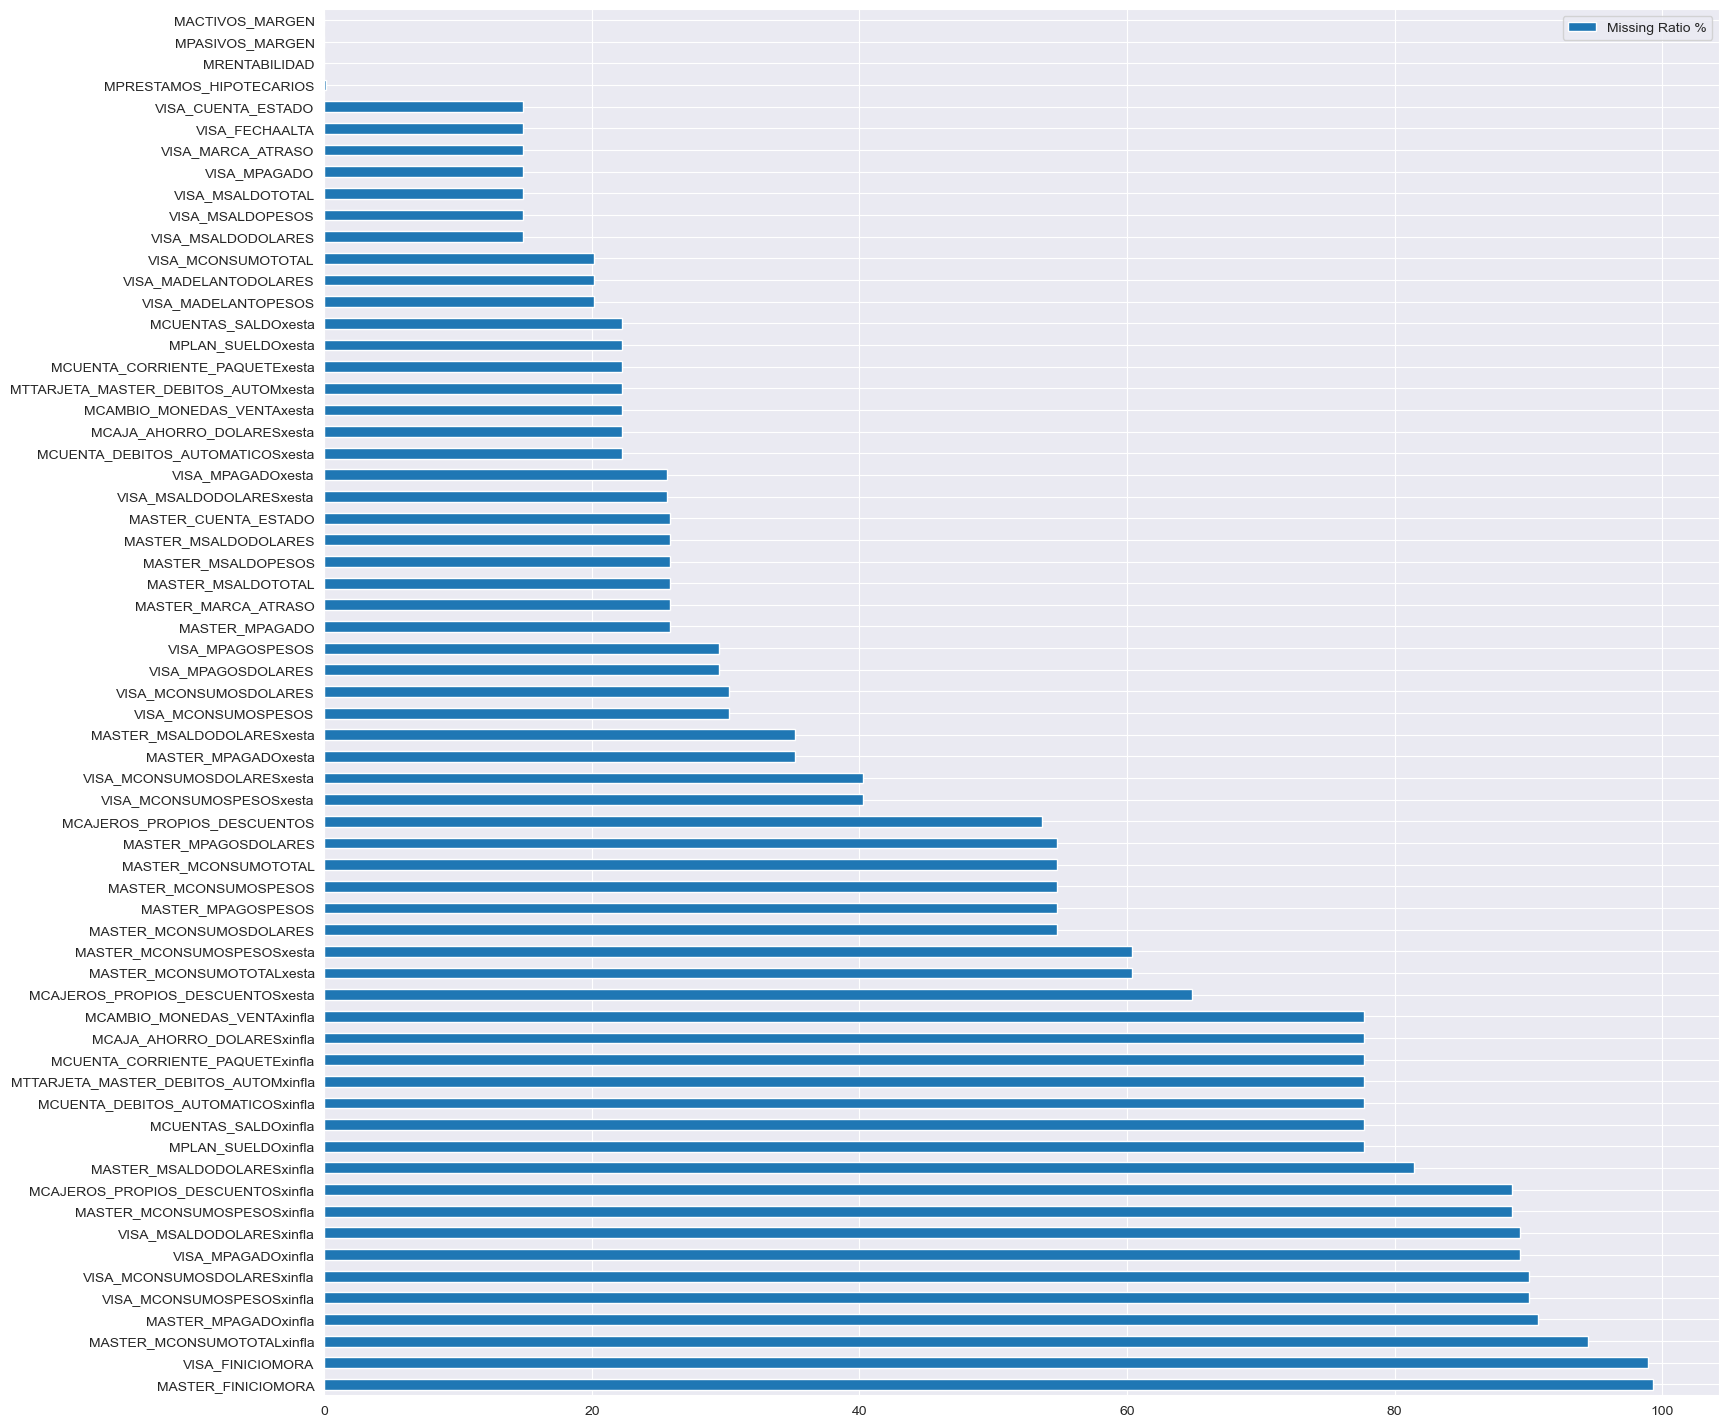

In [1212]:
import matplotlib.pyplot as plt

plot_width, plot_height = (18,18)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)

def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
        
        
plot_nas(df)

## Análisis de valores nulo por tipos de variables

In [1213]:
filter_col_null.intersection(filter_col_cliente)

Index([], dtype='object')

In [1214]:
filter_col_null.intersection(filter_col_marketing)

Index([], dtype='object')

In [1215]:
filter_col_null.intersection(filter_col_cantidad)

Index([], dtype='object')

In [1216]:
filter_col_null.intersection(filter_col_servicios)

Index([], dtype='object')

In [1217]:
print(filter_col_null.intersection(filter_col_montos))
print(len(filter_col_null.intersection(filter_col_montos)))

Index(['MACTIVOS_MARGEN', 'MCAJA_AHORRO_DOLARESxesta',
       'MCAJA_AHORRO_DOLARESxinfla', 'MCAJEROS_PROPIOS_DESCUENTOS',
       'MCAJEROS_PROPIOS_DESCUENTOSxesta', 'MCAJEROS_PROPIOS_DESCUENTOSxinfla',
       'MCAMBIO_MONEDAS_VENTAxesta', 'MCAMBIO_MONEDAS_VENTAxinfla',
       'MCUENTA_CORRIENTE_PAQUETExesta', 'MCUENTA_CORRIENTE_PAQUETExinfla',
       'MCUENTA_DEBITOS_AUTOMATICOSxesta', 'MCUENTA_DEBITOS_AUTOMATICOSxinfla',
       'MCUENTAS_SALDOxesta', 'MCUENTAS_SALDOxinfla', 'MPASIVOS_MARGEN',
       'MPLAN_SUELDOxesta', 'MPLAN_SUELDOxinfla', 'MPRESTAMOS_HIPOTECARIOS',
       'MRENTABILIDAD'],
      dtype='object')
19


In [1218]:
print(filter_col_null.intersection(filter_col_visa))
print(len(filter_col_null.intersection(filter_col_visa)))

Index(['VISA_CUENTA_ESTADO', 'VISA_FECHAALTA', 'VISA_FINICIOMORA',
       'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS', 'VISA_MARCA_ATRASO',
       'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSDOLARESxesta',
       'VISA_MCONSUMOSDOLARESxinfla', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOSPESOSxesta', 'VISA_MCONSUMOSPESOSxinfla',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGADOxesta',
       'VISA_MPAGADOxinfla', 'VISA_MPAGOSDOLARES', 'VISA_MPAGOSPESOS',
       'VISA_MSALDODOLARES', 'VISA_MSALDODOLARESxesta',
       'VISA_MSALDODOLARESxinfla', 'VISA_MSALDOPESOS', 'VISA_MSALDOTOTAL'],
      dtype='object')
23


In [1219]:
print(filter_col_null.intersection(filter_col_master))
print(len(filter_col_null.intersection(filter_col_master)))

Index(['MASTER_CUENTA_ESTADO', 'MASTER_FINICIOMORA', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOSPESOSxesta', 'MASTER_MCONSUMOSPESOSxinfla',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MCONSUMOTOTALxesta',
       'MASTER_MCONSUMOTOTALxinfla', 'MASTER_MPAGADO', 'MASTER_MPAGADOxesta',
       'MASTER_MPAGADOxinfla', 'MASTER_MPAGOSDOLARES', 'MASTER_MPAGOSPESOS',
       'MASTER_MSALDODOLARES', 'MASTER_MSALDODOLARESxesta',
       'MASTER_MSALDODOLARESxinfla', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MTTARJETA_MASTER_DEBITOS_AUTOMxesta',
       'MTTARJETA_MASTER_DEBITOS_AUTOMxinfla'],
      dtype='object')
22


Como se observa, aquellas variables con valores nulos están asociadas a:

1) Adhesión a tarjetas de crédito (Visa o Master), donde se constata la misma cantidad de variables con nulos para ambas tarjetas (la diferencia de una variable tiene que ver con que no se cuenta con la fecha de alta para las tarjetas MasterCard del cliente)

2) Los montos de rentabilidad que el banco ha obtenido del cliente (MACTIVOS_MARGEN, MPASIVOS_MARGEN, MRENTABILIDAD)

3) Los montos en el caso de que el cliente cuente o haya utilizado un servicio específico (por ejemplo, deudas por tener un préstamo hipotecario)

4) Variables construidas a posteriori para desestacionalizar o ajustar los montos por inflación. Aquí debajo se ve, por ejemplo, un la comparación entre las variables con y sin correcciónde los montos de CUENTAS_SALDO.

In [1220]:
df[['MCUENTAS_SALDO', 'MCUENTAS_SALDOxinfla']]

MCUENTAS_SALDO MCUENTAS_SALDOxinfla
0                  449                  NaN
1                 -567                  NaN
2                10087                  NaN
3                 7514                  NaN
4                 1302                  NaN
...                ...                  ...
140610            4096                  NaN
140611           28937                  NaN
140612            4047     2380.58823529412
140613           14260                  NaN
140614            2154                  NaN

[137385 rows x 2 columns]

Al analizar la relación entre estas dos variables para los casos nulos vemos que se ha aplicado un corrector de inflación distinto en las observaciones, por lo que podemos presumir que se trata de información de distintos períodos.

In [1221]:
(df.loc[df['MCUENTAS_SALDOxinfla'].notnull()]['MCUENTAS_SALDO'].astype(float) / df.loc[df['MCUENTAS_SALDOxinfla'].notnull()]['MCUENTAS_SALDOxinfla'].astype(float))

8         2.9
14        1.7
25        2.9
28        2.9
30        1.7
         ... 
140592    1.7
140593    1.7
140608    1.7
140609    2.9
140612    1.7
Length: 30622, dtype: float64

# Transform

## Trabajo sobre valores nulos

 En primer lugar, como no se cuenta con la información sobre el snapshot de la base, y debido a que el corrector de inflación varía según observación, se descartaran las variables construidas para corregir inflación y desestacionalziación, ya que no puede replicarse la metodología utilizada. Esto sin lugar a dudas reduce información que sería de mucha importancia para predecir el Churn Rate.

In [1222]:
filter_col_infla  =  [col for col in df if 'xinfla' in col]
filter_col_esta =  [col for col in df if 'xesta' in col]

In [1223]:
filter_col_esta

['MASTER_MCONSUMOSPESOSxesta',
 'MASTER_MCONSUMOTOTALxesta',
 'MASTER_MPAGADOxesta',
 'MASTER_MSALDODOLARESxesta',
 'MCAJA_AHORRO_DOLARESxesta',
 'MCAJEROS_PROPIOS_DESCUENTOSxesta',
 'MCAMBIO_MONEDAS_VENTAxesta',
 'MCUENTA_CORRIENTE_PAQUETExesta',
 'MCUENTA_DEBITOS_AUTOMATICOSxesta',
 'MCUENTAS_SALDOxesta',
 'MPLAN_SUELDOxesta',
 'MTTARJETA_MASTER_DEBITOS_AUTOMxesta',
 'VISA_MCONSUMOSDOLARESxesta',
 'VISA_MCONSUMOSPESOSxesta',
 'VISA_MPAGADOxesta',
 'VISA_MSALDODOLARESxesta']

In [1224]:
df = df.drop(filter_col_infla, axis = 1).drop(filter_col_esta, axis = 1)

En segundo lugar, con el mismo criterio utilizado previamente, se eliminan las columnas relacionadas con información de fechas: VISA_FECHA_ALTA, VISA_FINICIOMORA, MASTER_FINICIOMORA

In [1225]:
df = df.drop(['VISA_FECHAALTA', 'VISA_FINICIOMORA', 'MASTER_FINICIOMORA'], axis = 1)

En tercer lugar, se realiza un mapping de la variable _CUENTA_ESTADO_ de las tarjetas según las codificaciones del diccionario de datos y se crea el valor "sin datos" para las observaciones nulas:

In [1226]:
estado_tarjeta_mapper = {'10':'normal', '11':'con_problemas', '12':'con_problemas', '19':'cuenta_cerrada', np.nan:'sin_datos'}


In [1227]:
df['VISA_CUENTA_ESTADO'] = df['VISA_CUENTA_ESTADO'].map(estado_tarjeta_mapper)
df['MASTER_CUENTA_ESTADO'] = df['MASTER_CUENTA_ESTADO'].map(estado_tarjeta_mapper)

Se analizará la frecuencia absoluta del comportamiento de aquellas variables sin dato en relación a la variable de montos pagados. Como criterio, se considera que si dicha variable cuenta con un valor no nulo refiere a que el cliente cuenta con dicha tarjeta.

In [1228]:
df['VISA_CUENTA_ESTADO'].value_counts()

normal            116569
sin_datos          20364
con_problemas        339
cuenta_cerrada       113
Name: VISA_CUENTA_ESTADO, dtype: int64

In [1229]:
df['MASTER_CUENTA_ESTADO'].value_counts()

normal            101532
sin_datos          35518
con_problemas        239
cuenta_cerrada        96
Name: MASTER_CUENTA_ESTADO, dtype: int64

In [1230]:
df['MASTER_MPAGADO'].isnull().sum()

35518

In [1231]:
df['VISA_MPAGADO'].isnull().sum()

20364

Como se observa, los casos donde el monto pagado es nulo corresponde directamente con la cantidad de casos donde el estado de la cuenta es sin dato, por lo que podemos inferir que se trata de clientes que no poseen la tarjeta. De esta forma, se reetiqueta la variable de "sin_datos" por "no_posee_tarjeta" y se crea una nueva variable booleana para indicar si tuvo o tiene la misma o no. Por último, se imputa el valor 0 a las variables dependientes de la tarjeta donde el cliente no cuenta con la misma.

In [1232]:
df[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']] = df[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']].replace({'sin_datos':'no_posee_tarjeta'})

In [1233]:
df.loc[df['MASTER_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_master'] = False
df.loc[df['VISA_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_visa'] = False
df[['tiene_visa', 'tiene_master']] = df[['tiene_visa', 'tiene_master']].fillna(True)

In [1235]:
df['tiene_visa'].value_counts()

True     117021
False     20364
Name: tiene_visa, dtype: int64

In [1236]:
visa_cols = [col for col in df if 'VISA' in col]
master_cols = [col for col in df if 'MASTER' in col]
df[visa_cols] = df[visa_cols].fillna(0)
df[master_cols] = df[master_cols].fillna(0)

Analizamos nuevamente los casos nulos restantes en el DF

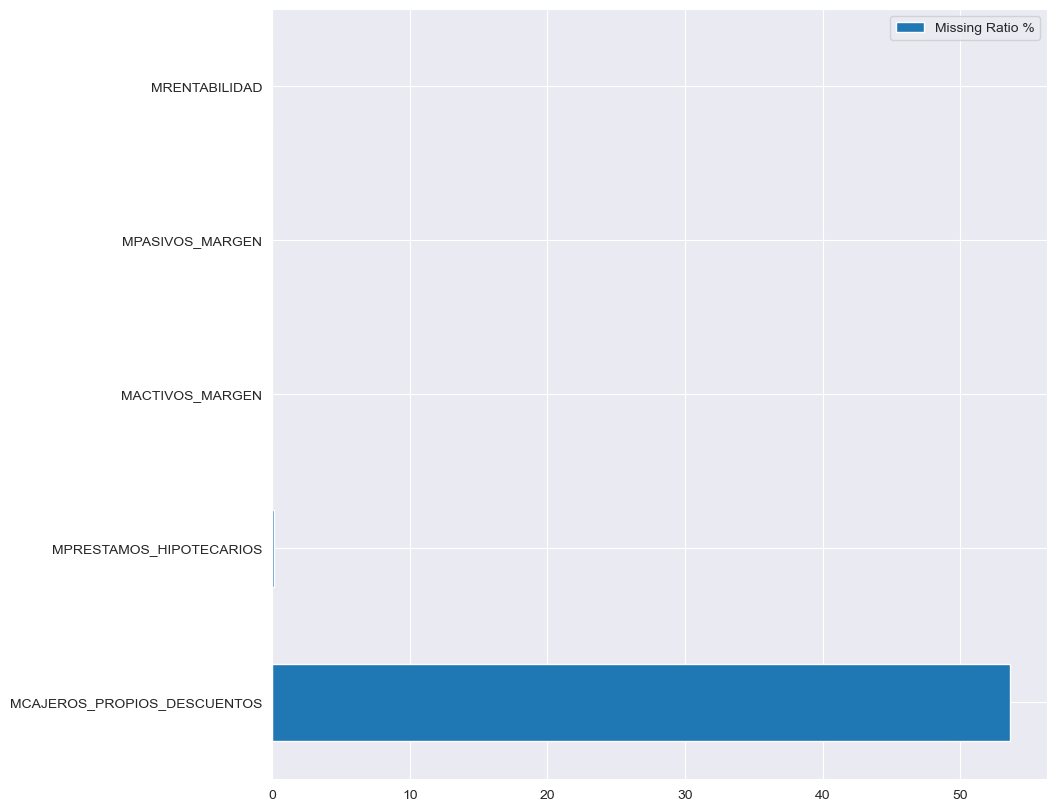

In [1237]:
import matplotlib.pyplot as plt

plot_width, plot_height = (10,10)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)

def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
        
        
plot_nas(df)

Como se observa, restan ya pocas variables con datos nulos, donde destaca en primer plano el atributo sobre bonificaciones por utilización de cajeros del banco. En segunda instancia, aparece el campo de deuda por prestamos hipotecarios. En tercer lugar, las variables sobre rentabilidad del banco sobre el cliente.

De este conjunto, llama la atención que hayan observaciones con datos faltantes para información valiosa para el negocio, por lo que se estima que se trata de errores en los datos, sobre todo dada la bajisima cantidad de observaciones, y que las mismas comparten faltantes para los mismos atributos. Por tal motivo, se determina eliminarlas.

In [1238]:
df['MRENTABILIDAD'].isnull().sum()

7

In [1239]:
df['MPASIVOS_MARGEN'].isnull().sum()

7

In [1240]:
df['MACTIVOS_MARGEN'].isnull().sum()

7

In [1241]:
df = df[df['MRENTABILIDAD'].notnull()]

Se analiza a continuación el comportamiento de los clientes con préstamos hipotecario, para definir qué valor imputar en aquellos casos donde se ha encontrado que CPRESTAMOS_HIPOTECARIOS es distinto a 0 pero el monto es nulo. Debido a que las columnas están en formato object, se convierten a int y se imputa temporariamente el valor -1 a los casos nulos en la variable monto.

In [1242]:
df['MPRESTAMOS_HIPOTECARIOS'] = df['MPRESTAMOS_HIPOTECARIOS'].fillna(-1).astype(int)

In [1243]:
df['CPRESTAMOS_HIPOTECARIOS'] = df['CPRESTAMOS_HIPOTECARIOS'].astype(np.int8)

In [1244]:

plt.boxplot(df.loc[df['CPRESTAMOS_HIPOTECARIOS'] != 0]['MPRESTAMOS_HIPOTECARIOS']) 

{'whiskers': [<matplotlib.lines.Line2D at 0x1f4aa32b8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f4aa32b550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f4aa32ba00>],
 'medians': [<matplotlib.lines.Line2D at 0x1f4b244f5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f4b244f4c0>],
 'means': []}

Como se ve, existe mucha dispersión en los datos y montos en 0 para casos de personas que cuentan con prestamo pero no adeudan. Se crean diez deciles para ver los cortes según monto adeudado y analizar el decil inferior.

In [1245]:
pd.qcut(df.loc[(df['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  (df['MPRESTAMOS_HIPOTECARIOS'] != 0)]['MPRESTAMOS_HIPOTECARIOS'], q = 10).value_counts()

(136284.2, 183772.0]     766
(-1.001, 13895.5]        765
(13895.5, 30705.4]       765
(30705.4, 43853.6]       765
(43853.6, 58589.8]       765
(58589.8, 74433.5]       765
(74433.5, 90548.4]       765
(90548.4, 110117.6]      765
(110117.6, 136284.2]     765
(183772.0, 1120481.0]    764
Name: MPRESTAMOS_HIPOTECARIOS, dtype: int64

In [1246]:
df[(df['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  (df['MPRESTAMOS_HIPOTECARIOS'] <13895.5)]['MPRESTAMOS_HIPOTECARIOS'].hist(figsize = (3,3))

<AxesSubplot: >

Como se observa, de las 765 observaciones del decil inferior para aquellas personas que cuentan con credito, unas 202 se trata de observaciones con valores nulos y 17 con montos de deuda iguales a 0. Debido a que nuestro dataset se encuentra desbalanceado en la clase a predecir, analizamos el comportamiento de esta antes de definir las imputaciones.

In [1247]:
df[(df['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  (df['MPRESTAMOS_HIPOTECARIOS'] == -1)]['CLASECORR'].value_counts()

CONTINUA    201
BAJA+1        1
Name: CLASECORR, dtype: int64

In [1248]:
### Agregar análisis de correlación entre dependiente y monto de prestamo

Se toma la definición de eliminar dichas observaciones, ya que sólo se pierde un caso relacionado a las bajas en la clase dependiente.

In [1249]:
df = df[df['MPRESTAMOS_HIPOTECARIOS'] != -1]

In [1250]:
df.loc[(df['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  ((df['MPRESTAMOS_HIPOTECARIOS'] == 0) )]['CLASECORR'].value_counts()

CONTINUA    12
BAJA+2       3
BAJA+1       2
Name: CLASECORR, dtype: int64

Llama la atención los clientes etiquetados como poseedores de al menos un crédito hipotecario que no registran montos de deuda. Es posible que se deba a que no se ha actualizado la variable en el sistema, por lo que se procede a relizar la transformación y cambiar el estado de cantidad (CPRESTAMOS_HIPOTECARIOS = 0) en aquellos casos donde el MPRESTAMOS_HIPOTECARIOS == 0.

In [1251]:
df.loc[(df['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  ((df['MPRESTAMOS_HIPOTECARIOS'] == 0)), 'CPRESTAMOS_HIPOTECARIOS'] = 0

Por último, debido a que no se cuenta con una variable que por sí misma tenga información sobre si el cliente cuenta o no con prestamo hipotecario, se conforma la misma:

In [1252]:
df.loc[df['CPRESTAMOS_HIPOTECARIOS'] != 0, 'TPRESTAMOS_HIPOTECARIOS'] = True
df['TPRESTAMOS_HIPOTECARIOS'] = df['TPRESTAMOS_HIPOTECARIOS'].fillna(False)

In [1253]:
df['TPRESTAMOS_HIPOTECARIOS'].value_counts()

False    129728
True       7448
Name: TPRESTAMOS_HIPOTECARIOS, dtype: int64

Por último, analizamos la variable restante que quedaba con mayor incidencia de nulos correspondiente al monto de beneficio que el cliente tuvo por utilizar cajeros del banco. En principio, se analiza la distribución de la variable dependiente:

In [1254]:
df[df['MCAJEROS_PROPIOS_DESCUENTOS'].isnull()]['CLASECORR'].value_counts()

CONTINUA    56049
BAJA+2       8772
BAJA+1       8752
Name: CLASECORR, dtype: int64

A diferencia del caso anterior, existe una mayor frecuencia absoluta de la variable a predecir entre las observaciones con valores nulos de monto. Comparamos de forma similar a como se hizo con el caso de los préstamos, la variable de cantidad de beneficio entre aquellos que cuentan con montos nulos.

In [1255]:
### Agregar análisis de correlación entre dependiente y monto de beneficio por utilizar cajeros propios
### y cantidad de monto segun utilización de cajeros propios para ver si puede realizarse algun criterio de imputación
### según knn

In [1256]:
df[(df['MCAJEROS_PROPIOS_DESCUENTOS'].isnull()) &
  (df['CLASECORR'] != 'CONTINUA')]['CCAJEROS_PROPIOS_DESCUENTOS'].value_counts()

0     5044
1     3503
2     2491
3     1870
4     1427
5     1041
6      680
7      474
8      316
9      229
10     154
11     103
12      65
13      36
14      22
15      21
18      10
16       9
17       6
19       6
20       4
21       4
26       3
23       1
25       1
36       1
39       1
22       1
37       1
Name: CCAJEROS_PROPIOS_DESCUENTOS, dtype: int64

Finalmente, se decide eliminar la variable de monto de beneficio por utilización de cajeros propios, quedandonos con la variable sólo de cantidad de usufructo del beneficio.

In [1257]:
df = df.drop(['MCAJEROS_PROPIOS_DESCUENTOS'], axis = 1)

## Normalización de las variables

In [1258]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137176 entries, 0 to 140614
Data columns (total 146 columns):
 #    Column                          Non-Null Count   Dtype 
---   ------                          --------------   ----- 
 0    CAUTOSERVICIO_TRANSACCIONES     137176 non-null  int64 
 1    CCAJEROS_AJENOS_TRANSACCIONES   137176 non-null  int64 
 2    CCAJEROS_PROPIO_TRANSACCIONES   137176 non-null  int64 
 3    CCAJEROS_PROPIOS_DESCUENTOS     137176 non-null  int64 
 4    CCALLCENTER_TRANSACCIONES       137176 non-null  int64 
 5    CCAMBIO_MONEDAS_COMPRA          137176 non-null  int64 
 6    CCAMBIO_MONEDAS_VENTA           137176 non-null  int64 
 7    CCHEQUES_DEPOSITADOS            137176 non-null  int64 
 8    CCHEQUES_DEPOSITADOS_RECHAZADO  137176 non-null  int64 
 9    CCHEQUES_EMITIDOS               137176 non-null  int64 
 10   CCHEQUES_EMITIDOS_RECHAZADOS    137176 non-null  int64 
 11   CCOMISIONES_MANTENIMIENTO       137176 non-null  int64 
 12   CCOMISIONES_OT

Aquellas variables que empiezan con "T" significa si el cliente tiene o utilizó determinado servicio. Las mismas se encuentran con valores categóricos donde "S" corresponde a que tiene el servicio y "N" al caso contrario. Se normalizan las mismas convirtiendolos a valores booleanos para una mejor manipulación de los datos.

In [1259]:
df = df.replace({'S':True, 'N':False})

Existen otras variables que también son dicotómicas en la base como CLIENTE_VIP, MASTER_MARCA_ATRASO, etc. Para poder identificarlas correctamente, debemos primero transformar los atributos a formato numérico, ya que en algunos casos se encuentran mezclados con formatos string. Por ejemplo:

In [1260]:
df['MASTER_MARCA_ATRASO'].value_counts()

0    100750
0     35472
1       954
Name: MASTER_MARCA_ATRASO, dtype: int64

Donde se pueda, a su vez, se realizará con los formatos integer o float lo más pequeños posibles debido a que agilizará el procesamiento en memoria.

In [1261]:
df.select_dtypes(include='object').columns

Index(['MACTIVOS_MARGEN', 'MASTER_CUENTA_ESTADO', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MPAGADO', 'MASTER_MPAGOSDOLARES',
       'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MPASIVOS_MARGEN', 'MRENTABILIDAD',
       'VISA_CUENTA_ESTADO', 'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS',
       'VISA_MARCA_ATRASO', 'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGOSDOLARES',
       'VISA_MPAGOSPESOS', 'VISA_MSALDODOLARES', 'VISA_MSALDOPESOS',
       'VISA_MSALDOTOTAL', 'ClaseBinaria', 'CLASECORR', 'ClaseNum'],
      dtype='object')

In [1262]:

df[['MACTIVOS_MARGEN', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MPAGADO', 'MASTER_MPAGOSDOLARES',
       'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MPASIVOS_MARGEN', 'MRENTABILIDAD',
       'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS',
       'VISA_MARCA_ATRASO', 'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGOSDOLARES',
       'VISA_MPAGOSPESOS', 'VISA_MSALDODOLARES', 'VISA_MSALDOPESOS',
       'VISA_MSALDOTOTAL']] = df[['MACTIVOS_MARGEN', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MPAGADO', 'MASTER_MPAGOSDOLARES',
       'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MPASIVOS_MARGEN', 'MRENTABILIDAD',
       'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS',
       'VISA_MARCA_ATRASO', 'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGOSDOLARES',
       'VISA_MPAGOSPESOS', 'VISA_MSALDODOLARES', 'VISA_MSALDOPESOS',
       'VISA_MSALDOTOTAL']].astype(float)

In [1263]:
df['CLIENTE_VIP'] = df['CLIENTE_VIP'].astype(bool)
df['MASTER_MARCA_ATRASO'] = df['MASTER_MARCA_ATRASO'].astype(bool)
df['VISA_MARCA_ATRASO'] = df['VISA_MARCA_ATRASO'].astype(bool)

In [1264]:
df[filter_col_cantidad].head()

CAUTOSERVICIO_TRANSACCIONES  CCAJEROS_AJENOS_TRANSACCIONES  \
0                            0                              0   
1                            0                              0   
2                            0                              1   
3                            0                              3   
4                            0                              0   

   CCAJEROS_PROPIO_TRANSACCIONES  CCAJEROS_PROPIOS_DESCUENTOS  \
0                              0                            0   
1                              0                            1   
2                              0                            0   
3                              3                            0   
4                              0                            1   

   CCALLCENTER_TRANSACCIONES  CCAMBIO_MONEDAS_COMPRA  CCAMBIO_MONEDAS_VENTA  \
0                          4                       0                      0   
1                          5                       0                      0   
2                          6                       1                      0   
3                          5                       1                      0   
4                          0                       0                      0   

   CCHEQUES_DEPOSITADOS  CCHEQUES_DEPOSITADOS_RECHAZADO  CCHEQUES_EMITIDOS  \
0                     0                               0                  0   
1                     0                               0                  0   
2                     0                               0                  0   
3                     0                               0                  0   
4                     0                               0                  0   

   ...  CCUENTA_DESCUENTOS  CEXTRACCION_AUTOSERVICIO  \
0  ...                   0                         0   
1  ...                   0                         0   
2  ...                   0                         1   
3  ...                   0                         6   
4  ...                   0                         0   

   CHOMEBANKING_TRANSACCIONES  CPLAN_SUELDO_TRANSACCION  \
0                          32                         0   
1                          23                         0   
2                          58                         0   
3                         123                         0   
4                           0                         0   

   CPRESTAMOS_HIPOTECARIOS  CPRESTAMOS_PERSONALES  CPRESTAMOS_PRENDARIOS  \
0                        0                      0                      0   
1                        0                      0                      0   
2                        0                      1                      0   
3                        0                      1                      0   
4                        0                      0                      0   

   CTARJETA_DEBITO_TRANSACCIONES  CTRANSFERENCIAS_EMITIDAS  \
0                              0                         0   
1                              2                         0   
2                              1                         0   
3                              0                         0   
4                              1                         0   

   CTRANSFERENCIAS_RECIBIDAS  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  

[5 rows x 23 columns]

In [1265]:
df[filter_col_cantidad] = df[filter_col_cantidad].astype(np.int8)

In [1266]:
df[filter_col_marketing].head()

MARKETING_ACTIVO_ULTIMOS90DIAS  MARKETING_COSS_SELLING
0                               1                      12
1                               1                      12
2                               1                      12
3                               1                      11
4                               1                      10

In [1267]:
df['MARKETING_ACTIVO_ULTIMOS90DIAS'].value_counts()

1    131881
0      5295
Name: MARKETING_ACTIVO_ULTIMOS90DIAS, dtype: int64

In [1268]:
df['MARKETING_COSS_SELLING'].value_counts()

9     30589
8     30482
10    22172
7     21330
11    12615
6      7495
12     6335
13     2694
5      1802
14      983
4       314
15      272
16       67
17       19
3         6
18        1
Name: MARKETING_COSS_SELLING, dtype: int64

In [1269]:
df['MARKETING_ACTIVO_ULTIMOS90DIAS'] = df['MARKETING_ACTIVO_ULTIMOS90DIAS'].astype(bool)
df['MARKETING_COSS_SELLING'] = df['MARKETING_COSS_SELLING'].astype(np.int8)

In [1270]:
df[filter_col_servicios].head()

TAUTOSERVICIO  TCAJA_AHORRO  TCAJA_SEGURIDAD  TCAJAS  TCAJAS_CONSULTAS  \
0          False          True             True    True              True   
1          False          True             True    True              True   
2          False          True             True    True              True   
3          False          True             True    True              True   
4          False          True            False    True             False   

   TCAJAS_DEPOSITOS  TCAJAS_EXTRACCIONES  TCAJAS_OTRAS  TCALLCENTER  \
0              True                False         False         True   
1              True                False         False         True   
2              True                False         False         True   
3              True                False         False         True   
4              True                False         False        False   

   TCAMBIO_MONEDAS  ...  TPAGOMISCUENTAS  TPAQUETE_PREMIUM  TPLAN_SUELDO  \
0            False  ...            False              True         False   
1            False  ...            False              True         False   
2             True  ...             True              True          True   
3             True  ...             True              True          True   
4            False  ...            False              True         False   

   TPLAZO_FIJO  TSEGURO_ACCIDENTES_PERSONALES  TSEGURO_AUTO  \
0        False                           True          True   
1        False                           True          True   
2        False                          False         False   
3        False                          False         False   
4        False                           True         False   

   TSEGURO_VIDA_MERCADO_ABIERTO  TSEGURO_VIVIENDA  TTARJETA_DEBITO  TTITULOS  
0                         False              True             True     False  
1                         False              True             True     False  
2                         False             False             True      True  
3                         False             False             True      True  
4                         False             False             True     False  

[5 rows x 27 columns]

In [1271]:
#transformación de variables dependientes

df[['ClaseBinaria', 'ClaseNum']] = df[['ClaseBinaria', 'ClaseNum']].astype(np.int8)

Por último, existe una variable que si bien aparece numérica es categórica, ya que corresponde a los ID de la sucursal del cliente.

In [1272]:
len(df['CLIENTE_SUCURSAL'].astype(str).value_counts())

264

En principio para evitar la confusión se hace un mapeo para convertirla a formato string. Lo ideal sería poder en segundo lugar realizar la construcción de variables dummys con la misma, pero debido a la gran variabilidad puede llegar a traer un problema de dimensionalidad. Se analizará a posteriori.

In [1273]:
df['CLIENTE_SUCURSAL'] = df['CLIENTE_SUCURSAL'].astype(str).apply(lambda x: 'sucursal_'+x)

In [1274]:
df = df.drop(['TTARJETA_VISA', 'TTARJETA_MASTER'], axis = 1) #se eliminan estas dos variables ya que no queda claro si hacen referencia a tarjeta de débito o crédito

In [1275]:
#constatamos que las únicas variables categóricas sean las previstas

df.select_dtypes(include='object').columns 

Index(['CLIENTE_SUCURSAL', 'MASTER_CUENTA_ESTADO', 'VISA_CUENTA_ESTADO',
       'CLASECORR'],
      dtype='object')

In [1276]:
df['CLASECORR'] = df['CLASECORR'].replace({'CONTINUA':'continua',
                       'BAJA+1':'baja_1_mes',
                       'BAJA+2':'baja_2_mes'})

In [1277]:
df.columns = df.columns.str.lower()

In [1278]:
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

Se utiliza la función precedente para analizar variables que tengan el mismo valor para todas las ocurrencias con el fin de eliminarlas del DF.

In [1279]:
unique_cols(df)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [1280]:
df.loc[:,unique_cols(df)]

ccuenta_descuentos  mbonos_corporativos  mbonos_gobierno  \
0                        0                    0                0   
1                        0                    0                0   
2                        0                    0                0   
3                        0                    0                0   
4                        0                    0                0   
...                    ...                  ...              ...   
140610                   0                    0                0   
140611                   0                    0                0   
140612                   0                    0                0   
140613                   0                    0                0   
140614                   0                    0                0   

        mcuenta_corriente_dolares  mcuenta_descuentos  minversiones_otras  \
0                               0                   0                   0   
1                               0                   0                   0   
2                               0                   0                   0   
3                               0                   0                   0   
4                               0                   0                   0   
...                           ...                 ...                 ...   
140610                          0                   0                   0   
140611                          0                   0                   0   
140612                          0                   0                   0   
140613                          0                   0                   0   
140614                          0                   0                   0   

        mmonedas_extranjeras  tcuentas  tpaquete_premium  
0                          0      True              True  
1                          0      True              True  
2                          0      True              True  
3                          0      True              True  
4                          0      True              True  
...                      ...       ...               ...  
140610                     0      True              True  
140611                     0      True              True  
140612                     0      True              True  
140613                     0      True              True  
140614                     0      True              True  

[137176 rows x 9 columns]

 Se eliminan estas columnas del DF final ya que no aportan información (por ejemplo, ya se sabe que todas las observaciones tienen paquetes premium o cuenta en el banco)

In [1281]:
df = df.drop(df.loc[:,unique_cols(df)].columns, axis = 1)

In [1282]:
df =pd.concat([df, pd.get_dummies(df['master_cuenta_estado'], prefix = 'master', dtype = 'bool')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['visa_cuenta_estado'], prefix = 'visa', dtype = 'bool')], axis = 1)
                
#Antes de pasar la información al modelo se hará un drop de las dummies para no redundar

In [1283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137176 entries, 0 to 140614
Columns: 143 entries, cautoservicio_transacciones to visa_normal
dtypes: bool(46), float64(23), int32(1), int64(44), int8(25), object(4)
memory usage: 85.2+ MB


In [1284]:
df[df.select_dtypes('int64').columns] =  df.select_dtypes('int64').astype(np.int32)

In [1285]:
df[df.select_dtypes('float64').columns] =  df.select_dtypes('float64').astype(np.int32)

# Loading

In [1286]:
df_final = df

del df

In [1287]:
df_final = df_final.drop(['master_cuenta_estado', 'visa_cuenta_estado', 'cliente_sucursal', 'clasecorr'], axis = 1)

In [1288]:
df_final.sample(5)

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
68312                             2                              0   
106050                            0                              8   
56357                             0                              0   
103543                            0                              0   
40306                             2                              1   

        ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
68312                               0                            0   
106050                              0                            0   
56357                               0                            0   
103543                              0                            0   
40306                               0                            3   

        ccallcenter_transacciones  ccambio_monedas_compra  \
68312                           0                       0   
106050                         25                       0   
56357                           0                       0   
103543                          0                       0   
40306                           0                       0   

        ccambio_monedas_venta  ccheques_depositados  \
68312                       0                     0   
106050                      0                     0   
56357                       1                     1   
103543                      0                     0   
40306                       0                     0   

        ccheques_depositados_rechazado  ccheques_emitidos  ...  tiene_visa  \
68312                                0                  0  ...        True   
106050                               0                  0  ...        True   
56357                                0                  0  ...        True   
103543                               0                  0  ...        True   
40306                                0                  0  ...        True   

        tprestamos_hipotecarios  master_con_problemas  master_cuenta_cerrada  \
68312                     False                 False                  False   
106050                    False                 False                  False   
56357                     False                 False                  False   
103543                    False                 False                  False   
40306                      True                 False                  False   

        master_no_posee_tarjeta  master_normal  visa_con_problemas  \
68312                     False           True               False   
106050                    False           True               False   
56357                      True          False               False   
103543                     True          False               False   
40306                     False           True               False   

        visa_cuenta_cerrada  visa_no_posee_tarjeta  visa_normal  
68312                 False                  False         True  
106050                False                  False         True  
56357                 False                  False         True  
103543                False                  False         True  
40306                 False                  False         True  

[5 rows x 139 columns]

**Distribución de la clase según ordenamiento binario y por categoría**

In [1289]:
df_final.groupby(['clasebinaria']).size().reset_index().rename({0:'total'},
                                                           axis = 1)

clasebinaria   total
0             0  106456
1             1   30720

In [1290]:
y['clasebinaria'].value_counts(normalize = True)

0    0.776054
1    0.223946
Name: clasebinaria, dtype: float64

In [1291]:
y = df_final[['clasebinaria', 'clasenum']]
y

clasebinaria  clasenum
0                  0         1
1                  0         1
2                  0         1
3                  0         1
4                  0         1
...              ...       ...
140610             1         2
140611             1         3
140612             0         1
140613             0         1
140614             0         1

[137176 rows x 2 columns]

In [1292]:
df_col_booleanas = df_final.select_dtypes('bool')

In [1293]:
df_col_booleanas

cliente_vip  marketing_activo_ultimos90dias  master_marca_atraso  \
0             False                            True                False   
1             False                            True                False   
2             False                            True                False   
3             False                            True                False   
4             False                            True                False   
...             ...                             ...                  ...   
140610        False                            True                False   
140611        False                            True                False   
140612        False                            True                False   
140613        False                            True                False   
140614        False                            True                False   

        master_tadelantosefectivo  master_tconsumos  tautoservicio  \
0                           False             False          False   
1                           False              True          False   
2                           False              True          False   
3                           False              True          False   
4                           False              True          False   
...                           ...               ...            ...   
140610                       True              True          False   
140611                       True              True          False   
140612                       True              True           True   
140613                       True              True           True   
140614                       True              True           True   

        tcaja_ahorro  tcaja_seguridad  tcajas  tcajas_consultas  ...  \
0               True             True    True              True  ...   
1               True             True    True              True  ...   
2               True             True    True              True  ...   
3               True             True    True              True  ...   
4               True            False    True             False  ...   
...              ...              ...     ...               ...  ...   
140610          True             True   False             False  ...   
140611          True            False   False             False  ...   
140612          True            False    True              True  ...   
140613          True            False    True              True  ...   
140614          True            False    True              True  ...   

        tiene_visa  tprestamos_hipotecarios  master_con_problemas  \
0             True                    False                 False   
1             True                    False                 False   
2             True                    False                 False   
3             True                    False                 False   
4             True                    False                 False   
...            ...                      ...                   ...   
140610        True                    False                 False   
140611       False                    False                 False   
140612        True                    False                 False   
140613        True                    False                 False   
140614        True                    False                 False   

        master_cuenta_cerrada  master_no_posee_tarjeta  master_normal  \
0                       False                    False           True   
1                       False                    False           True   
2                       False                    False           True   
3                       False                    False           True   
4                       False                    False           True   
...                       ...                      ...            ...   
140610                  False                    

In [1294]:
df_no_booleanas = df_final.drop(df_col_booleanas.columns, axis = 1).drop(y.columns, axis = 1)

In [1295]:
df_2 = pd.concat([df_no_booleanas,df_col_booleanas,y], axis = 1)

In [1296]:
df_2 = df_2.drop(['clasenum'], axis =1 )

# EDA

### Variables Dicotómicas

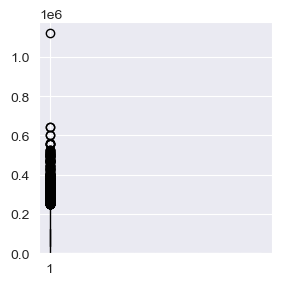

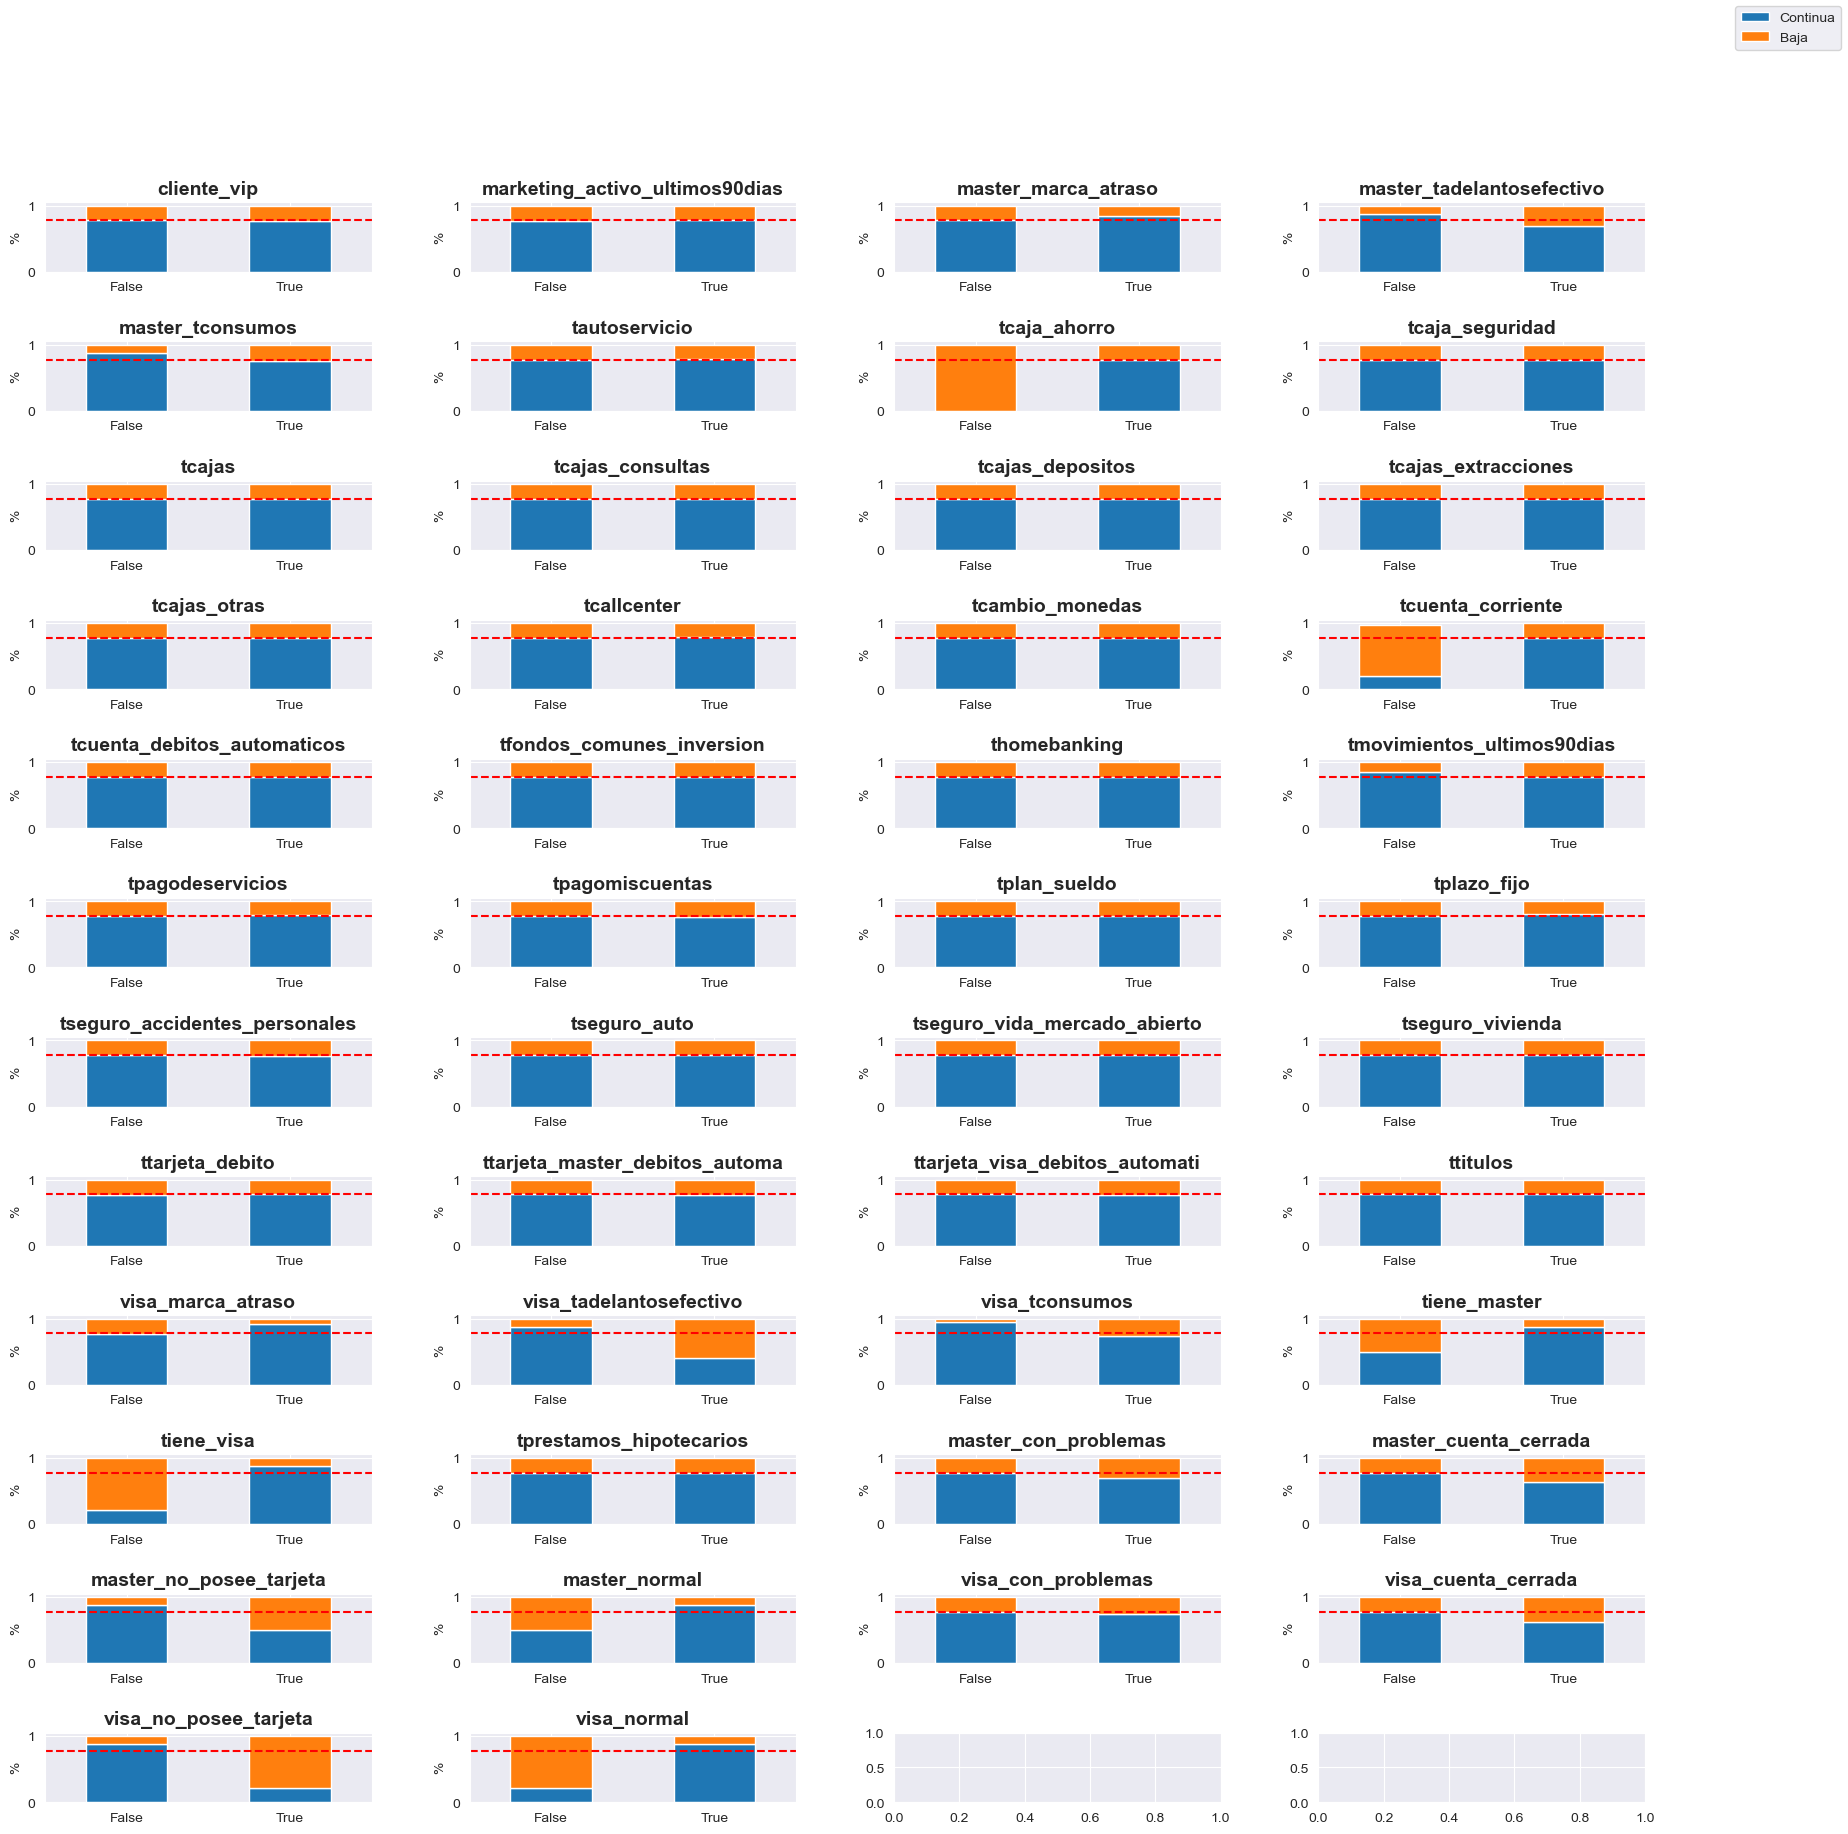

In [1297]:
sns.set_style("darkgrid")

n_vars = len(df_col_booleanas.columns)
ncols = 4
nrows = (n_vars + ncols - 1) // ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

for i, var in enumerate(df_col_booleanas):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    binaria_grouped = df_2.groupby([var, 'clasebinaria']).size().reset_index(name='counts')
    binaria_grouped = binaria_grouped.pivot(index=var, columns='clasebinaria', values='counts')
    binaria_grouped['Continua'] = binaria_grouped[0] / binaria_grouped.sum(axis=1)
    binaria_grouped['Baja'] = binaria_grouped[1] / binaria_grouped.sum(axis=1)
    binaria_grouped[['Continua', 'Baja']].plot.bar(stacked=True, ax=ax, legend = False)
    ax.set_xlabel(None)
    ax.set_ylabel('%')
    ax.set_title(f"{var}", fontweight='bold', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.axhline(y=0.776, color='red', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=1)

# Agregar la leyenda fuera de los gráficos
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

El gráfico anterior expresa la distribución de nuestra variable dependiente en el resto de las variables dicotómicas de nuestro dataset. Se colocó una línea en el valor 0.776 (que sería el valor de "no baja" en todo el data set) para facilitar la visualización.

En ese sentido, podemos ver que en para algunas variables el comportamiento de la dependiente sale de las frecuencias relativas del resto del dataset.

Entre aquellos que no cuentan con Caja de Ahorro (tcaja_deahorro) y/o Cuenta Corriente (tcuenta_corriente), pareciera que los casos de baja son mayores.

Por otro lado, analizando la tenencia de tarjetas puede decirse que entre quienes no tienen VISA (tiene_visa/visa_no_posee_tarjeta) los casos de baja también superan la media. En una escala similar aunque menos acentuadamente se da para quienes no tienen tarjeta MasterCard (tiene_master/master_no_posee_tarjeta)

En función de esto, quizá sea buena idea conformar una variable para observar como se distribuye la dependiente entre quienes no cuentan con ninguna tarjeta, quienes cuentan con las dos, quienes cuentan sólo con Visa y quienes cuentan sólo con MasterCard. Realizaremos un mapeo y luego conformaremos las dummies para el análisis.

In [1298]:
df_2.loc[(df_2['tiene_master'] == True) & 
                     (df_2['tiene_visa'] == True), 'empresa_tarjeta_asociadas'] = 'ambas'

In [1299]:
df_2.loc[(df_2['tiene_master'] == True) & 
                     (df_2['tiene_visa'] == False), 'empresa_tarjeta_asociadas'] = 'master'

In [1300]:
df_2.loc[(df_2['tiene_master'] == False) & 
                     (df_2['tiene_visa'] == True), 'empresa_tarjeta_asociadas'] = 'visa'

In [1301]:
df_2.loc[(df_2['tiene_master'] == False) & 
                     (df_2['tiene_visa'] == False), 'empresa_tarjeta_asociadas'] = 'ninguna'

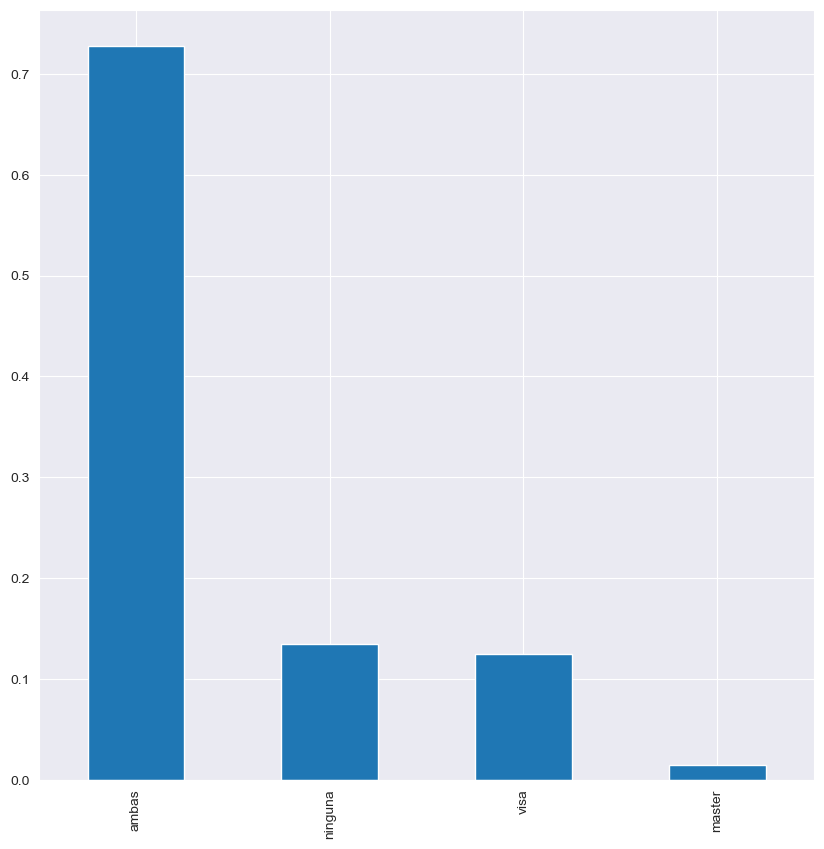

In [1302]:
df_2['empresa_tarjeta_asociadas'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

In [1303]:
tarjetas_asociadas = pd.pivot_table(df_2.groupby(['empresa_tarjeta_asociadas',
                          'clasebinaria']).size().reset_index(),
            index = 'empresa_tarjeta_asociadas',
            columns = 'clasebinaria',
            values = 0)
tarjetas_asociadas = tarjetas_asociadas.reset_index().rename_axis(None, axis=1).rename({0:'continua', 1:'baja'}, axis = 1)

In [1304]:
tarjetas_asociadas['continua_%'] =  tarjetas_asociadas.iloc[::,1]/( tarjetas_asociadas['continua'] + tarjetas_asociadas['baja'])
tarjetas_asociadas['baja_%'] = tarjetas_asociadas.iloc[::,2]/( tarjetas_asociadas['continua'] + tarjetas_asociadas['baja'])

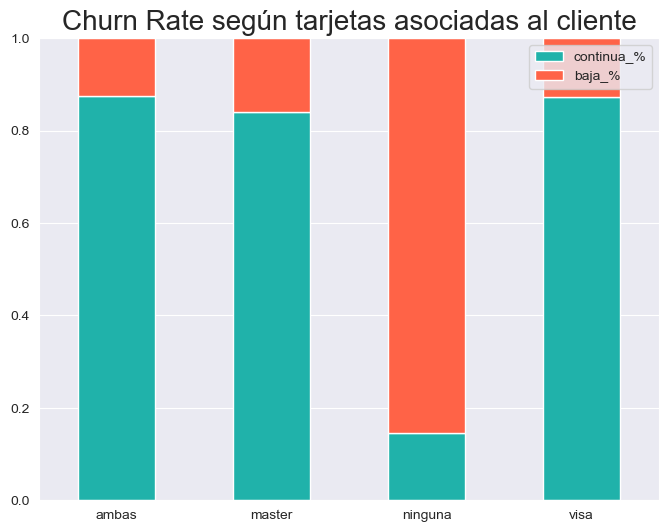

In [1305]:
ax = tarjetas_asociadas[['empresa_tarjeta_asociadas',
                    'continua_%',
                    'baja_%']].plot.bar(stacked=True, color =['lightseagreen', 'tomato'], figsize=(8,6))
ax.set_title('Churn Rate según tarjetas asociadas al cliente', fontsize=20)
ax.set_ylim(0,1)
ax.set_xticklabels(['ambas', 'master', 'ninguna', 'visa'], rotation=0)

plt.show()

In [1306]:
tarjetas_asociadas

empresa_tarjeta_asociadas  continua   baja  continua_%    baja_%
0                     ambas     87270  12498    0.874729  0.125271
1                    master      1625    311    0.839360  0.160640
2                   ninguna      2662  15752    0.144564  0.855436
3                      visa     14899   2159    0.873432  0.126568

Como puede observarse, la incidencia de bajas entre los clientes que no poseen ninguna tarjeta es no sólo alta en términos relativos sino, también, en términos absolutos: más de la mitad de los casos de baja de nuestro DF corresponde a clientes sin tarjetas. Revisando las variables iniciales, nos encontramos con que ningún atributo refleja esto, por lo que procedemos a crear una nueva variable ('ttarjeta') que refleje este estado.

In [1307]:
df_2.loc[df_2['empresa_tarjeta_asociadas']=='ninguna', 'ttarjeta'] = False
df_2['ttarjeta'].fillna(True, inplace = True)

In [1308]:
df_2['ttarjeta'].value_counts()

True     118762
False     18414
Name: ttarjeta, dtype: int64

In [1309]:
df_2.drop('ttarjeta', axis = 1, inplace = True)

Pese a que sería muy tentador, debida a la alta frecuencia, suponer una asociación directa entre la baja y la no tenencia de tarjeta es importante aclarar que, debido a que no se cuenta con información temporal, no podemos saber si la baja de la no tenencia de la tarjeta es una consecuencia de la baja y no una causa. De todas formas, realizaremos nuevas transformaciones en nuestro DF para quedarnos con estas variables y eliminaremos las redundantes.

In [1310]:
df_2 = pd.concat([df_2, pd.get_dummies(df_2['empresa_tarjeta_asociadas'], prefix = 'ttarjeta', dtype = 'bool')], axis = 1)

In [1311]:
df_2.drop(['empresa_tarjeta_asociadas',
           'tiene_visa',
           'tiene_master',
           'master_no_posee_tarjeta',
           'visa_no_posee_tarjeta',
           'visa_cuenta_cerrada',
           'master_cuenta_cerrada'], axis = 1, inplace = True)

In [1312]:
df_col_booleanas = df_2.select_dtypes('bool')

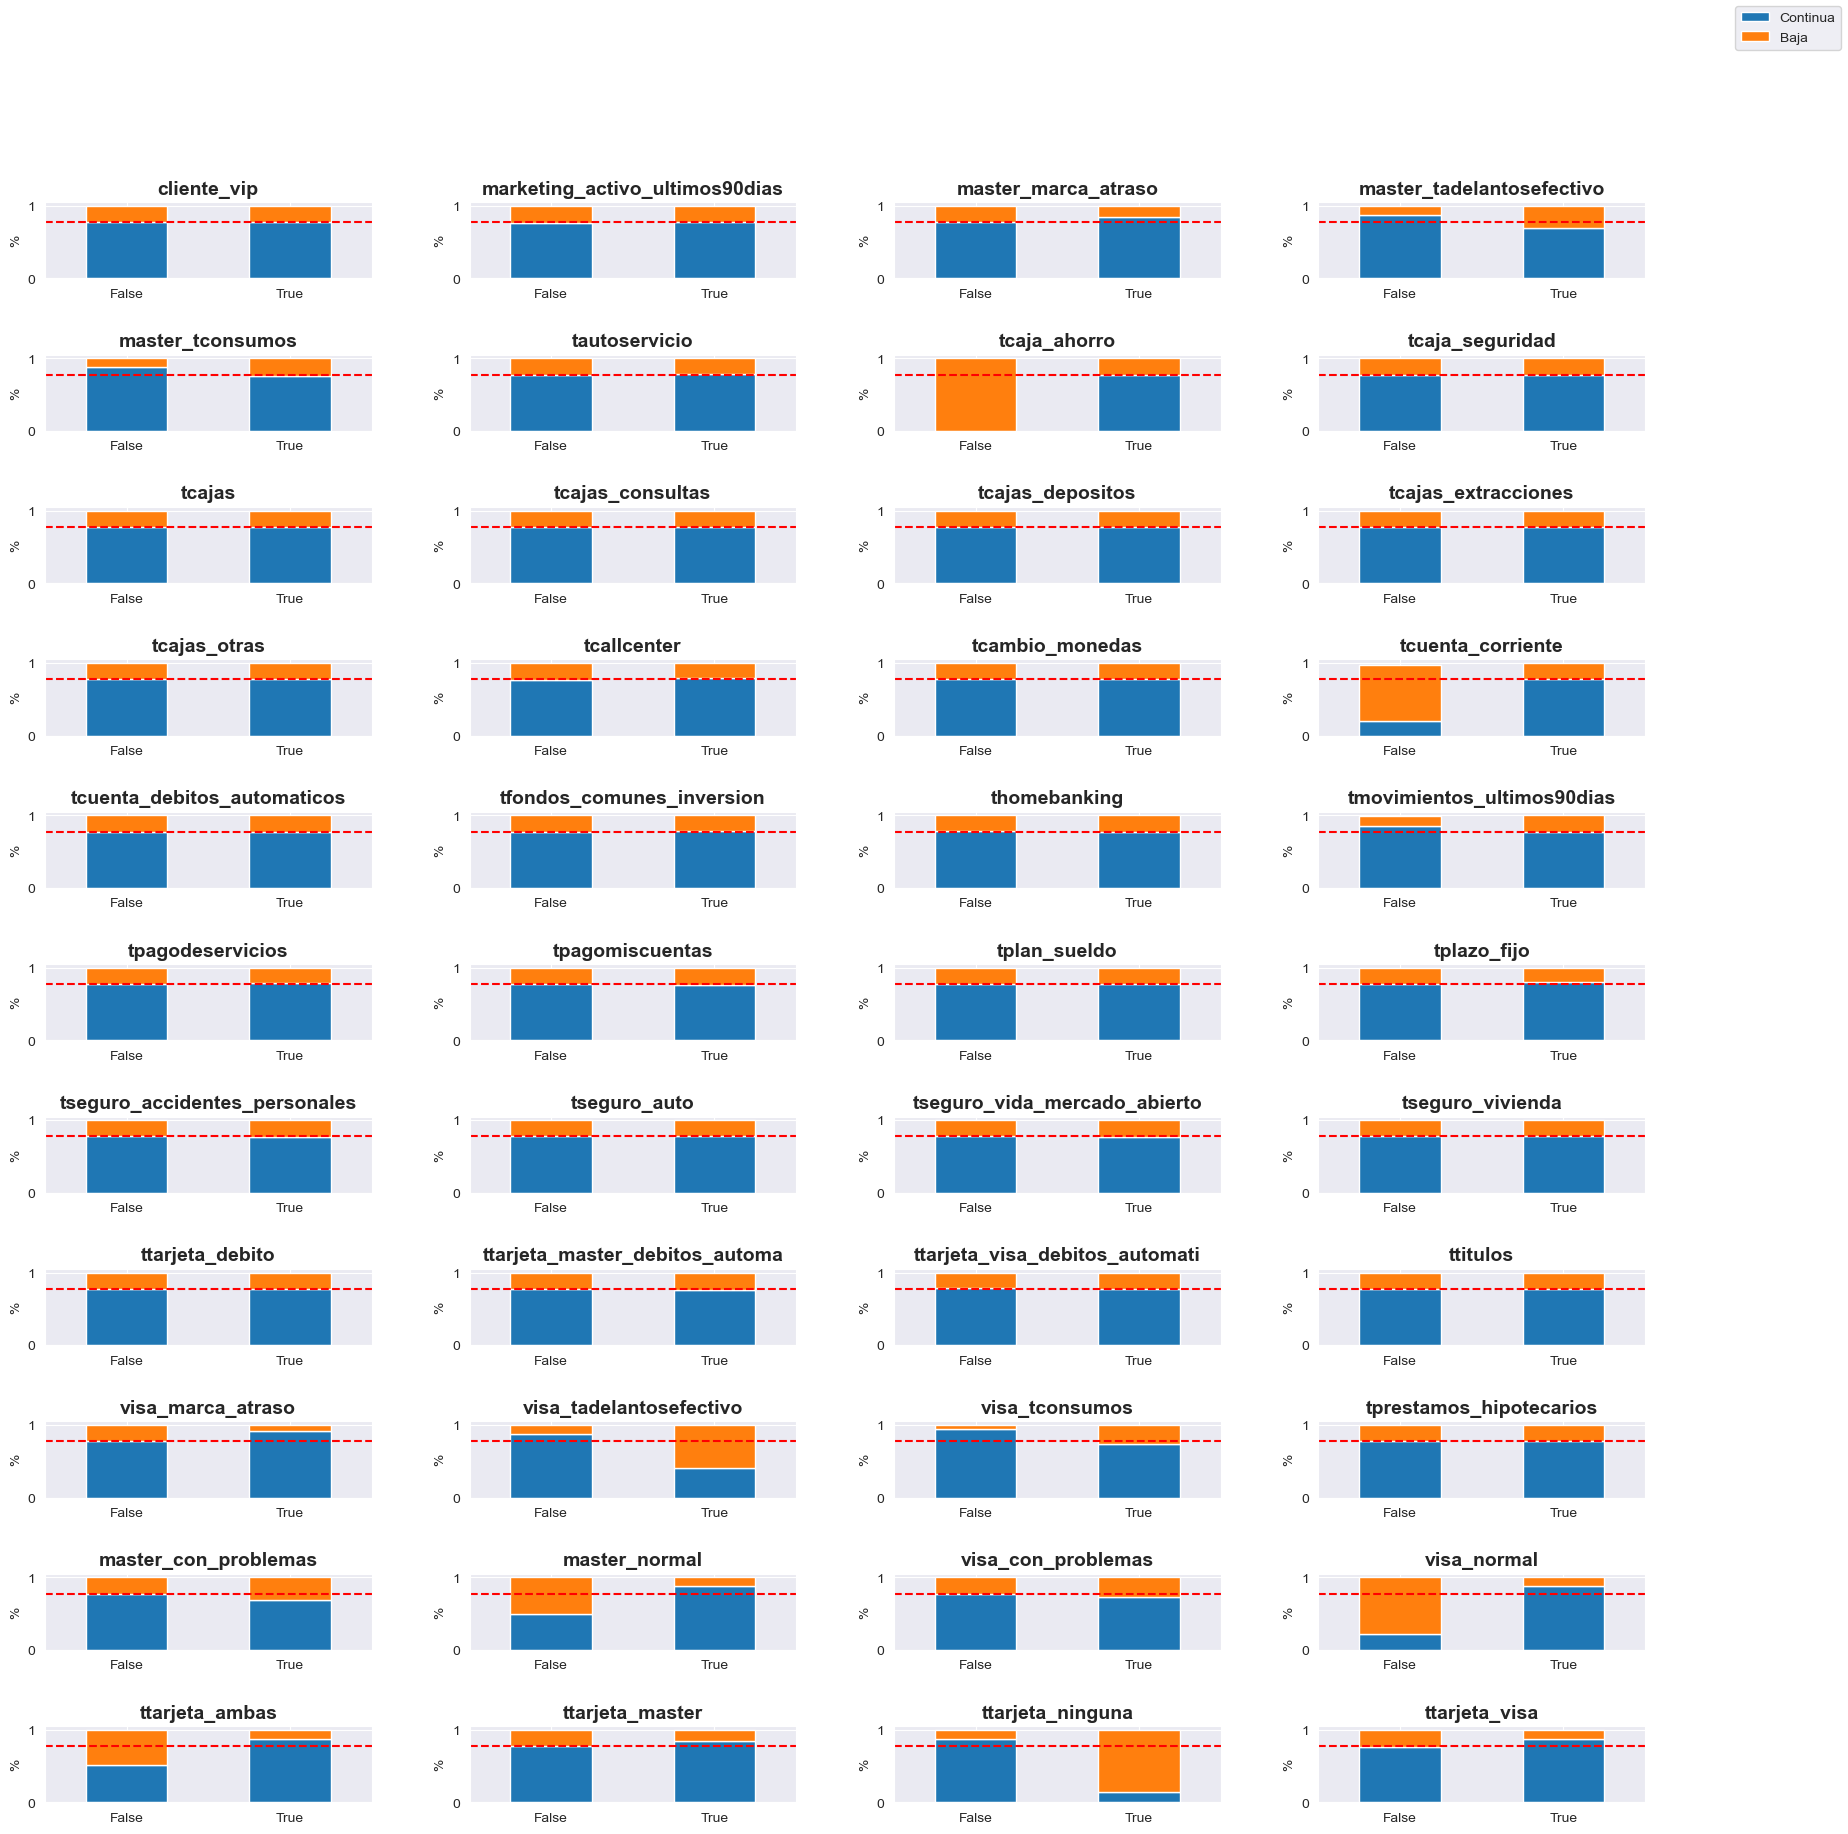

In [1313]:
sns.set_style("darkgrid")

n_vars = len(df_col_booleanas.columns)
ncols = 4
nrows = (n_vars + ncols - 1) // ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

for i, var in enumerate(df_col_booleanas):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    binaria_grouped_2 = df_2.groupby([var, 'clasebinaria']).size().reset_index(name='counts')
    binaria_grouped_2 = binaria_grouped_2.pivot(index=var, columns='clasebinaria', values='counts')
    binaria_grouped_2['Continua'] = binaria_grouped_2[0] / binaria_grouped_2.sum(axis=1)
    binaria_grouped_2['Baja'] = binaria_grouped_2[1] / binaria_grouped_2.sum(axis=1)
    binaria_grouped_2[['Continua', 'Baja']].plot.bar(stacked=True, ax=ax, legend = False)
    ax.set_xlabel(None)
    ax.set_ylabel('%')
    ax.set_title(f"{var}", fontweight='bold', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.axhline(y=0.776, color='red', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=1)

# Agregar la leyenda fuera de los gráficos
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

Para testear calidad de nuestras variables, constatamos que la situación de tenencia de alguna tarjeta sea opuesta a tener un estado "normal" en la misma.

In [1314]:
df_2[df_2['ttarjeta_ninguna']== True]['visa_normal'].value_counts()

False    18414
Name: visa_normal, dtype: int64

In [1315]:
df_2[df_2['ttarjeta_ninguna']== True]['master_normal'].value_counts()

False    18414
Name: master_normal, dtype: int64

In [1316]:
df_2[df_2['mtarjeta_visa_consumo'] == 0]

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
12                               42                              0   
27                                3                              1   
28                                5                              2   
29                                3                              1   
35                                0                              1   
...                             ...                            ...   
140573                            2                              0   
140600                            0                              0   
140603                            0                              0   
140612                            1                              0   
140613                            1                              0   

        ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
12                                  0                            0   
27                                  0                            0   
28                                  0                            0   
29                                  0                            0   
35                                  0                            1   
...                               ...                          ...   
140573                              0                            0   
140600                              0                            0   
140603                             10                            0   
140612                              0                            0   
140613                              0                            0   

        ccallcenter_transacciones  ccambio_monedas_compra  \
12                              0                       0   
27                              0                       0   
28                             14                       0   
29                              0                       0   
35                              0                       0   
...                           ...                     ...   
140573                          0                       1   
140600                          0                       0   
140603                         21                       0   
140612                          0                       0   
140613                          0                       0   

        ccambio_monedas_venta  ccheques_depositados  \
12                          0                     2   
27                          0                     0   
28                          0                     2   
29                          0                     0   
35                          0                     0   
...                       ...                   ...   
140573                      0                     0   
140600                      0                     0   
140603                      0                     0   
140612                      0                     0   
140613                      0                     0   

        ccheques_depositados_rechazado  ccheques_emitidos  ...  \
12                                   0                 11  ...   
27                                   0                  1  ...   
28                                   0                  2  ...   
29                                   0                  0  ...   
35                                   0                  0  ...   
...                                ...                ...  ...   
140573                               0                  0  ...   
140600                               0                  0  ...   
140603                               0                  0  ...   
140612                               0                  1  ...   
140613                               0                  1  ...   

        tprestamos_hipotecarios  master_con_problemas  master_normal  \
12                        False                 False          Fals

In [1317]:
df_2.columns[50:80]

Index(['mcheques_emitidos_rechazados', 'mcuenta_corriente_nopaquete',
       'mcuenta_corriente_paquete', 'mcuenta_debitos_automaticos',
       'mcuentas_saldo', 'mdescubierto_preacordado',
       'mextraccion_autoservicio', 'mfondos_comunes_inversion_dola',
       'mfondos_comunes_inversion_peso', 'mpagodeservicios', 'mpagomiscuentas',
       'mpasivos_margen', 'mplan_sueldo', 'mplan_sueldo_manual',
       'mplazo_fijo_dolares', 'mplazo_fijo_pesos', 'mprestamos_hipotecarios',
       'mprestamos_personales', 'mprestamos_prendarios', 'mrentabilidad',
       'mrentabilidad_annual', 'mtarjeta_master_consumo',
       'mtarjeta_master_descuentos', 'mtarjeta_visa_consumo',
       'mtarjeta_visa_descuentos', 'mtitulos', 'mtransferencias_emitidas',
       'mtransferencias_recibidas', 'mttarjeta_master_debitos_autom',
       'mttarjeta_visa_debitos_automat'],
      dtype='object')

### Matriz de Correlaciones

In [1318]:
#!pip install dython
from dython.nominal import associations

Utilizando la librería dython realizamos una point biserial correlation en base al V de Cramer, para entender las correlaciones entre nuestras variables dicotómicas. Incluímos la variable dependiente.

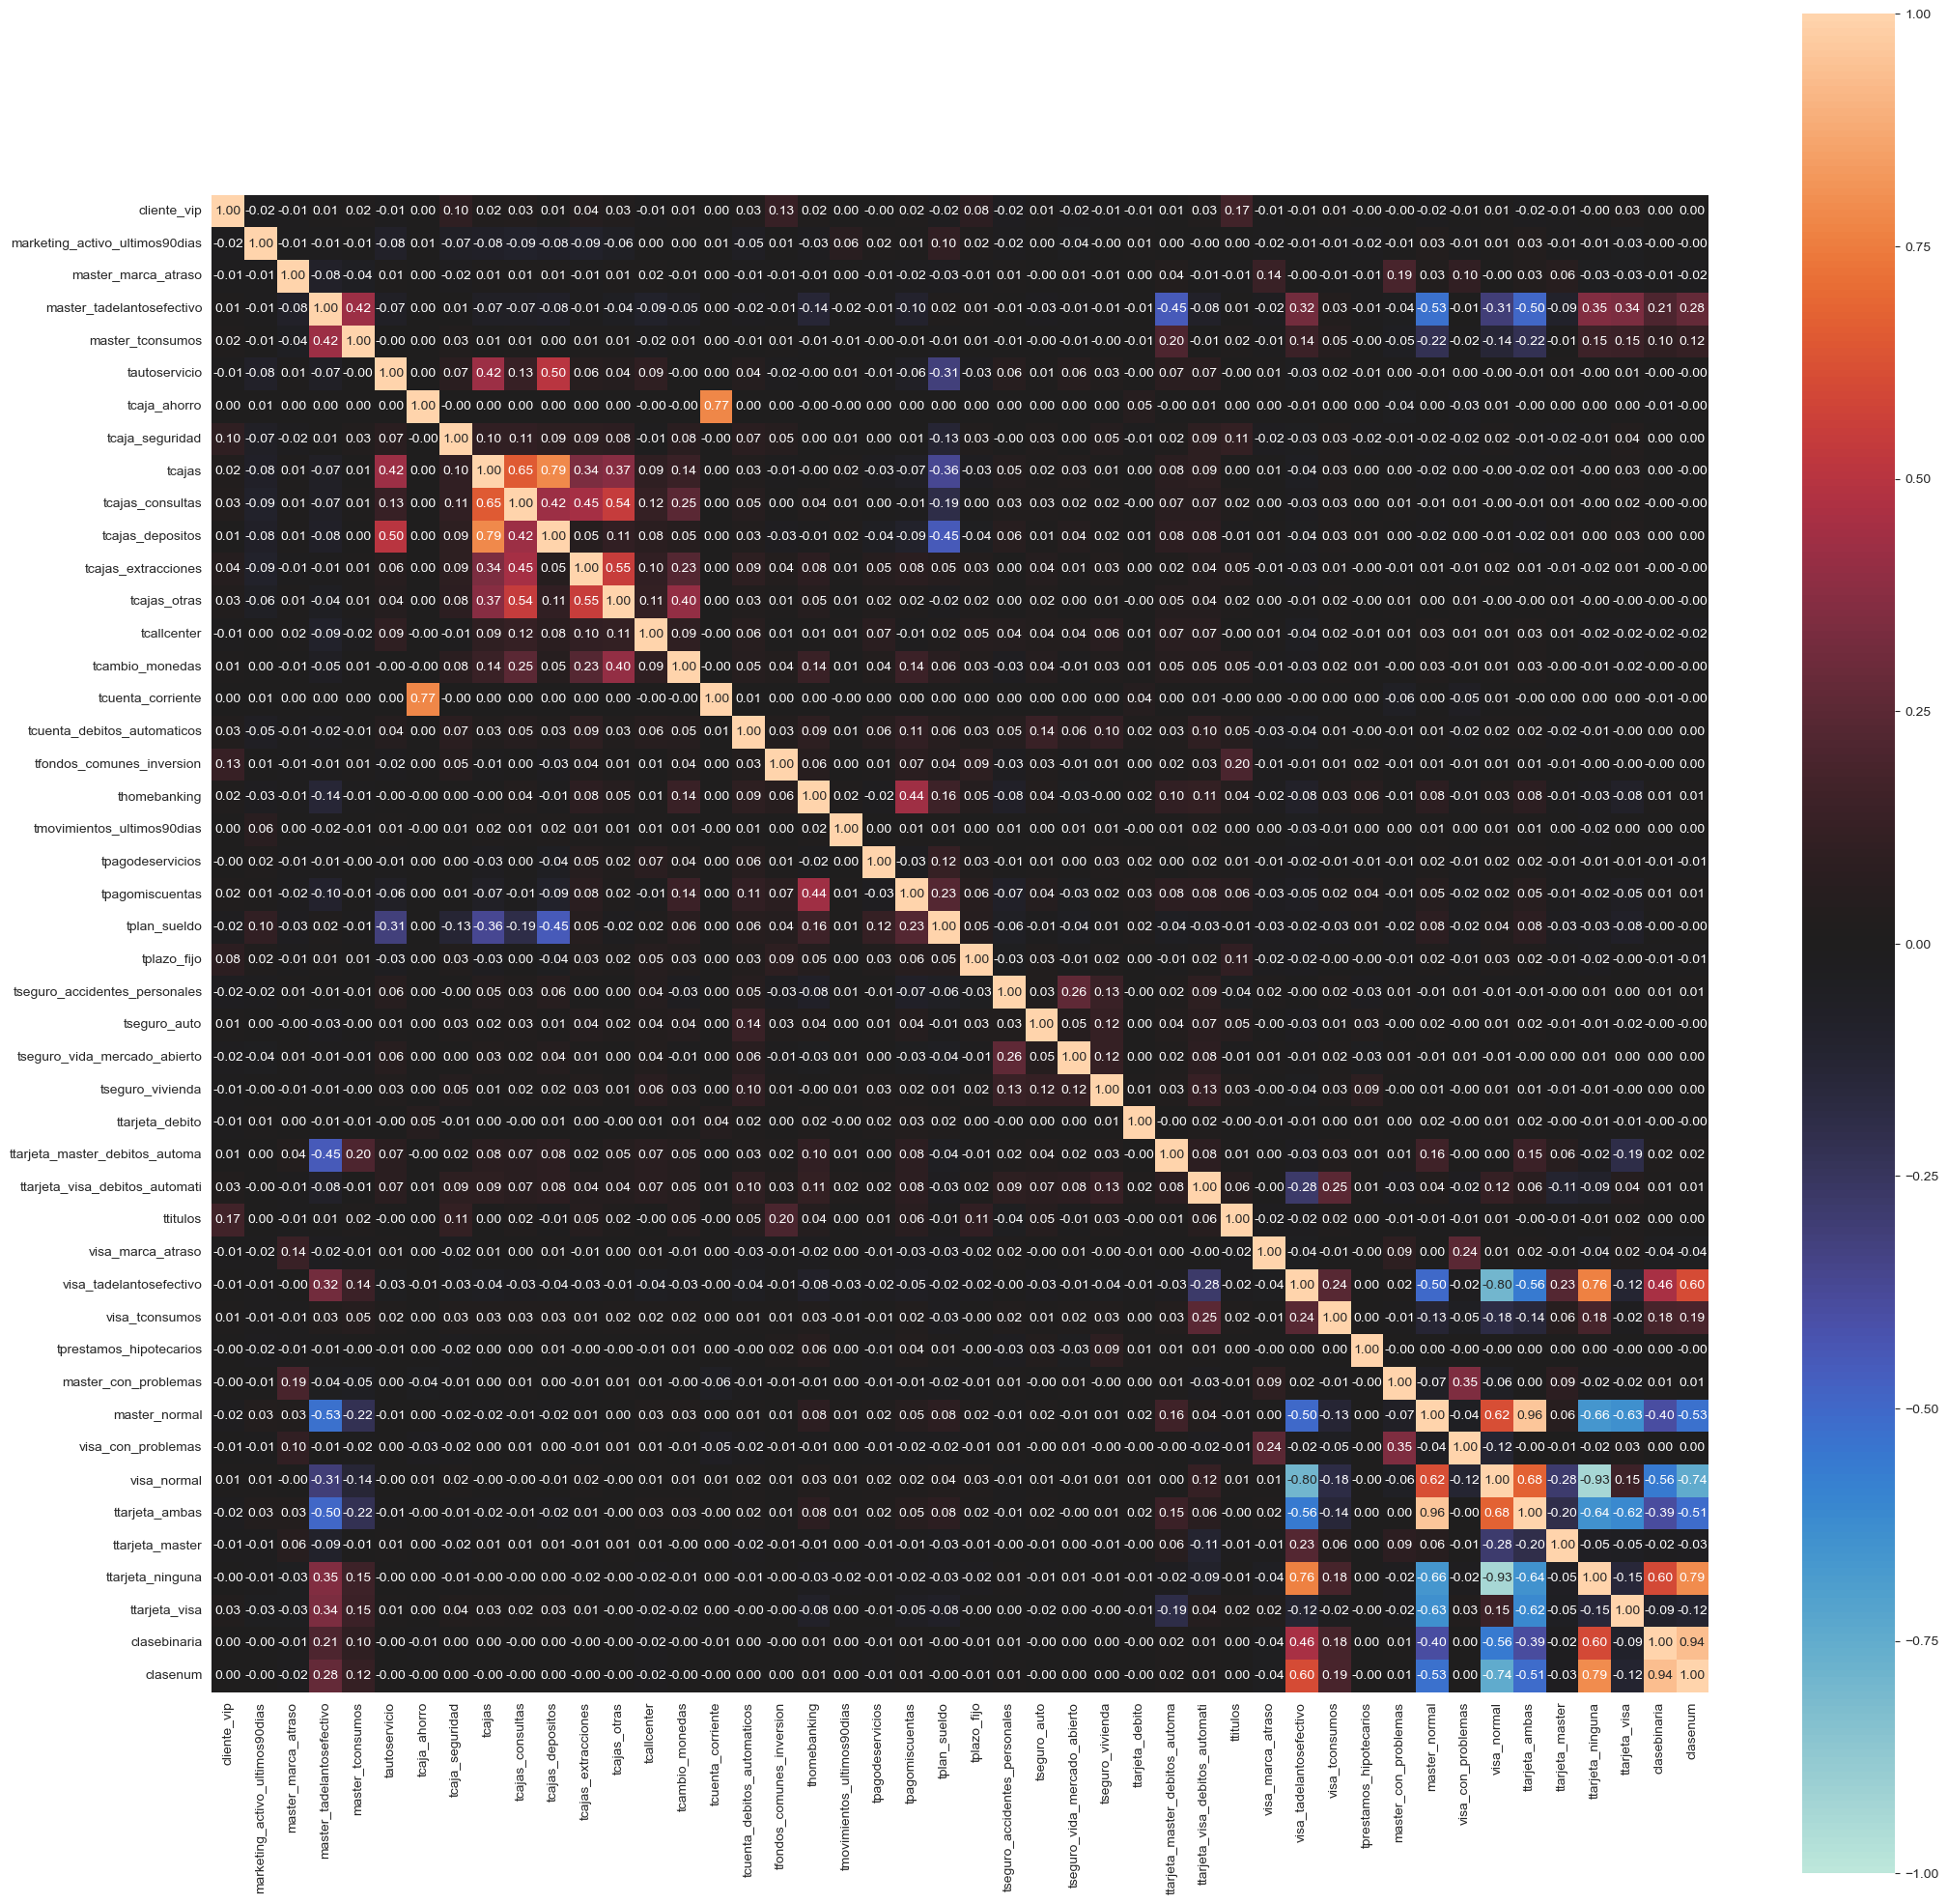

<function dict.keys>

In [1319]:
associations(pd.concat([df_col_booleanas, y], axis = 1), figsize=(25,25)).keys #se coloca este valor para que 
#la funcion muestre el heatmap sin el diccionario de correlaciones asociado

Si observamos las últimas dos filas, tenemos la correlación de cada una de las variables con nuestra variable dependiente. Llama la atención el alto valor de visa_adelantoefectivo y visa_tconsumos con ttarjeta_ninguna, ya que es de suponer que una valor alto en tener el servicio de adelantos en efectivo para la tarjeta debería tener una relación opuesta a no tener tarjeta. Revisamos esa relación y constatamos que entre los que no tienen tarjetas hay algunos que tienen adelantos en efectivo para las mismas, por lo que procedemos a una última imputación de nuestras variables sobre tenencias de plástico para las observaciones donde se encuentre cualquier servicio asociado a las mismas.

In [1320]:
df_2[df_2['ttarjeta_ninguna']== True]['visa_tconsumos'].value_counts()

True    18414
Name: visa_tconsumos, dtype: int64

In [1321]:
df_2[df_2['ttarjeta_ninguna']== True]['visa_tadelantosefectivo'].value_counts()

True    18414
Name: visa_tadelantosefectivo, dtype: int64

In [1322]:
df_2[df_2['ttarjeta_ninguna']== True]['master_tconsumos'].value_counts()

True    18414
Name: master_tconsumos, dtype: int64

In [1323]:
df_2[df_2['ttarjeta_ninguna']== True]['master_tadelantosefectivo'].value_counts()

True    18414
Name: master_tadelantosefectivo, dtype: int64

In [1324]:
df_2['ttarjeta_ninguna'].value_counts()

False    118762
True      18414
Name: ttarjeta_ninguna, dtype: int64

En definitiva, parecería ser que el estado de tarjetas es positivo para todos los casos, por lo que eliminamos todas las variables que refieran a la existencia de la misma ya que en todos los casos se imputara positivo (al no contar con información que asigne un marco temporal no podemos analizar el cambio de estados de actividad)

In [1462]:
cols_visa = [col for col in df_2 if col.__contains__('visa')] #es el contains
visa = df_2[cols_visa]

In [1463]:
visa = visa.select_dtypes(int, float)

In [1475]:
df_2['cant_servicio_visa'] = (visa != 0).sum(axis = 1)

In [1477]:
df_2.loc[df_2['cant_servicio_visa'] == 0, 'usa_servicio_visa'] = False
df_2.loc[df_2['cant_servicio_visa'] != 0, 'usa_servicio_visa'] = True

In [1479]:
df_2['usa_servicio_visa'].value_counts()

True     124173
False     13003
Name: usa_servicio_visa, dtype: int64

In [1467]:
cols_master = [col for col in df_2 if col.__contains__('master')] #es el contains
master = df_2[cols_master]

In [1499]:
cols_visa

['ctarjeta_visa_descuentos',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'mtarjeta_visa_descuentos',
 'mttarjeta_visa_debitos_automat',
 'visa_madelantodolares',
 'visa_madelantopesos',
 'visa_mconsumosdolares',
 'visa_mconsumospesos',
 'visa_mconsumototal',
 'visa_mpagado',
 'visa_mpagosdolares',
 'visa_mpagospesos',
 'visa_msaldodolares',
 'visa_msaldopesos',
 'visa_msaldototal',
 'ttarjeta_visa_debitos_automati',
 'visa_marca_atraso',
 'visa_tadelantosefectivo',
 'visa_tconsumos',
 'visa_con_problemas',
 'visa_normal',
 'ttarjeta_visa']

In [1468]:
master = master.select_dtypes(int, float)

In [1480]:
df_2['cant_servicio_master'] = (master != 0).sum(axis = 1)

In [1481]:
df_2.loc[df_2['cant_servicio_master'] == 0, 'usa_servicio_master'] = False
df_2.loc[df_2['cant_servicio_master'] != 0, 'usa_servicio_master'] = True

In [1482]:
df_2['usa_servicio_master'].value_counts()

True     71691
False    65485
Name: usa_servicio_master, dtype: int64

In [1521]:
df_2.loc[df_2['usa_servicio_visa'] == True, 'ttarjeta_visa']= True
df_2.loc[df_2['usa_servicio_visa'] == False, 'ttarjeta_visa']= False
df_2.loc[df_2['ttarjeta_visa'] == True, 'ttarjeta_ninguna']= False
df_2.loc[df_2['ttarjeta_visa'] == False, 'ttarjeta_ninguna']= True

In [1528]:
df_2.loc[df_2['usa_servicio_master'] == True, 'ttarjeta_master']= True
df_2.loc[df_2['usa_servicio_master'] == False, 'ttarjeta_master']= False
df_2.loc[df_2['ttarjeta_master'] == True, 'ttarjeta_ninguna']= False
df_2.loc[(df_2['ttarjeta_visa'] == False) | 
         (df_2['ttarjeta_master'] == False), 'ttarjeta_ambas']= False
df_2.loc[(df_2['ttarjeta_master'] == True) &
         (df_2['ttarjeta_visa'] == True) , 'ttarjeta_ambas']= True

In [1529]:
df_2['ttarjeta_ninguna'].value_counts()

False    127789
True       9387
Name: ttarjeta_ninguna, dtype: int64

In [1530]:
df_2 = df_2.drop(['master_con_problemas','master_normal', 'visa_con_problemas',
 'visa_normal'], axis = 1)

KeyError: "['master_con_problemas', 'master_normal', 'visa_con_problemas', 'visa_normal'] not found in axis"

In [1533]:
df_col_booleanas = df_2.select_dtypes('bool')

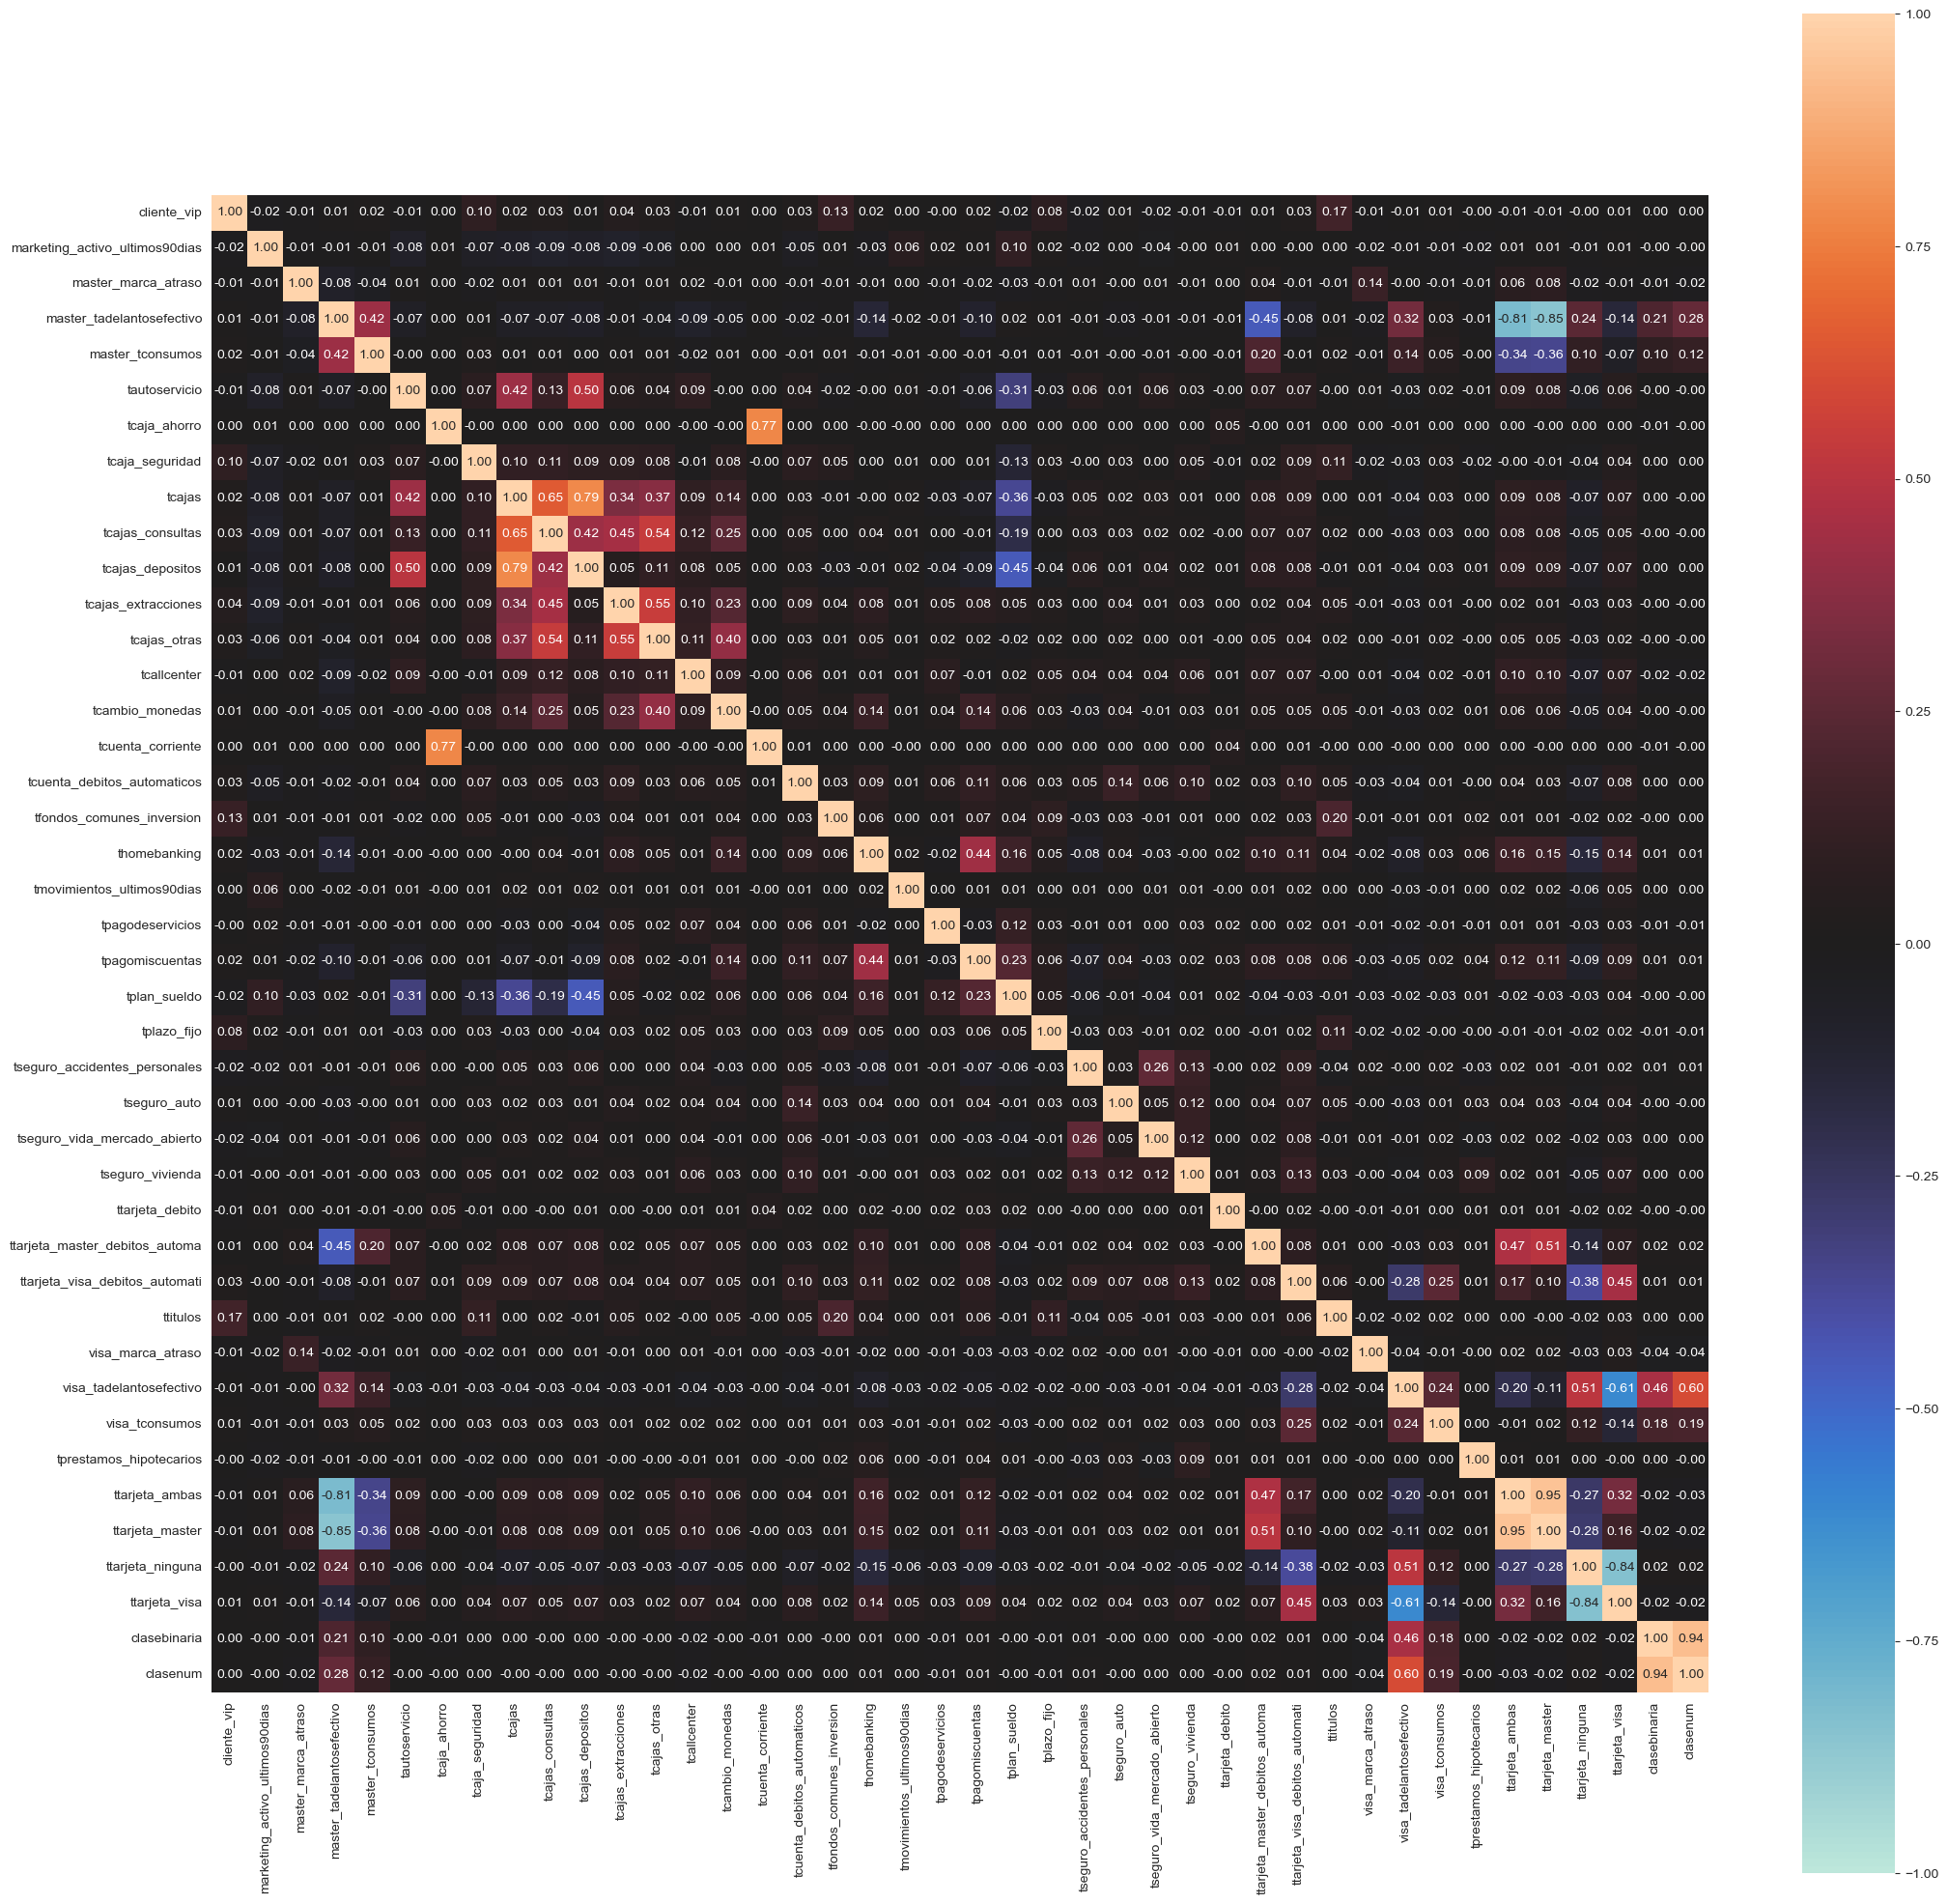

<function dict.keys>

In [1534]:
associations(pd.concat([df_col_booleanas, y], axis = 1), figsize=(25,25)).keys #se coloca este valor para que 
#la funcion muestre el heatmap sin el diccionario de correlaciones asociado

Si bien es necesario analizar otras variables e interacción entre las mismas, puede observarse que la baja presenta correlación positiva con los adelantos en efectivo con tarjetas.

### Variables continuas

In [1544]:
X = df_2.drop(df_col_booleanas.columns, axis = 1)#.drop(y.drop('clasenum', axis = 1).columns, axis = 1)

In [1550]:
X = df_2.drop(df_col_booleanas, axis = 1).drop(['usa_servicio_visa', 'usa_servicio_master'], axis = 1)

In [ ]:
#######################################################################
##REVISAR COMO ARMAR DE NUEVO EN LA X la variable uso_servicios#!!!!###
#######################################################################

In [1569]:
df_2 = pd.concat([df_2,X['uso_servicios']], axis = 1)

C:\Users\oblit\AppData\Local\Temp\ipykernel_18316\198373154.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_2 = pd.concat([df_2,X['uso_servicios']], axis = 1)


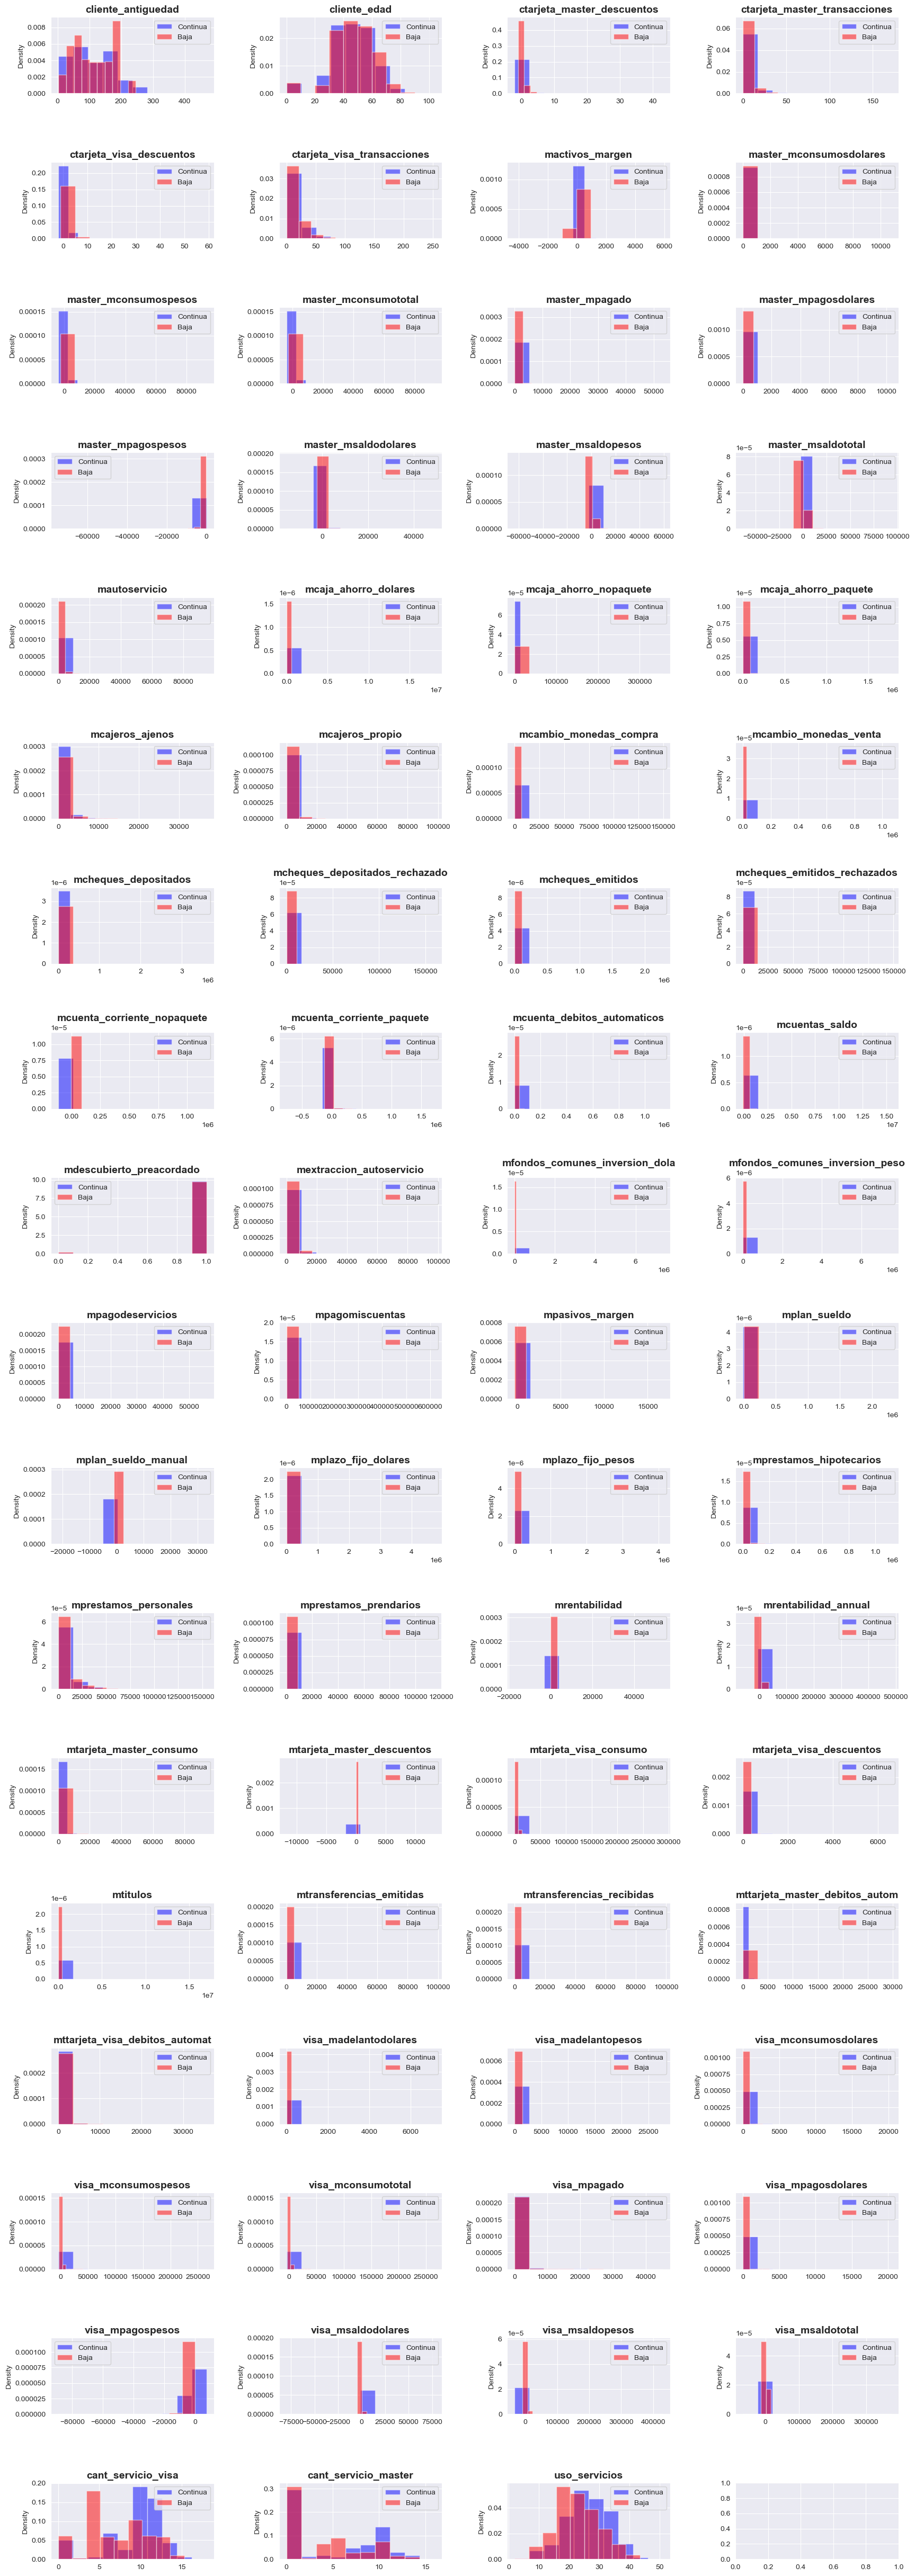

In [1571]:
sns.set_style("darkgrid")

n_vars = len(X.columns)
ncols = 4
nrows = (n_vars + ncols - 1) // ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 60))

for i, var in enumerate(X):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    df_2[df_2["clasebinaria"] == 0][var].hist(alpha=0.5, color='blue', ax=ax, label='Continua', density=True)
    df_2[df_2["clasebinaria"] == 1][var].hist(alpha=0.5, color='red', ax=ax, label='Baja', density=True)
    ax.set_xlabel(None)
    ax.set_ylabel('Density')
    ax.set_title(f"{var}", fontweight='bold', fontsize=14)
    ax.legend()

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.9)
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

plt.show()

In [1572]:
df_2.describe()

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
count                137176.000000                  137176.000000   
mean                      1.656558                       1.315135   
std                       4.190713                       2.848324   
min                    -124.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       0.000000                       0.000000   
75%                       2.000000                       1.000000   
max                     122.000000                      58.000000   

       ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
count                  137176.000000                137176.000000   
mean                        1.849106                     1.355725   
std                         3.320722                     2.313445   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         3.000000                     2.000000   
max                        91.000000                    39.000000   

       ccallcenter_transacciones  ccambio_monedas_compra  \
count              137176.000000           137176.000000   
mean                    4.297705                0.118301   
std                    10.838655                0.524190   
min                  -128.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     4.000000                0.000000   
max                   127.000000               13.000000   

       ccambio_monedas_venta  ccheques_depositados  \
count          137176.000000         137176.000000   
mean                0.118527              0.670489   
std                 0.463911              2.661380   
min                 0.000000           -120.000000   
25%                 0.000000              0.000000   
50%                 0.000000              0.000000   
75%                 0.000000              0.000000   
max                21.000000            112.000000   

       ccheques_depositados_rechazado  ccheques_emitidos  ...   visa_mpagado  \
count                   137176.000000      137176.000000  ...  137176.000000   
mean                         0.014230           0.725746  ...     364.506699   
std                          0.150867           3.048019  ...    1428.823189   
min                          0.000000        -124.000000  ...       0.000000   
25%                          0.000000           0.000000  ...       0.000000   
50%                          0.000000           0.000000  ...       0.000000   
75%                          0.000000           0.000000  ...       0.000000   
max                         13.000000         110.000000  ...   45195.000000   

       visa_mpagosdolares  visa_mpagospesos  visa_msaldodolares  \
count       137176.000000     137176.000000       137176.000000   
mean            31.034066      -1729.854195          216.854114   
std            244.291605       2716.726764         1385.120593   
min              0.000000     -89193.000000       -79968.000000   
25%              0.000000      -2387.250000            0.000000   
50%              0.000000       -842.000000            0.000000   
75%              0.000000          0.000000            0.000000   
max          20400.000000       7469.000000        77684.000000   

       visa_msaldopesos  visa_msaldototal   clasebinaria  cant_servicio_visa  \
count     137176.000000     137176.000000  137176.000000       137176.000000   
mean        2321.968092       2206.590023       0.223946            8.667252   
std         3531.030226       3435.392105       0.416888            3.668878   
min       -32816.000000     -67099.000000       0.000000            0.000000   
25%       

Se observa que existe una gran cantidad de registros cercanos a 0, que mayoritariamente corresponden a los clientes en situación de baja.

La edad de los clientes y el uso de servicios parecieran ser las únicas dos distribuciones normales en el dataset. Comparamos las distribuciones de la varianza según utilización de servicios para comprobar si existen diferencias significativas en la media que nos hablen de comportamientos diferenciales para la variable dependiente.

In [1585]:
from scipy.stats import f_oneway

pivot = pd.pivot_table(df_2.groupby(['uso_servicios', 'clasebinaria']).size().reset_index(), index = 'uso_servicios', columns = 'clasebinaria', values = 0).fillna(0)
pivot = pivot.rename_axis(None, axis=1).rename({0:'continua', 1:'baja'}, axis = 1)

In [1595]:
pivot.head()

continua  baja
uso_servicios                
2                   3.0   2.0
3                  23.0   3.0
4                  32.0  11.0
5                  51.0  18.0
6                  85.0  30.0

In [1588]:
f_oneway(pivot['continua'], pivot['baja'])

F_onewayResult(statistic=23.457607957385953, pvalue=4.775007078822749e-06)

In [1600]:
print('Se comprueba que existe una diferencia en el uso de servicios entre los clientes que se dieron de baja y los que no, con un p-value de', f_oneway(pivot['continua'], pivot['baja'])[1])

Se comprueba que existe una diferencia en el uso de servicios entre los clientes que se dieron de baja y los que no, con un p-value de 4.775007078822749e-06


In [1592]:
pivot_2 = pd.pivot_table(df_2.groupby(['marketing_coss_selling', 'clasebinaria']).size().reset_index(), index = 'marketing_coss_selling', columns = 'clasebinaria', values = 0).fillna(0)
pivot_2 = pivot_2.rename_axis(None, axis=1).rename({0:'continua', 1:'baja'}, axis = 1)


In [1593]:
f_oneway(pivot_2['continua'], pivot_2['baja'])

F_onewayResult(statistic=4.30946100873042, pvalue=0.046568260864999524)

In [1603]:
print('Se comprueba que existe una diferencia entre los clientes que se dieron de baja y los que no según la cantidad de productos de marketing adquiridos, con un p-value de', f_oneway(pivot_2['continua'], pivot_2['baja'])[1])

Se comprueba que existe una diferencia entre los clientes que se dieron de baja y los que no según la cantidad de productos de marketing adquiridos, con un p-value de 0.046568260864999524


In [1604]:
df_2.describe()

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
count                137176.000000                  137176.000000   
mean                      1.656558                       1.315135   
std                       4.190713                       2.848324   
min                    -124.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       0.000000                       0.000000   
75%                       2.000000                       1.000000   
max                     122.000000                      58.000000   

       ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
count                  137176.000000                137176.000000   
mean                        1.849106                     1.355725   
std                         3.320722                     2.313445   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         3.000000                     2.000000   
max                        91.000000                    39.000000   

       ccallcenter_transacciones  ccambio_monedas_compra  \
count              137176.000000           137176.000000   
mean                    4.297705                0.118301   
std                    10.838655                0.524190   
min                  -128.000000                0.000000   
25%                     0.000000                0.000000   
50%                     0.000000                0.000000   
75%                     4.000000                0.000000   
max                   127.000000               13.000000   

       ccambio_monedas_venta  ccheques_depositados  \
count          137176.000000         137176.000000   
mean                0.118527              0.670489   
std                 0.463911              2.661380   
min                 0.000000           -120.000000   
25%                 0.000000              0.000000   
50%                 0.000000              0.000000   
75%                 0.000000              0.000000   
max                21.000000            112.000000   

       ccheques_depositados_rechazado  ccheques_emitidos  ...   visa_mpagado  \
count                   137176.000000      137176.000000  ...  137176.000000   
mean                         0.014230           0.725746  ...     364.506699   
std                          0.150867           3.048019  ...    1428.823189   
min                          0.000000        -124.000000  ...       0.000000   
25%                          0.000000           0.000000  ...       0.000000   
50%                          0.000000           0.000000  ...       0.000000   
75%                          0.000000           0.000000  ...       0.000000   
max                         13.000000         110.000000  ...   45195.000000   

       visa_mpagosdolares  visa_mpagospesos  visa_msaldodolares  \
count       137176.000000     137176.000000       137176.000000   
mean            31.034066      -1729.854195          216.854114   
std            244.291605       2716.726764         1385.120593   
min              0.000000     -89193.000000       -79968.000000   
25%              0.000000      -2387.250000            0.000000   
50%              0.000000       -842.000000            0.000000   
75%              0.000000          0.000000            0.000000   
max          20400.000000       7469.000000        77684.000000   

       visa_msaldopesos  visa_msaldototal   clasebinaria  cant_servicio_visa  \
count     137176.000000     137176.000000  137176.000000       137176.000000   
mean        2321.968092       2206.590023       0.223946            8.667252   
std         3531.030226       3435.392105       0.416888            3.668878   
min       -32816.000000     -67099.000000       0.000000            0.000000   
25%       

## Estandarización de variables continuas

In [1605]:
#from sklearn.preprocessing import StandardScaler #importo librería para normalizar la información
scaler = StandardScaler()
X = scaler.fit_transform(df_no_booleanas)

In [1606]:
X = pd.DataFrame(X, index = df_no_booleanas.index)
X.columns = list(df_no_booleanas.columns) #recupero los nombres de las variables del DF original luego del escalado

In [1607]:
###hacer grafico de correlaciones##

X.corr()

cautoservicio_transacciones  \
cautoservicio_transacciones                       1.000000   
ccajeros_ajenos_transacciones                    -0.067652   
ccajeros_propio_transacciones                    -0.017815   
ccajeros_propios_descuentos                      -0.007953   
ccallcenter_transacciones                         0.087637   
...                                                    ...   
visa_mpagosdolares                                0.000157   
visa_mpagospesos                                 -0.042241   
visa_msaldodolares                                0.017128   
visa_msaldopesos                                  0.059952   
visa_msaldototal                                  0.059493   

                               ccajeros_ajenos_transacciones  \
cautoservicio_transacciones                        -0.067652   
ccajeros_ajenos_transacciones                       1.000000   
ccajeros_propio_transacciones                       0.199570   
ccajeros_propios_descuentos                         0.112820   
ccallcenter_transacciones                           0.045664   
...                                                      ...   
visa_mpagosdolares                                  0.007746   
visa_mpagospesos                                   -0.023378   
visa_msaldodolares                                  0.009067   
visa_msaldopesos                                    0.036578   
visa_msaldototal                                    0.035914   

                               ccajeros_propio_transacciones  \
cautoservicio_transacciones                        -0.017815   
ccajeros_ajenos_transacciones                       0.199570   
ccajeros_propio_transacciones                       1.000000   
ccajeros_propios_descuentos                         0.171504   
ccallcenter_transacciones                           0.031585   
...                                                      ...   
visa_mpagosdolares                                 -0.012580   
visa_mpagospesos                                    0.018670   
visa_msaldodolares                                 -0.017540   
visa_msaldopesos                                   -0.006194   
visa_msaldototal                                   -0.011703   

                               ccajeros_propios_descuentos  \
cautoservicio_transacciones                      -0.007953   
ccajeros_ajenos_transacciones                     0.112820   
ccajeros_propio_transacciones                     0.171504   
ccajeros_propios_descuentos                       1.000000   
ccallcenter_transacciones                         0.003494   
...                                                    ...   
visa_mpagosdolares                                0.004896   
visa_mpagospesos                                  0.025009   
visa_msaldodolares                               -0.020517   
visa_msaldopesos                                 -0.053276   
visa_msaldototal                                 -0.054688   

                               ccallcenter_transacciones  \
cautoservicio_transacciones                     0.087637   
ccajeros_ajenos_transacciones                   0.045664   
ccajeros_propio_transacciones                   0.031585   
ccajeros_propios_descuentos                     0.003494   
ccallcenter_transacciones                       1.000000   
...                                                  ...   
visa_mpagosdolares                              0.017236   
visa_mpagospesos                               -0.057329   
visa_msaldodolares                              0.013160   
visa_msaldopesos                                0.082071   
visa_msaldototal                                0.077988   

                               ccambio_monedas_compra  ccambio_monedas_venta  \
cautoservicio_transacciones                  0.020679               0.018606   
ccajeros_ajenos_transacciones                0.075933               0.047784   
ccajeros_propio_transacciones             

In [1608]:
df_estandarizado = pd.concat([X,df_col_booleanas,y], axis = 1)

In [1609]:
df_estandarizado

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
0                         -0.395294                      -0.461724   
1                         -0.395294                      -0.461724   
2                         -0.395294                      -0.110639   
3                         -0.395294                       0.591531   
4                         -0.395294                      -0.461724   
...                             ...                            ...   
140610                    -0.395294                      -0.461724   
140611                    -0.395294                      -0.110639   
140612                    -0.156670                      -0.461724   
140613                    -0.156670                      -0.461724   
140614                    -0.156670                      -0.461724   

        ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
0                           -0.556841                    -0.586022   
1                           -0.556841                    -0.153765   
2                           -0.556841                    -0.586022   
3                            0.346581                    -0.586022   
4                           -0.556841                    -0.153765   
...                               ...                          ...   
140610                      -0.556841                    -0.153765   
140611                      -0.255700                    -0.586022   
140612                      -0.556841                    -0.586022   
140613                      -0.556841                    -0.586022   
140614                      -0.556841                    -0.586022   

        ccallcenter_transacciones  ccambio_monedas_compra  \
0                       -0.027467               -0.225684   
1                        0.064796               -0.225684   
2                        0.157058                1.682030   
3                        0.064796                1.682030   
4                       -0.396518               -0.225684   
...                           ...                     ...   
140610                  -0.396518               -0.225684   
140611                  -0.396518               -0.225684   
140612                  -0.396518               -0.225684   
140613                  -0.396518               -0.225684   
140614                  -0.396518               -0.225684   

        ccambio_monedas_venta  ccheques_depositados  \
0                   -0.255495             -0.251934   
1                   -0.255495             -0.251934   
2                   -0.255495             -0.251934   
3                   -0.255495             -0.251934   
4                   -0.255495             -0.251934   
...                       ...                   ...   
140610              -0.255495             -0.251934   
140611               1.900099             -0.251934   
140612              -0.255495             -0.251934   
140613              -0.255495             -0.251934   
140614              -0.255495             -0.251934   

        ccheques_depositados_rechazado  ccheques_emitidos  ...  \
0                            -0.094321          -0.238105  ...   
1                            -0.094321          -0.238105  ...   
2                            -0.094321          -0.238105  ...   
3                            -0.094321          -0.238105  ...   
4                            -0.094321          -0.238105  ...   
...                                ...                ...  ...   
140610                       -0.094321           0.089978  ...   
140611                       -0.094321          -0.238105  ...   
140612                       -0.094321           0.089978  ...   
140613                       -0.094321           0.089978  ...   
140614                       -0.094321          -0.238105  ...   

        visa_marca_atraso  visa_tadelantosefectivo  visa_tconsumos  \
0                   False                    False            True   

In [1610]:
df_estandarizado.describe()

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
count                 1.371760e+05                   1.371760e+05   
mean                 -1.657532e-18                   4.599653e-17   
std                   1.000004e+00                   1.000004e+00   
min                  -2.998464e+01                  -4.617242e-01   
25%                  -3.952941e-01                  -4.617242e-01   
50%                  -3.952941e-01                  -4.617242e-01   
75%                   8.195342e-02                  -1.106392e-01   
max                   2.871680e+01                   1.990120e+01   

       ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
count                   1.371760e+05                 1.371760e+05   
mean                    8.287662e-19                 2.900682e-17   
std                     1.000004e+00                 1.000004e+00   
min                    -5.568406e-01                -5.860222e-01   
25%                    -5.568406e-01                -5.860222e-01   
50%                    -5.568406e-01                -5.860222e-01   
75%                     3.465806e-01                 2.784924e-01   
max                     2.684694e+01                 1.627201e+01   

       ccallcenter_transacciones  ccambio_monedas_compra  \
count               1.371760e+05            1.371760e+05   
mean               -3.480818e-17            6.630130e-18   
std                 1.000004e+00            1.000004e+00   
min                -1.220614e+01           -2.256836e-01   
25%                -3.965179e-01           -2.256836e-01   
50%                -3.965179e-01           -2.256836e-01   
75%                -2.746708e-02           -2.256836e-01   
max                 1.132085e+01            2.457460e+01   

       ccambio_monedas_venta  ccheques_depositados  \
count           1.371760e+05          1.371760e+05   
mean            2.154792e-17          3.315065e-18   
std             1.000004e+00          1.000004e+00   
min            -2.554952e-01         -4.534149e+01   
25%            -2.554952e-01         -2.519338e-01   
50%            -2.554952e-01         -2.519338e-01   
75%            -2.554952e-01         -2.519338e-01   
max             4.501199e+01          4.183165e+01   

       ccheques_depositados_rechazado  ccheques_emitidos  ...  \
count                    1.371760e+05       1.371760e+05  ...   
mean                    -3.315065e-17       9.945195e-18  ...   
std                      1.000004e+00       1.000004e+00  ...   
min                     -9.432108e-02      -4.092042e+01  ...   
25%                     -9.432108e-02      -2.381052e-01  ...   
50%                     -9.432108e-02      -2.381052e-01  ...   
75%                     -9.432108e-02      -2.381052e-01  ...   
max                      8.607456e+01       3.585104e+01  ...   

       visa_mconsumospesos  visa_mconsumototal  visa_mpagado  \
count         1.371760e+05        1.371760e+05  1.371760e+05   
mean          2.652052e-17       -2.486299e-17 -5.801364e-18   
std           1.000004e+00        1.000004e+00  1.000004e+00   
min          -2.312667e+00       -2.304464e+00 -2.551107e-01   
25%          -4.677406e-01       -4.674057e-01 -2.551107e-01   
50%          -3.553087e-01       -3.541565e-01 -2.551107e-01   
75%           9.832609e-02        9.927270e-02 -2.551107e-01   
max           1.147768e+02        1.142856e+02  3.137593e+01   

       visa_mpagosdolares  visa_mpagospesos  visa_msaldodolares  \
count        1.371760e+05      1.371760e+05        1.371760e+05   
mean         2.237669e-17      1.326026e-17        3.190750e-17   
std          1.000004e+00      1.000004e+00        1.000004e+00   
min         -1.270374e-01     -3.219443e+01       -5.789037e+01   
25%         -1.270374e-01     -2.419817e-01       -1.565603e-01   
50%         -1.270374e-01      3.268115e-01       -1.565603e-01   
75%         -1.270374e-01      6.367444e-01       -1.565603e-01   
max          8.338003e+01      3.386

In [1611]:
df_estandarizado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137176 entries, 0 to 140614
Columns: 133 entries, cautoservicio_transacciones to clasenum
dtypes: bool(40), float64(91), int8(2)
memory usage: 105.8 MB


# Prueba de reducción de la dimensionalidad

Examinamos si encontramos en el subset de la clase binaria elementos que nos permitan reducir la dimensionalidad del dataset.

In [1632]:
df_af = df_estandarizado.loc[df_estandarizado['clasebinaria']==1][X.columns]

In [1633]:
df_af

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
5                         -0.395294                       0.240446   
6                         -0.395294                      -0.110639   
7                          1.752320                       0.942615   
11                         0.081953                      -0.461724   
15                        -0.395294                      -0.461724   
...                             ...                            ...   
140597                    -0.156670                      -0.461724   
140599                     0.320577                      -0.461724   
140606                     0.081953                      -0.461724   
140610                    -0.395294                      -0.461724   
140611                    -0.395294                      -0.110639   

        ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
5                            0.647721                    -0.586022   
6                            1.250002                    -0.586022   
7                           -0.556841                    -0.586022   
11                          -0.556841                    -0.586022   
15                          -0.556841                    -0.586022   
...                               ...                          ...   
140597                      -0.556841                    -0.586022   
140599                      -0.255700                    -0.586022   
140606                      -0.556841                     2.439779   
140610                      -0.556841                    -0.153765   
140611                      -0.255700                    -0.586022   

        ccallcenter_transacciones  ccambio_monedas_compra  \
5                        0.433846               -0.225684   
6                        1.910050               -0.225684   
7                       -0.396518               -0.225684   
11                      -0.396518               -0.225684   
15                      -0.396518               -0.225684   
...                           ...                     ...   
140597                   2.094575               -0.225684   
140599                   0.802897               -0.225684   
140606                  -0.396518               -0.225684   
140610                  -0.396518               -0.225684   
140611                  -0.396518               -0.225684   

        ccambio_monedas_venta  ccheques_depositados  \
5                   -0.255495             -0.251934   
6                   -0.255495             -0.251934   
7                   -0.255495              4.257022   
11                  -0.255495             -0.251934   
15                  -0.255495             -0.251934   
...                       ...                   ...   
140597              -0.255495             -0.251934   
140599              -0.255495             -0.251934   
140606              -0.255495             -0.251934   
140610              -0.255495             -0.251934   
140611               1.900099             -0.251934   

        ccheques_depositados_rechazado  ccheques_emitidos  ...  \
5                            -0.094321          -0.238105  ...   
6                            -0.094321          -0.238105  ...   
7                            -0.094321          -0.238105  ...   
11                           -0.094321          -0.238105  ...   
15                           -0.094321           0.089978  ...   
...                                ...                ...  ...   
140597                       -0.094321          -0.238105  ...   
140599                       -0.094321           0.418061  ...   
140606                       -0.094321          -0.238105  ...   
140610                       -0.094321           0.089978  ...   
140611                       -0.094321          -0.238105  ...   

        visa_madelantopesos  visa_mconsumosdolares  visa_mconsumospesos  \
5                 -0.065146              -0.131893             0

In [1636]:
from pca import pca

# Initialize
model_1 = pca(normalize=True, n_components=None) #modelo de PCA sin elegir número de PCA

# Fit transform data
results_1 = model_1.fit_transform(df_af)

[pca] >n_components is set to 90
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [91] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[90]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [1637]:

# Extract the most informative features
pca_loadings = results_1['topfeat']
pca_loadings.sort_values(['type','loading'], ascending = True).head(30)

PC                        feature   loading  type
84  PC85                mpasivos_margen -0.769745  best
89  PC90             master_msaldototal -0.734269  best
87  PC88               visa_msaldototal -0.726090  best
60  PC61    ccajeros_propios_descuentos -0.720204  best
48  PC49            mplazo_fijo_dolares -0.706889  best
61  PC62      ctransferencias_recibidas -0.701970  best
77  PC78  ctarjeta_debito_transacciones -0.693935  best
74  PC75          cprestamos_prendarios -0.674739  best
58  PC59         ccambio_monedas_compra -0.671462  best
68  PC69            mplan_sueldo_manual -0.660685  best
78  PC79                  mrentabilidad -0.619999  best
70  PC71   ccheques_emitidos_rechazados -0.572113  best
46  PC47            visa_madelantopesos -0.561245  best
9   PC10          mprestamos_prendarios -0.555341  best
44  PC45      ccomisiones_mantenimiento -0.551288  best
50  PC51           ccheques_depositados -0.542723  best
42  PC43       ctransferencias_emitidas -0.538618  best
81  PC82        master_mconsumosdolares -0.532061  best
35  PC36                   visa_mpagado -0.528400  best
82  PC83       cextraccion_autoservicio -0.503999  best
62  PC63              mcheques_emitidos -0.487891  best
18  PC19          mcambio_monedas_venta -0.474635  best
56  PC57           mcheques_depositados -0.470037  best
63  PC64              ccomisiones_otras -0.468689  best
26  PC27       mdescubierto_preacordado -0.461759  best
54  PC55             cliente_antiguedad -0.442456  best
73  PC74        mprestamos_hipotecarios -0.431434  best
36  PC37      ccallcenter_transacciones -0.415032  best
33  PC34     chomebanking_transacciones -0.414256  best
4    PC5          cprestamos_personales -0.399890  best

<Figure size 1000x1000 with 0 Axes>

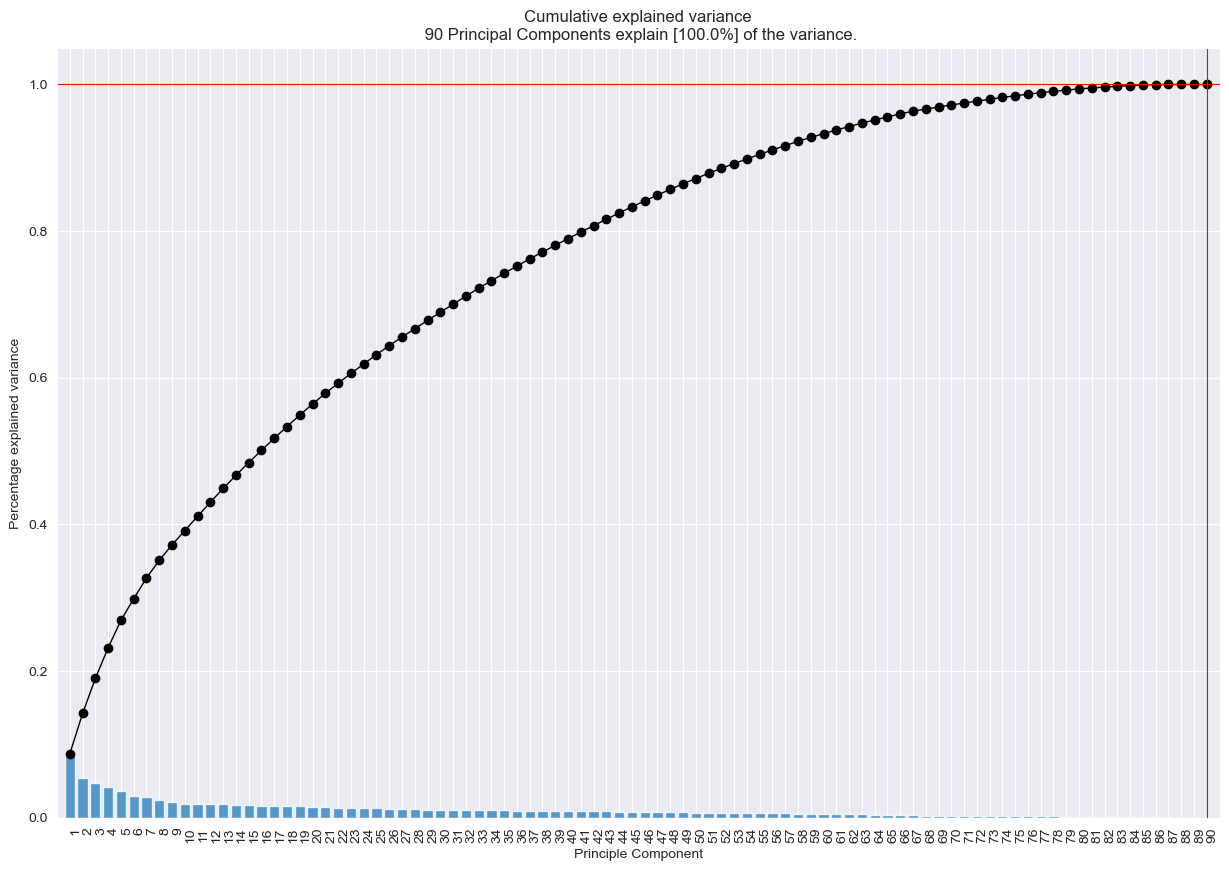

(<Figure size 1500x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Cumulative explained variance\n 90 Principal Components explain [100.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

In [1638]:
# Plot the explained variance
model_1.plot()

# Biplot con las cargas factoriales
#ax = model_1.biplot(legend=False, label=None)

Como se observa, con 10 componentes principales no se llega a explicar ni el 40% de la varianza de la muestra, por lo que optaremos por realizar de manera alternativa un modelo de Regresión Logística con todas las variables para ver si logramos mejorar la interpretación y, en segundo lugar, un modelo de XGBoost para buscar tambien aumentar la capacidad predictiva. 

# Modelo de Regresión Logística

A continuación se buscará conformar un modelo regresión logística múltiple a partir de las variables conformadas y obtenidas del dataset. Se realizará una búsqueda de los hiperparámetros más relevantes para compensar la diferencia de pesos en la varible a predecir, una identificación de las variables más relevantes mediante el método Recursive Feature Elimination y finalmente se analizará el área bajo la curva ROC. No se examinan los outliers puesto a que se considera a la regresión logística robusta frente a los valores extremos.

In [1639]:
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [1643]:
muestra = df_estandarizado

In [1644]:
muestra['clasebinaria'].value_counts(normalize = True)

0    0.776054
1    0.223946
Name: clasebinaria, dtype: float64

In [1645]:
muestra

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
0                         -0.395294                      -0.461724   
1                         -0.395294                      -0.461724   
2                         -0.395294                      -0.110639   
3                         -0.395294                       0.591531   
4                         -0.395294                      -0.461724   
...                             ...                            ...   
140610                    -0.395294                      -0.461724   
140611                    -0.395294                      -0.110639   
140612                    -0.156670                      -0.461724   
140613                    -0.156670                      -0.461724   
140614                    -0.156670                      -0.461724   

        ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
0                           -0.556841                    -0.586022   
1                           -0.556841                    -0.153765   
2                           -0.556841                    -0.586022   
3                            0.346581                    -0.586022   
4                           -0.556841                    -0.153765   
...                               ...                          ...   
140610                      -0.556841                    -0.153765   
140611                      -0.255700                    -0.586022   
140612                      -0.556841                    -0.586022   
140613                      -0.556841                    -0.586022   
140614                      -0.556841                    -0.586022   

        ccallcenter_transacciones  ccambio_monedas_compra  \
0                       -0.027467               -0.225684   
1                        0.064796               -0.225684   
2                        0.157058                1.682030   
3                        0.064796                1.682030   
4                       -0.396518               -0.225684   
...                           ...                     ...   
140610                  -0.396518               -0.225684   
140611                  -0.396518               -0.225684   
140612                  -0.396518               -0.225684   
140613                  -0.396518               -0.225684   
140614                  -0.396518               -0.225684   

        ccambio_monedas_venta  ccheques_depositados  \
0                   -0.255495             -0.251934   
1                   -0.255495             -0.251934   
2                   -0.255495             -0.251934   
3                   -0.255495             -0.251934   
4                   -0.255495             -0.251934   
...                       ...                   ...   
140610              -0.255495             -0.251934   
140611               1.900099             -0.251934   
140612              -0.255495             -0.251934   
140613              -0.255495             -0.251934   
140614              -0.255495             -0.251934   

        ccheques_depositados_rechazado  ccheques_emitidos  ...  \
0                            -0.094321          -0.238105  ...   
1                            -0.094321          -0.238105  ...   
2                            -0.094321          -0.238105  ...   
3                            -0.094321          -0.238105  ...   
4                            -0.094321          -0.238105  ...   
...                                ...                ...  ...   
140610                       -0.094321           0.089978  ...   
140611                       -0.094321          -0.238105  ...   
140612                       -0.094321           0.089978  ...   
140613                       -0.094321           0.089978  ...   
140614                       -0.094321          -0.238105  ...   

        visa_marca_atraso  visa_tadelantosefectivo  visa_tconsumos  \
0                   False                    False            True   

In [1646]:
x = muestra.drop(['clasebinaria', 'clasenum'], axis = 1)
y = muestra['clasebinaria']

## GridSearch

In [ ]:
#del log_clf
#del selector
del df_2
del df_af

Hago un GridSearch para encontrar los mejores hiperparámetros para mi modelo de regesión, considerando principalmente el desbalanceo entre la clase a predecir.

In [1648]:
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]

In [1650]:
##GridSearchCV


# # Find best hyperparameters (roc_auc)
# random_state = 42
# log_clf = LogisticRegression(random_state = random_state, max_iter = 3000)
# param_grid = {'class_weight' : w, 
#                 'penalty' : ['l2'],  
#                 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# grid = GridSearchCV(estimator = log_clf,
#                     param_grid = param_grid ,
#                     scoring = 'roc_auc',
#                     verbose = 1,
#                     n_jobs = -1,
#                     error_score = 'raise')
#start = time.time()
# grid.fit(x,y)
#end = time.time()
#print("La búsqueda con knn llevó: ", end - start, " segundos")
# print("Best Score:" + str(grid.best_score_))
# print("Best Parameters: " + str(grid.best_params_))
#print("La búsqueda con GridSearch llevó: ", end - start, " segundos")
# best_parameters = grid.best_params_

# Fitting 5 folds for each of 245 candidates, totalling 1225 fits
# Best Score:0.8674481838195561
# Best Parameters: {'C': 1000, 'class_weight': {0: 1.0, 1: 10}, 'penalty': 'l2'}

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
Best Score:0.8674481838195561
Best Parameters: {'C': 1000, 'class_weight': {0: 1.0, 1: 10}, 'penalty': 'l2'}


In [1653]:
best_parameters = {'C': 1000, 'class_weight': {0: 1.0,
                                               1: 10},
                   'penalty': 'l2'}#!!! Tardo como tres horas en correr

In [1676]:
log_clf = LogisticRegression(**best_parameters, max_iter = 3000)

#del log_clf
#log_clf.fit(x,y)

## Elección de atributos principales

Realizo un RFE (Recursive Feature Elimination) para seleccionar los mejores predictores para mi modelo de regresión logística.

In [1663]:
##tarda media hora en correr


#selector = RFE(log_clf)
#start = time.time()

#selector.fit(x,y)
#end = time.time()
#print("La búsqueda con RFE llevó: ", end - start, " segundos")

In [1674]:
columnas_seleccionadas_rfe = ['ccambio_monedas_compra', 'ccheques_depositados', 'ccheques_emitidos',
       'ccomisiones_mantenimiento', 'ccomisiones_otras',
       'cextraccion_autoservicio', 'cliente_antiguedad',
       'cprestamos_hipotecarios', 'cprestamos_personales',
       'cprestamos_prendarios', 'ctarjeta_debito_transacciones',
       'ctarjeta_visa_transacciones', 'marketing_coss_selling',
       'master_mpagospesos', 'master_msaldodolares', 'master_msaldopesos',
       'master_msaldototal', 'mautoservicio', 'mcaja_ahorro_dolares',
       'mcuentas_saldo', 'mfondos_comunes_inversion_dola', 'mplan_sueldo',
       'mprestamos_personales', 'mrentabilidad', 'mrentabilidad_annual',
       'mtarjeta_master_descuentos', 'mtarjeta_visa_consumo',
       'mtarjeta_visa_descuentos', 'mtitulos', 'visa_madelantopesos',
       'visa_mconsumosdolares', 'visa_mconsumospesos', 'visa_mconsumototal',
       'visa_mpagado', 'visa_msaldodolares', 'visa_msaldopesos',
       'visa_msaldototal', 'cliente_vip', 'master_marca_atraso',
       'master_tadelantosefectivo', 'master_tconsumos', 'tautoservicio',
       'tcaja_seguridad', 'tcallcenter', 'tcambio_monedas',
       'tcuenta_corriente', 'tcuenta_debitos_automaticos',
       'tfondos_comunes_inversion', 'tmovimientos_ultimos90dias',
       'tpagodeservicios', 'tplan_sueldo', 'tseguro_accidentes_personales',
       'tseguro_auto', 'tseguro_vida_mercado_abierto', 'tseguro_vivienda',
       'ttarjeta_master_debitos_automa', 'ttarjeta_visa_debitos_automati',
       'ttitulos', 'visa_marca_atraso', 'visa_tadelantosefectivo',
       'visa_tconsumos', 'tprestamos_hipotecarios', 'ttarjeta_ambas',
       'ttarjeta_ninguna', 'ttarjeta_visa']


## Entrenamiento y validación del modelo mediante la métrica del AUC de  ROC

**JUSTIFICAR PORQUE VOY A USAR EL ÁREA BAJO LA CURVA ROC**

In [1677]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [1678]:
X_train_sel_features_logit = X_train.T[list(selector.support_)].T
X_test_sel_features_logit = X_test.T[list(selector.support_)].T
log_clf.fit(X_train_sel_features_logit,y_train.ravel())
y_pred = log_clf.predict(X_test_sel_features_logit)

In [1679]:
len(X_train_sel_features_logit.columns)

65

In [1680]:
X_train_sel_features_logit.columns

Index(['ccambio_monedas_compra', 'ccheques_depositados', 'ccheques_emitidos',
       'ccomisiones_mantenimiento', 'ccomisiones_otras',
       'cextraccion_autoservicio', 'cliente_antiguedad',
       'cprestamos_hipotecarios', 'cprestamos_personales',
       'cprestamos_prendarios', 'ctarjeta_debito_transacciones',
       'ctarjeta_visa_transacciones', 'marketing_coss_selling',
       'master_mpagospesos', 'master_msaldodolares', 'master_msaldopesos',
       'master_msaldototal', 'mautoservicio', 'mcaja_ahorro_dolares',
       'mcuentas_saldo', 'mfondos_comunes_inversion_dola', 'mplan_sueldo',
       'mprestamos_personales', 'mrentabilidad', 'mrentabilidad_annual',
       'mtarjeta_master_descuentos', 'mtarjeta_visa_consumo',
       'mtarjeta_visa_descuentos', 'mtitulos', 'visa_madelantopesos',
       'visa_mconsumosdolares', 'visa_mconsumospesos', 'visa_mconsumototal',
       'visa_mpagado', 'visa_msaldodolares', 'visa_msaldopesos',
       'visa_msaldototal', 'cliente_vip', 'master_mar

In [1681]:
tasa_falsos_positivos, tasa_verdaderos_positivos, thresholds= metrics.roc_curve(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.56      0.71     31948
           1       0.38      0.95      0.55      9205

    accuracy                           0.65     41153
   macro avg       0.68      0.76      0.63     41153
weighted avg       0.84      0.65      0.67     41153



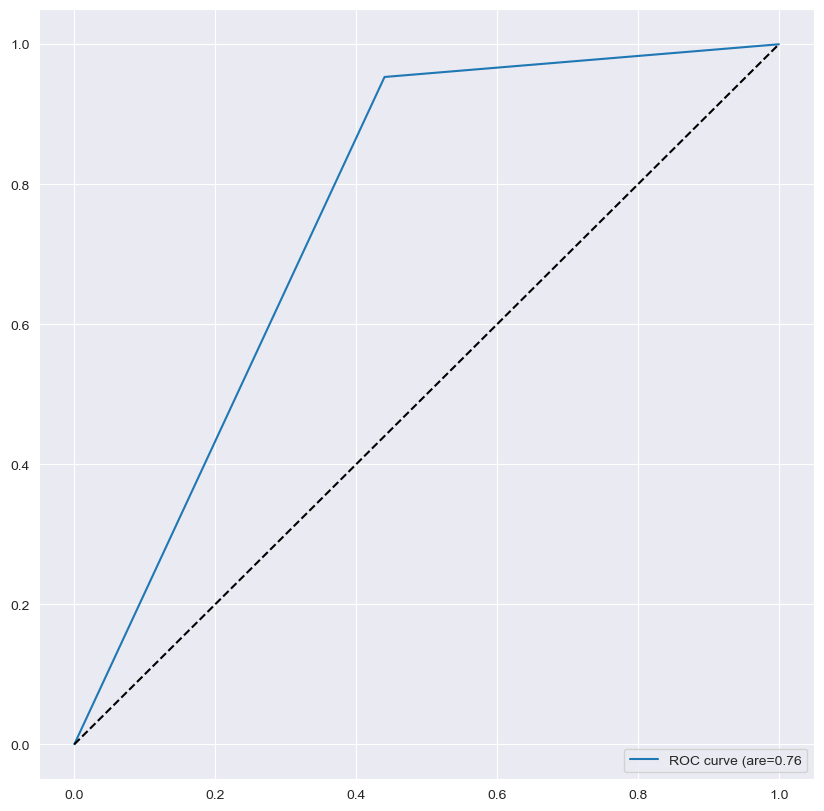

In [1682]:
roc_auc = metrics.auc(tasa_falsos_positivos,
                      tasa_verdaderos_positivos)


plt.clf()
plt.plot(tasa_falsos_positivos, tasa_verdaderos_positivos, label = "ROC curve (are=%0.2f"% roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.legend(loc = 'lower right')

plt.show()

# Otros modelos de clasificación: KNN, Random Forest, XGBoost, LightGBM y CatBoost

In [1683]:
from sklearn.preprocessing import LabelEncoder

In [1686]:
y = df_estandarizado["clasebinaria"]
X = df_estandarizado.drop(["clasebinaria", 'clasenum'], axis = 1)


Usamos LabelEncoder para transformar la clase en un array de 0 y 1

In [1687]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Con la información de train se realiza la búsqueda de hiperparámetros para ajustar el mejor modelo.

In [1688]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

## Knn - Benchmark

In [1689]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
import numpy as np
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [1690]:
model = KNeighborsClassifier()

In [1691]:
params = {"n_neighbors":list(range(3,8))}

In [1692]:
knn = GridSearchCV(model, params, verbose= True)

In [1694]:
start = time.time()
knn.fit(X_train, y_train)
end = time.time()
print("La búsqueda con knn llevó: ", end - start, " segundos")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

La búsqueda con knn llevó:  713.0662369728088  segundos


In [1695]:
knn.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [1696]:
y_predicted_knn = knn.predict_proba(X_test)
knn_auc = roc_auc_score(y_test, y_predicted_knn[:,1])
print("El valor del AUC es: ", knn_auc)

El valor del AUC es:  0.7691579101146641


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

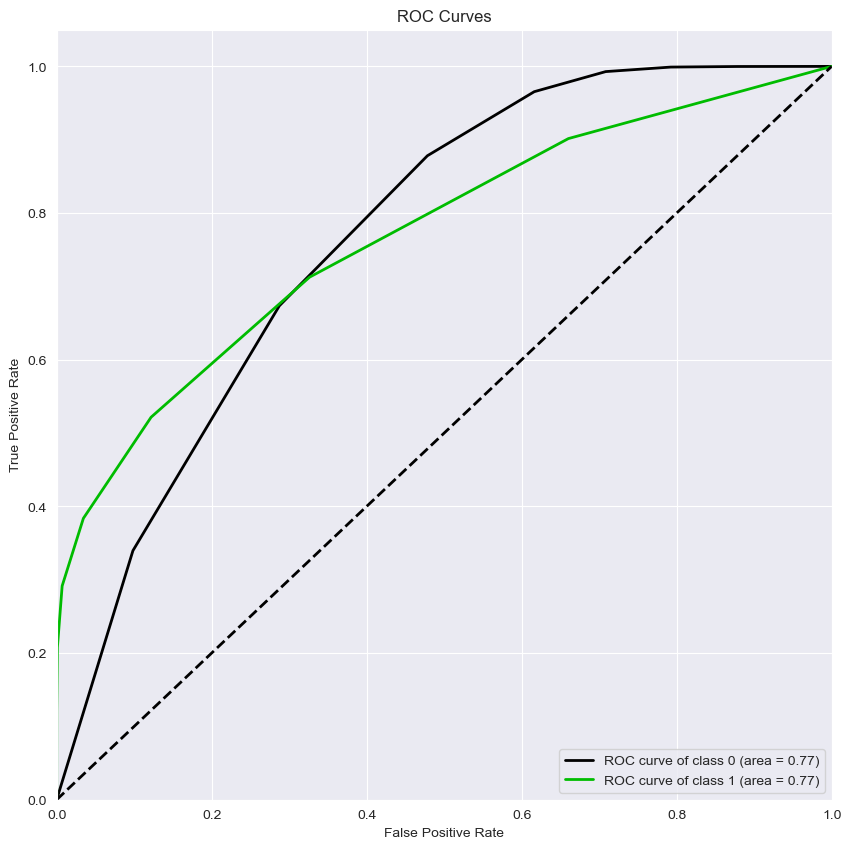

In [1697]:
%matplotlib inline
plot_roc(y_test,y_predicted_knn, plot_micro = False, plot_macro= False)

Tomando como benchmark la regresión logística antes utilizada y el modelo de clasificación de KNN podemos ver que no existe mucha diferencia en el AUC (0.76 en el primer caso y 0.77 en el segundo). Probaremos ahora ver que pasa con algunos modelos de árboles con búsqueda de hiperparámetros aleatoria.

## Random Forest

In [1698]:
from sklearn.ensemble import RandomForestClassifier

In [1699]:
model = RandomForestClassifier()

In [1700]:
import scipy.stats as st

In [1701]:
params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12)     # Maximum tree depth for base learners.
}

In [1702]:
rf = RandomizedSearchCV(model,params, n_iter=25, verbose= True)

In [1703]:
start = time.time()
rf.fit(X_train,y_train)
end = time.time()
print("La búsqueda con Random Forest llevó: ", end - start, " segundos")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
La búsqueda con Random Forest llevó:  452.9124541282654  segundos


In [1704]:
y_predicted_rf = rf.predict_proba(X_test)

In [1705]:
rf_auc = roc_auc_score(y_test,y_predicted_rf[:,1])
print("El valor del AUC es: ", rf_auc)

El valor del AUC es:  0.9443907430065004


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

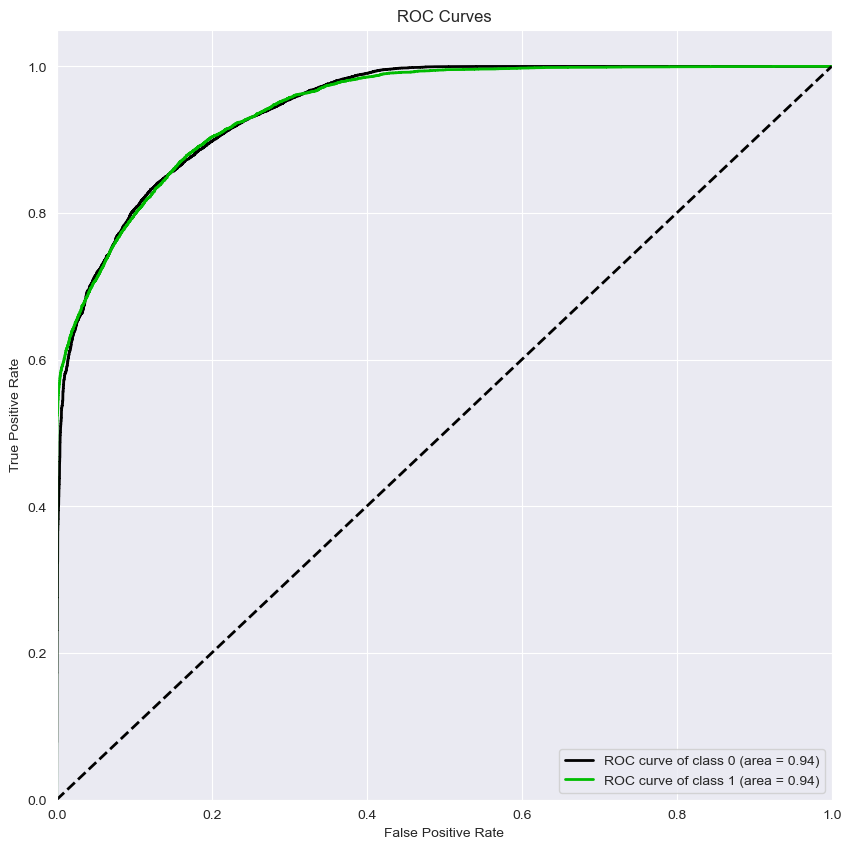

In [1707]:
%matplotlib inline
plot_roc(y_test,y_predicted_rf, plot_micro = False, plot_macro= False)

Es notable cómo aumenta nuestra métrica utilizando el primer método de árboles, así como el menor tiempo consumido. Ahora intentaremos implementar los otros y compararemos los resultados.

## Xgboost

In [1710]:
from xgboost import XGBClassifier

In [1711]:
model = XGBClassifier()

In [1712]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [1713]:
params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

In [1714]:
xgb = RandomizedSearchCV(model,params, n_iter=25, verbose= True)

In [1715]:
start = time.time()
xgb.fit(X_train,y_train)
end = time.time()
print("La búsqueda con XGBoost llevó: ", end - start, " segundos")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
La búsqueda con XGBoost llevó:  788.4520316123962  segundos


In [1716]:
opt_xgb = xgb.best_estimator_

In [1717]:
y_predicted_xgb = opt_xgb.predict_proba(X_test)

In [1718]:
y_predicted_xgb[:,0].shape

(34294,)

In [1719]:
xgb_auc = roc_auc_score(y_test,y_predicted_xgb[:,1])
print("El valor del AUC es: ", xgb_auc)

El valor del AUC es:  0.9773673928861063


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

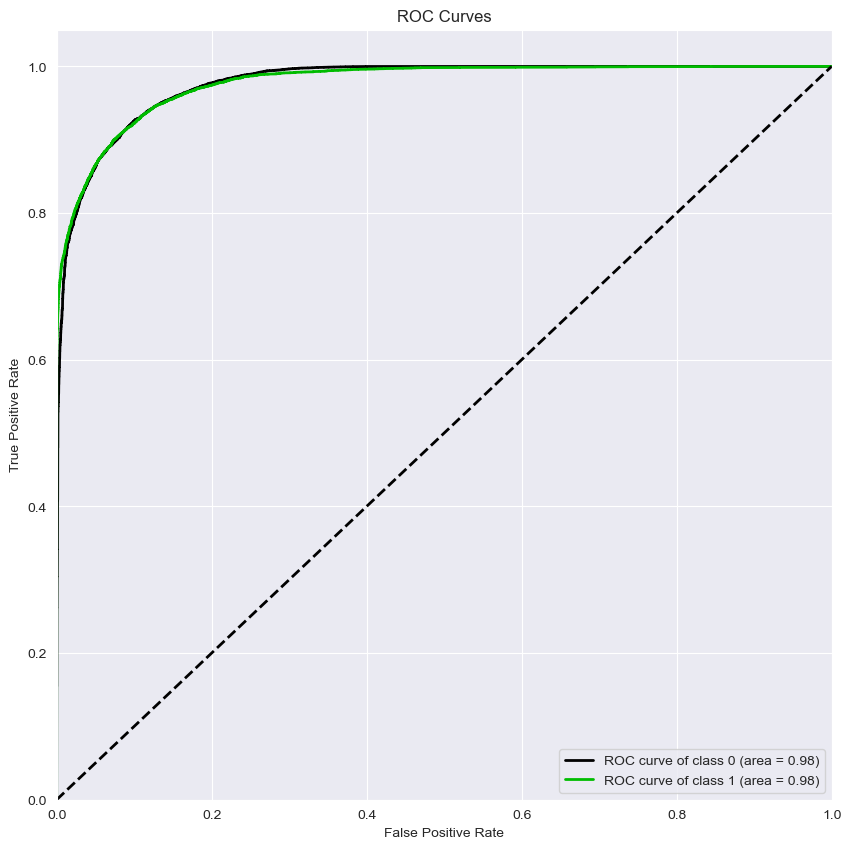

In [1720]:
plot_roc(y_test,y_predicted_xgb, plot_micro = False, plot_macro= False)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

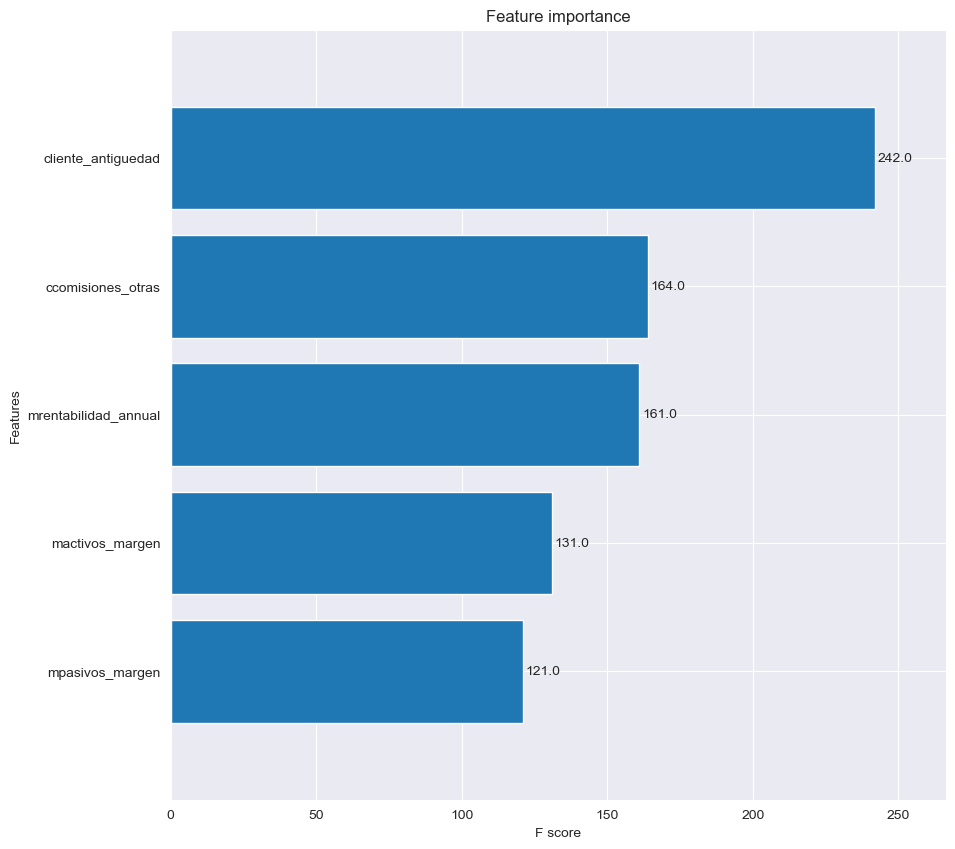

In [1721]:
from xgboost import plot_importance
plot_importance(opt_xgb, height = 0.8,max_num_features=5)

A diferencia de las variables seleccionadas antes con REF, los principales atributos según el modelo XGboost son:
- Antigüedad del Cliente
- Cantidad de Comisiones (Otras)
- Monto de Rentabilidad Anual
- Monto de Margen de Activos
- Monto de Margen de Pasivos

In [1722]:
print(opt_xgb.feature_importances_)

[0.00086203 0.0013097  0.00197647 0.00098061 0.00098542 0.00223765
 0.00079158 0.0009206  0.         0.002358   0.         0.01088694
 0.01877008 0.00353103 0.00110906 0.02150777 0.0013733  0.
 0.00543926 0.00324044 0.00334707 0.00155031 0.00835965 0.02448814
 0.01193458 0.06253655 0.00091628 0.         0.0042087  0.00354356
 0.         0.00129827 0.00199261 0.00196273 0.         0.00311444
 0.00154133 0.00349575 0.01848939 0.0034644  0.0010562  0.00260522
 0.00337095 0.00104375 0.00091676 0.00481023 0.0021572  0.00106201
 0.0020473  0.00135931 0.         0.         0.00428211 0.0035926
 0.00377931 0.00279785 0.00179387 0.         0.00191588 0.00221887
 0.00092309 0.01287845 0.00811337 0.         0.         0.
 0.00288212 0.00154749 0.00112039 0.00160767 0.00221646 0.00574968
 0.00576686 0.0421013  0.00558475 0.00173272 0.0014792  0.
 0.00189429 0.00253744 0.         0.         0.         0.00315604
 0.00163205 0.00467109 0.00060254 0.01101145 0.00234136 0.00365348
 0.11774064 0.      

## LightGBM

In [1725]:
#!pip install lightgbm

In [1726]:
import lightgbm as lgb

In [1727]:
model = lgb.LGBMClassifier()

Usamos los mismos rangos de hiperparámetros que para XGBoost.

In [1728]:
lgbm = RandomizedSearchCV(model, params, n_iter = 25, verbose= True)

In [1729]:
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print("La búsqueda con LightGBM llevó: ", end - start, " segundos")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warnin

In [1730]:
print('Best parameters found by grid search are:', lgbm.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 0.8691874850228095, 'gamma': 5.781460836930435, 'learning_rate': 0.3063596847093407, 'max_depth': 9, 'min_child_weight': 14.514197136540211, 'n_estimators': 35, 'reg_alpha': 5.522590366232462, 'subsample': 0.9572332978263635}


In [1731]:
opt_lgbm = lgbm.best_estimator_

In [1732]:
y_predicted_lgbm = opt_lgbm.predict_proba(X_test)

In [1733]:
lgbm_auc = roc_auc_score(y_test,y_predicted_lgbm[:,1])
print("El valor del AUC es: ", lgbm_auc)

El valor del AUC es:  0.9755715144832919


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

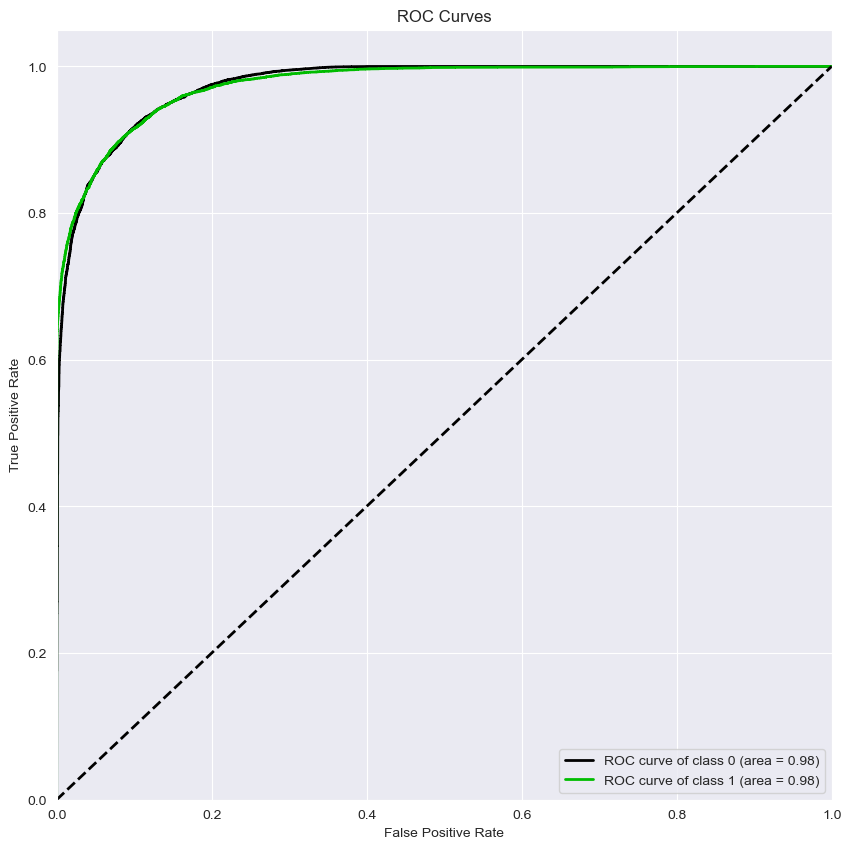

In [1734]:
plot_roc(y_test,y_predicted_lgbm, plot_micro = False, plot_macro= False)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

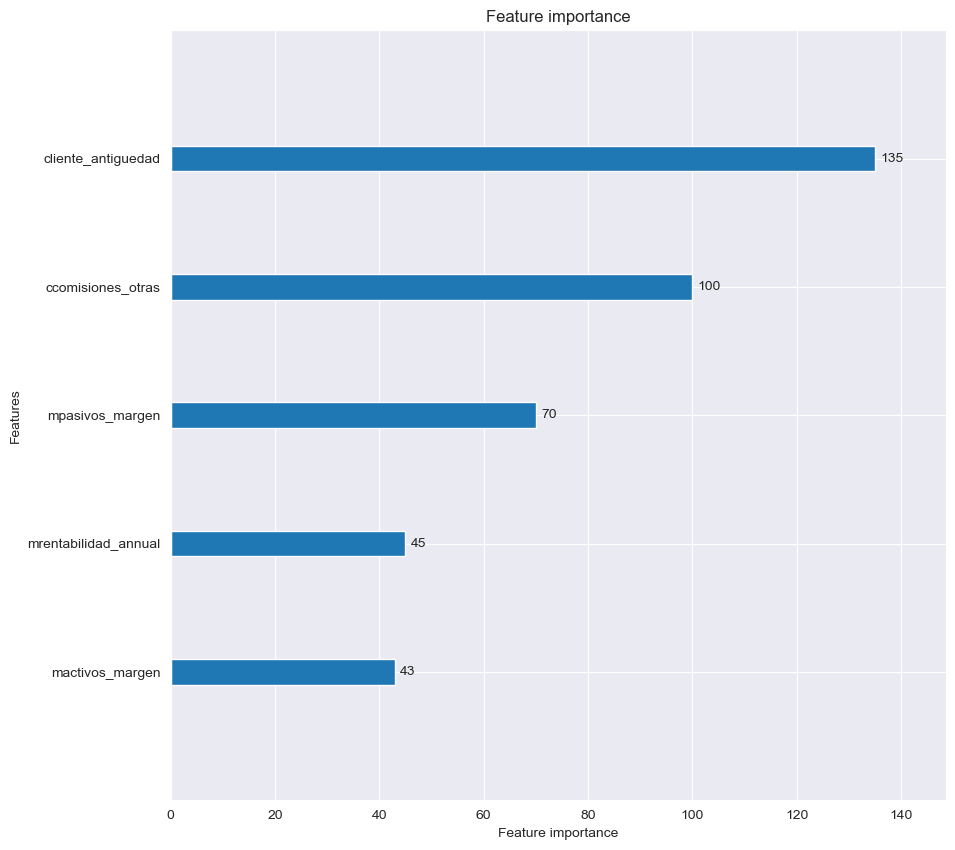

In [1735]:
lgb.plot_importance(opt_lgbm, max_num_features=5)

Vemos que aparecen los mismos atributos, pero en distinto orden de importancia

In [1736]:
opt_lgbm.feature_importances_

array([  3,   1,   1,   2,   2,   0,   1,   0,   0,   2,   0,  21, 100,
        10,  10, 135,   6,   0,   2,   9,   1,  12,   6,   4,  10,  22,
         1,   0,  43,  26,   0,   3,   0,   6,   0,  19,   0,   6,   8,
        19,   4,   2,  40,   3,   2,   5,   3,   2,   1,   3,   0,   0,
        25,   7,  26,   2,   7,   0,   1,   1,   5,  70,  39,   0,   0,
         0,   6,  16,   1,  32,  45,   7,   9,  23,  18,   2,   0,   0,
         6,   2,   0,   0,   0,  13,   8,   8,   0,  21,   0,  17,  23,
         1,   0,   0,   6,   0,   0,   0,   2,   1,   1,   2,   2,   1,
         2,   2,   0,   0,   2,   2,   0,   0,   0,   0,   0,   0,   0,
         4,   5,   0,   0,   2,   0,   1,  11,   6,   0,   1,   0,   0,
         0])

## CatBoost

In [1739]:
#!pip install catboost

from catboost import CatBoostClassifier

In [1740]:
cat = CatBoostClassifier()

In [1741]:
cat.fit(X_train, y_train)

Learning rate set to 0.074508
0:	learn: 0.6111551	total: 193ms	remaining: 3m 12s
1:	learn: 0.5364890	total: 223ms	remaining: 1m 51s
2:	learn: 0.4784028	total: 247ms	remaining: 1m 22s
3:	learn: 0.4269818	total: 271ms	remaining: 1m 7s
4:	learn: 0.4009638	total: 296ms	remaining: 58.9s
5:	learn: 0.3836009	total: 318ms	remaining: 52.7s
6:	learn: 0.3660890	total: 344ms	remaining: 48.7s
7:	learn: 0.3529828	total: 368ms	remaining: 45.7s
8:	learn: 0.3361477	total: 395ms	remaining: 43.5s
9:	learn: 0.3179204	total: 425ms	remaining: 42.1s
10:	learn: 0.3107757	total: 452ms	remaining: 40.6s
11:	learn: 0.3022086	total: 476ms	remaining: 39.2s
12:	learn: 0.2962391	total: 502ms	remaining: 38.1s
13:	learn: 0.2843114	total: 526ms	remaining: 37s
14:	learn: 0.2794891	total: 551ms	remaining: 36.2s
15:	learn: 0.2732402	total: 577ms	remaining: 35.5s
16:	learn: 0.2683885	total: 602ms	remaining: 34.8s
17:	learn: 0.2639485	total: 630ms	remaining: 34.4s
18:	learn: 0.2606024	total: 657ms	remaining: 33.9s
19:	learn:

160:	learn: 0.1719769	total: 4.84s	remaining: 25.2s
161:	learn: 0.1717780	total: 4.88s	remaining: 25.2s
162:	learn: 0.1712731	total: 4.91s	remaining: 25.2s
163:	learn: 0.1711660	total: 4.93s	remaining: 25.1s
164:	learn: 0.1709905	total: 4.96s	remaining: 25.1s
165:	learn: 0.1708538	total: 4.99s	remaining: 25.1s
166:	learn: 0.1706843	total: 5.02s	remaining: 25s
167:	learn: 0.1702604	total: 5.06s	remaining: 25.1s
168:	learn: 0.1699433	total: 5.1s	remaining: 25.1s
169:	learn: 0.1698625	total: 5.12s	remaining: 25s
170:	learn: 0.1696150	total: 5.16s	remaining: 25s
171:	learn: 0.1693857	total: 5.19s	remaining: 25s
172:	learn: 0.1691743	total: 5.22s	remaining: 25s
173:	learn: 0.1689532	total: 5.26s	remaining: 25s
174:	learn: 0.1687979	total: 5.29s	remaining: 24.9s
175:	learn: 0.1686497	total: 5.32s	remaining: 24.9s
176:	learn: 0.1685184	total: 5.35s	remaining: 24.9s
177:	learn: 0.1683816	total: 5.38s	remaining: 24.8s
178:	learn: 0.1679968	total: 5.41s	remaining: 24.8s
179:	learn: 0.1678366	tot

320:	learn: 0.1479640	total: 9.65s	remaining: 20.4s
321:	learn: 0.1478803	total: 9.68s	remaining: 20.4s
322:	learn: 0.1478316	total: 9.71s	remaining: 20.4s
323:	learn: 0.1476126	total: 9.75s	remaining: 20.3s
324:	learn: 0.1475407	total: 9.78s	remaining: 20.3s
325:	learn: 0.1474452	total: 9.8s	remaining: 20.3s
326:	learn: 0.1473799	total: 9.83s	remaining: 20.2s
327:	learn: 0.1473306	total: 9.86s	remaining: 20.2s
328:	learn: 0.1472653	total: 9.89s	remaining: 20.2s
329:	learn: 0.1471688	total: 9.92s	remaining: 20.1s
330:	learn: 0.1470781	total: 9.95s	remaining: 20.1s
331:	learn: 0.1470100	total: 9.97s	remaining: 20.1s
332:	learn: 0.1468966	total: 10s	remaining: 20s
333:	learn: 0.1468034	total: 10s	remaining: 20s
334:	learn: 0.1466347	total: 10.1s	remaining: 20s
335:	learn: 0.1465693	total: 10.1s	remaining: 20s
336:	learn: 0.1463697	total: 10.1s	remaining: 19.9s
337:	learn: 0.1463169	total: 10.2s	remaining: 19.9s
338:	learn: 0.1462545	total: 10.2s	remaining: 19.9s
339:	learn: 0.1460712	tot

480:	learn: 0.1352782	total: 14.5s	remaining: 15.7s
481:	learn: 0.1352469	total: 14.6s	remaining: 15.6s
482:	learn: 0.1352010	total: 14.6s	remaining: 15.6s
483:	learn: 0.1351742	total: 14.6s	remaining: 15.6s
484:	learn: 0.1350989	total: 14.7s	remaining: 15.6s
485:	learn: 0.1350378	total: 14.7s	remaining: 15.5s
486:	learn: 0.1349944	total: 14.7s	remaining: 15.5s
487:	learn: 0.1349341	total: 14.7s	remaining: 15.5s
488:	learn: 0.1348608	total: 14.8s	remaining: 15.4s
489:	learn: 0.1347737	total: 14.8s	remaining: 15.4s
490:	learn: 0.1346941	total: 14.8s	remaining: 15.4s
491:	learn: 0.1346812	total: 14.8s	remaining: 15.3s
492:	learn: 0.1346098	total: 14.9s	remaining: 15.3s
493:	learn: 0.1345839	total: 14.9s	remaining: 15.3s
494:	learn: 0.1344325	total: 14.9s	remaining: 15.2s
495:	learn: 0.1344106	total: 15s	remaining: 15.2s
496:	learn: 0.1343844	total: 15s	remaining: 15.2s
497:	learn: 0.1341597	total: 15s	remaining: 15.2s
498:	learn: 0.1340713	total: 15.1s	remaining: 15.1s
499:	learn: 0.1340

644:	learn: 0.1257351	total: 19.7s	remaining: 10.8s
645:	learn: 0.1255768	total: 19.7s	remaining: 10.8s
646:	learn: 0.1255416	total: 19.7s	remaining: 10.8s
647:	learn: 0.1255100	total: 19.8s	remaining: 10.7s
648:	learn: 0.1254595	total: 19.8s	remaining: 10.7s
649:	learn: 0.1254261	total: 19.8s	remaining: 10.7s
650:	learn: 0.1253828	total: 19.9s	remaining: 10.6s
651:	learn: 0.1253075	total: 19.9s	remaining: 10.6s
652:	learn: 0.1252193	total: 19.9s	remaining: 10.6s
653:	learn: 0.1251502	total: 19.9s	remaining: 10.6s
654:	learn: 0.1250018	total: 20s	remaining: 10.5s
655:	learn: 0.1249163	total: 20s	remaining: 10.5s
656:	learn: 0.1248831	total: 20.1s	remaining: 10.5s
657:	learn: 0.1248547	total: 20.1s	remaining: 10.4s
658:	learn: 0.1248087	total: 20.1s	remaining: 10.4s
659:	learn: 0.1247218	total: 20.2s	remaining: 10.4s
660:	learn: 0.1246889	total: 20.2s	remaining: 10.4s
661:	learn: 0.1246432	total: 20.2s	remaining: 10.3s
662:	learn: 0.1246080	total: 20.3s	remaining: 10.3s
663:	learn: 0.12

803:	learn: 0.1180906	total: 25.1s	remaining: 6.11s
804:	learn: 0.1180667	total: 25.1s	remaining: 6.08s
805:	learn: 0.1180342	total: 25.1s	remaining: 6.05s
806:	learn: 0.1179855	total: 25.2s	remaining: 6.02s
807:	learn: 0.1179306	total: 25.2s	remaining: 5.99s
808:	learn: 0.1179125	total: 25.2s	remaining: 5.96s
809:	learn: 0.1178901	total: 25.3s	remaining: 5.93s
810:	learn: 0.1178555	total: 25.3s	remaining: 5.9s
811:	learn: 0.1178228	total: 25.4s	remaining: 5.87s
812:	learn: 0.1178222	total: 25.4s	remaining: 5.84s
813:	learn: 0.1177893	total: 25.4s	remaining: 5.81s
814:	learn: 0.1177427	total: 25.5s	remaining: 5.78s
815:	learn: 0.1176526	total: 25.5s	remaining: 5.75s
816:	learn: 0.1176120	total: 25.6s	remaining: 5.72s
817:	learn: 0.1175999	total: 25.6s	remaining: 5.69s
818:	learn: 0.1175761	total: 25.6s	remaining: 5.67s
819:	learn: 0.1175488	total: 25.7s	remaining: 5.63s
820:	learn: 0.1174587	total: 25.7s	remaining: 5.61s
821:	learn: 0.1174239	total: 25.8s	remaining: 5.58s
822:	learn: 0

967:	learn: 0.1120081	total: 31s	remaining: 1.02s
968:	learn: 0.1119796	total: 31s	remaining: 993ms
969:	learn: 0.1119510	total: 31.1s	remaining: 961ms
970:	learn: 0.1119278	total: 31.1s	remaining: 928ms
971:	learn: 0.1118982	total: 31.1s	remaining: 896ms
972:	learn: 0.1118595	total: 31.2s	remaining: 865ms
973:	learn: 0.1118316	total: 31.2s	remaining: 832ms
974:	learn: 0.1118035	total: 31.2s	remaining: 800ms
975:	learn: 0.1116717	total: 31.3s	remaining: 769ms
976:	learn: 0.1116424	total: 31.3s	remaining: 737ms
977:	learn: 0.1116132	total: 31.3s	remaining: 705ms
978:	learn: 0.1115666	total: 31.4s	remaining: 673ms
979:	learn: 0.1115275	total: 31.4s	remaining: 641ms
980:	learn: 0.1114887	total: 31.4s	remaining: 609ms
981:	learn: 0.1114498	total: 31.5s	remaining: 577ms
982:	learn: 0.1114493	total: 31.5s	remaining: 545ms
983:	learn: 0.1114274	total: 31.5s	remaining: 513ms
984:	learn: 0.1114203	total: 31.5s	remaining: 480ms
985:	learn: 0.1113746	total: 31.6s	remaining: 448ms
986:	learn: 0.11

In [1742]:
y_predicted_cat = cat.predict_proba(X_test)

In [1746]:
cat.feature_importances_

array([5.39322605e-02, 5.90184525e-02, 3.12882321e-02, 7.74192346e-02,
       5.86121799e-02, 2.41545799e-02, 4.49204156e-02, 4.84861523e-02,
       1.91654857e-03, 8.97443415e-02, 1.44620504e-03, 1.14617430e+00,
       1.90919975e+01, 3.82620810e-01, 3.17286021e-01, 2.05861602e+01,
       3.37551527e-01, 0.00000000e+00, 1.16596256e-01, 9.10671505e-01,
       5.08287706e-02, 3.45682213e-01, 2.64635573e-01, 2.44311211e-01,
       4.27715723e-01, 2.48888281e+00, 2.13388568e-02, 1.20283633e-04,
       1.97594381e+00, 1.41591164e+00, 2.31381946e-02, 9.55236953e-02,
       3.88370926e-02, 8.96626864e-02, 1.12387403e-02, 4.74017393e-01,
       1.45111452e-02, 5.23244857e-01, 6.58285283e-01, 6.26118463e-01,
       2.14883608e-01, 3.24204955e-02, 2.89274616e+00, 1.98694135e-01,
       8.93520607e-02, 1.17527365e-01, 1.88782358e-01, 7.51174019e-02,
       3.11301008e-02, 7.10281714e-02, 9.91704506e-03, 2.98310791e-03,
       7.46229628e-01, 1.12990397e+00, 1.01812650e+00, 3.99656018e-02,
      

In [1743]:
cat_auc = roc_auc_score(y_test,y_predicted_cat[:,1])
print("El valor del AUC es: ", cat_auc)

El valor del AUC es:  0.9813988339861853


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

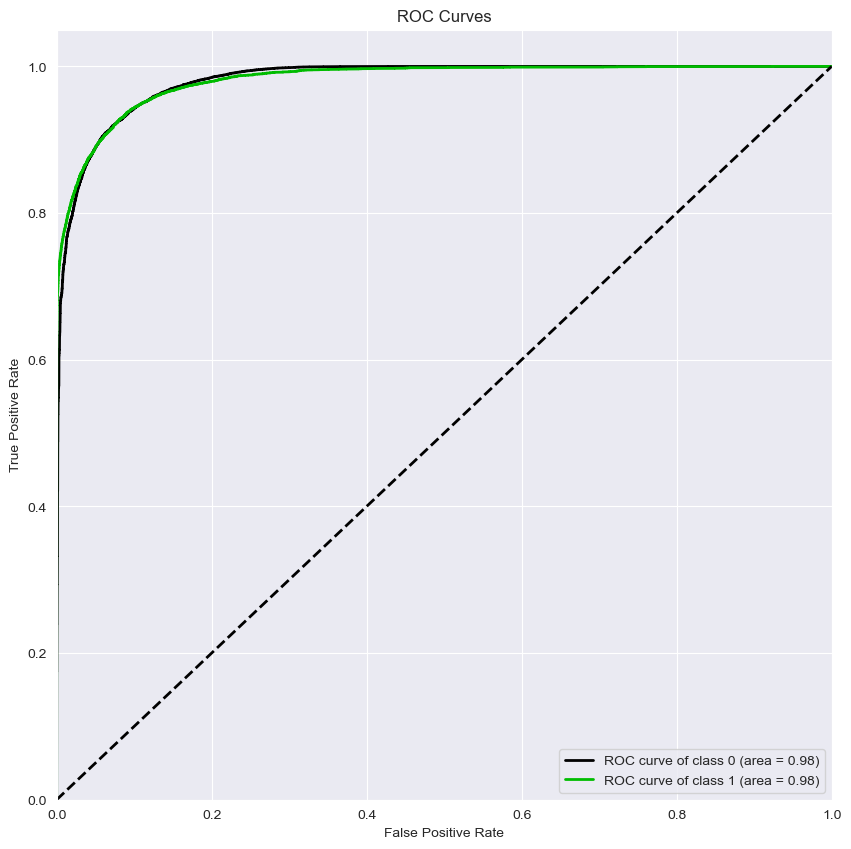

In [1744]:
plot_roc(y_test,y_predicted_cat, plot_micro = False, plot_macro= False)

## Conclusiones

In [1745]:
print("Los resultados finales fueron:\n - AUC de knn:", knn_auc," \n - AUC de RF:", rf_auc, " \n - AUC de XGBoost:", xgb_auc,
     "\n - AUC de LightGBM:", lgbm_auc, "\n - AUC de CatBoost:", cat_auc)

Los resultados finales fueron:
 - AUC de knn: 0.7691579101146641  
 - AUC de RF: 0.9443907430065004  
 - AUC de XGBoost: 0.9773673928861063 
 - AUC de LightGBM: 0.9755715144832919 
 - AUC de CatBoost: 0.9813988339861853


# Comparación con Set de Validación

In [1885]:
path_validacion = 'input/Base_Validacion.csv'

In [1886]:
df_validacion = pd.read_csv(path_validacion, index_col = 0)

In [1887]:
df_validacion = df_validacion.replace({'':np.nan,
                 ' ':np.nan}, regex = True)

In [1888]:
df_validacion = df_validacion.drop(filter_col_infla, axis = 1).drop(filter_col_esta, axis = 1)

In [1889]:
df_validacion = df_validacion.drop(['VISA_FECHAALTA', 'VISA_FINICIOMORA', 'MASTER_FINICIOMORA'], axis = 1)

In [1890]:
df_validacion['VISA_CUENTA_ESTADO'] = df_validacion['VISA_CUENTA_ESTADO'].map(estado_tarjeta_mapper)
df_validacion['MASTER_CUENTA_ESTADO'] = df_validacion['MASTER_CUENTA_ESTADO'].map(estado_tarjeta_mapper)

In [1891]:
df_validacion[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']] = df_validacion[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']].replace({'sin_datos':'no_posee_tarjeta'})

In [1892]:
df_validacion.loc[df['MASTER_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_master'] = False
df_validacion.loc[df['VISA_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_visa'] = False
df_validacion[['tiene_visa', 'tiene_master']] = df_validacion[['tiene_visa', 'tiene_master']].fillna(True)

visa_cols = [col for col in df if 'VISA' in col]
master_cols = [col for col in df if 'MASTER' in col]
df[visa_cols] = df[visa_cols].fillna(0)
df[master_cols] = df[master_cols].fillna(0)

In [1893]:
df_validacion['CPRESTAMOS_HIPOTECARIOS'] = df_validacion['CPRESTAMOS_HIPOTECARIOS'].astype(np.int8)

In [1894]:
df_validacion['MPRESTAMOS_HIPOTECARIOS'] = df_validacion['MPRESTAMOS_HIPOTECARIOS'].fillna(-1).astype(int)

In [1895]:
len(df_validacion[df_validacion['MPRESTAMOS_HIPOTECARIOS'] == -1])

24

Se procede a descartar las observaciones como se hizo en la ETL inicial.

In [1896]:
df_validacion = df_validacion[df_validacion['MPRESTAMOS_HIPOTECARIOS'] != -1]

In [1897]:
df_validacion.loc[(df_validacion['CPRESTAMOS_HIPOTECARIOS'] != 0) &
  ((df_validacion['MPRESTAMOS_HIPOTECARIOS'] == 0)), 'CPRESTAMOS_HIPOTECARIOS'] = 0

df_validacion.loc[df_validacion['CPRESTAMOS_HIPOTECARIOS'] != 0, 'TPRESTAMOS_HIPOTECARIOS'] = True
df_validacion['TPRESTAMOS_HIPOTECARIOS'] = df_validacion['TPRESTAMOS_HIPOTECARIOS'].fillna(False)

In [1898]:
df_validacion = df_validacion.drop(['MCAJEROS_PROPIOS_DESCUENTOS'], axis = 1)

In [1899]:
df_validacion = df_validacion.replace({'S':True, 'N':False})
df_validacion[['MACTIVOS_MARGEN', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MPAGADO', 'MASTER_MPAGOSDOLARES',
       'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MPASIVOS_MARGEN', 'MRENTABILIDAD',
       'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS',
       'VISA_MARCA_ATRASO', 'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGOSDOLARES',
       'VISA_MPAGOSPESOS', 'VISA_MSALDODOLARES', 'VISA_MSALDOPESOS',
       'VISA_MSALDOTOTAL']] = df_validacion[['MACTIVOS_MARGEN', 'MASTER_MARCA_ATRASO',
       'MASTER_MCONSUMOSDOLARES', 'MASTER_MCONSUMOSPESOS',
       'MASTER_MCONSUMOTOTAL', 'MASTER_MPAGADO', 'MASTER_MPAGOSDOLARES',
       'MASTER_MPAGOSPESOS', 'MASTER_MSALDODOLARES', 'MASTER_MSALDOPESOS',
       'MASTER_MSALDOTOTAL', 'MPASIVOS_MARGEN', 'MRENTABILIDAD',
       'VISA_MADELANTODOLARES', 'VISA_MADELANTOPESOS',
       'VISA_MARCA_ATRASO', 'VISA_MCONSUMOSDOLARES', 'VISA_MCONSUMOSPESOS',
       'VISA_MCONSUMOTOTAL', 'VISA_MPAGADO', 'VISA_MPAGOSDOLARES',
       'VISA_MPAGOSPESOS', 'VISA_MSALDODOLARES', 'VISA_MSALDOPESOS',
       'VISA_MSALDOTOTAL']].astype(float)

df_validacion[filter_col_cantidad] = df_validacion[filter_col_cantidad].astype(np.int8)

df_validacion['CLIENTE_VIP'] = df_validacion['CLIENTE_VIP'].astype(bool)
df_validacion['MASTER_MARCA_ATRASO'] = df_validacion['MASTER_MARCA_ATRASO'].astype(bool)
df_validacion['VISA_MARCA_ATRASO'] = df_validacion['VISA_MARCA_ATRASO'].astype(bool)
df_validacion['CLIENTE_SUCURSAL'] = df_validacion['CLIENTE_SUCURSAL'].astype(str).apply(lambda x: 'sucursal_'+x)

In [1900]:
df_validacion[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']] = df_validacion[['VISA_CUENTA_ESTADO', 'MASTER_CUENTA_ESTADO']].replace({'sin_datos':'no_posee_tarjeta'})
df_validacion.loc[df_validacion['MASTER_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_master'] = False
df_validacion.loc[df_validacion['VISA_CUENTA_ESTADO'] == 'no_posee_tarjeta', 'tiene_visa'] = False
df_validacion[['tiene_visa', 'tiene_master']] = df_validacion[['tiene_visa', 'tiene_master']].fillna(True)

In [1902]:
df_validacion = df_validacion.drop(['TTARJETA_VISA', 'TTARJETA_MASTER'], axis = 1) 

In [1903]:
df_validacion.columns = df_validacion.columns.str.lower()

In [1904]:
df_validacion = df_validacion.drop(df_validacion.loc[:,unique_cols(df_validacion)].columns, axis = 1)

In [1905]:
df_validacion =pd.concat([df_validacion, pd.get_dummies(df_validacion['master_cuenta_estado'], prefix = 'master', dtype = 'bool')], axis = 1)
df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['visa_cuenta_estado'], prefix = 'visa', dtype = 'bool')], axis = 1)
                
#Antes de pasar la información al modelo se hará un drop de las dummies para no redundar

In [1906]:
df_validacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15636 entries, 1 to 15660
Columns: 142 entries, cautoservicio_transacciones to visa_normal
dtypes: bool(47), float64(23), int32(1), int64(46), int8(22), object(3)
memory usage: 9.8+ MB


In [1907]:
df_validacion[df_validacion.select_dtypes('int64').columns] =  df_validacion.select_dtypes('int64').astype(np.int32)

In [1908]:
df_validacion[df_validacion.isnull()]

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
Id                                                                  
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
5                              NaN                            NaN   
...                            ...                            ...   
15656                          NaN                            NaN   
15657                          NaN                            NaN   
15658                          NaN                            NaN   
15659                          NaN                            NaN   
15660                          NaN                            NaN   

       ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
Id                                                                  
1                                NaN                          NaN   
2                                NaN                          NaN   
3                                NaN                          NaN   
4                                NaN                          NaN   
5                                NaN                          NaN   
...                              ...                          ...   
15656                            NaN                          NaN   
15657                            NaN                          NaN   
15658                            NaN                          NaN   
15659                            NaN                          NaN   
15660                            NaN                          NaN   

       ccallcenter_transacciones  ccambio_monedas_compra  \
Id                                                         
1                            NaN                     NaN   
2                            NaN                     NaN   
3                            NaN                     NaN   
4                            NaN                     NaN   
5                            NaN                     NaN   
...                          ...                     ...   
15656                        NaN                     NaN   
15657                        NaN                     NaN   
15658                        NaN                     NaN   
15659                        NaN                     NaN   
15660                        NaN                     NaN   

       ccambio_monedas_venta  ccheques_depositados  \
Id                                                   
1                        NaN                   NaN   
2                        NaN                   NaN   
3                        NaN                   NaN   
4                        NaN                   NaN   
5                        NaN                   NaN   
...                      ...                   ...   
15656                    NaN                   NaN   
15657                    NaN                   NaN   
15658                    NaN                   NaN   
15659                    NaN                   NaN   
15660                    NaN                   NaN   

       ccheques_depositados_rechazado  ccheques_emitidos  ...  tiene_visa  \
Id                                                        ...               
1                                 NaN                NaN  ...         NaN   
2                                 NaN                NaN  ...         NaN   
3                                 NaN                NaN  ...         NaN   
4                                 NaN                NaN  ...         NaN   
5                                 NaN                NaN  ...         NaN   
...                               ...                ...  ...         ...   
15656                             NaN                NaN  ...         NaN   
15657                             

In [1909]:
df_validacion[df_validacion.select_dtypes('float64').columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15636 entries, 1 to 15660
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mactivos_margen          15631 non-null  float64
 1   master_mconsumosdolares  7071 non-null   float64
 2   master_mconsumospesos    7071 non-null   float64
 3   master_mconsumototal     7071 non-null   float64
 4   master_mpagado           11538 non-null  float64
 5   master_mpagosdolares     7071 non-null   float64
 6   master_mpagospesos       7071 non-null   float64
 7   master_msaldodolares     11538 non-null  float64
 8   master_msaldopesos       11538 non-null  float64
 9   master_msaldototal       11538 non-null  float64
 10  mpasivos_margen          15631 non-null  float64
 11  mrentabilidad            15631 non-null  float64
 12  visa_madelantodolares    12342 non-null  float64
 13  visa_madelantopesos      12342 non-null  float64
 14  visa_mconsumosdolares 

Se imputa 0 a los casos de montos sin datos

In [1910]:
df_validacion[df_validacion.select_dtypes('float64').columns] =  df_validacion.select_dtypes('float64').fillna(0).astype(np.int32)

In [1911]:
df_final_validacion = df_validacion.drop(['master_cuenta_estado', 'visa_cuenta_estado', 'cliente_sucursal'], axis = 1)

In [1912]:

cols_visa = [col for col in df_final_validacion if col.__contains__('visa')] #es el contains
visa = df_final_validacion[cols_visa]
df_final_validacion['cant_servicio_visa'] = (visa != 0).sum(axis = 1)

cols_master = [col for col in df_final_validacion if col.__contains__('visa')] #es el contains
df_final_validacion.loc[(df_final_validacion['tiene_master'] == False) & 
                     (df_final_validacion['tiene_visa'] == False), 'empresa_tarjeta_asociadas'] = 'ninguna'
df_final_validacion.loc[df_final_validacion['empresa_tarjeta_asociadas']=='ninguna', 'ttarjeta'] = False
df_final_validacion['ttarjeta'].fillna(True, inplace = True)
df_final_validacion.drop('ttarjeta', axis = 1, inplace = True)
df_final_validacion = pd.concat([df_final_validacion, pd.get_dummies(df_final_validacion['empresa_tarjeta_asociadas'], prefix = 'ttarjeta', dtype = 'bool')], axis = 1)


df_final_validacion.loc[df_final_validacion['cant_servicio_visa'] == 0, 'usa_servicio_visa'] = False
df_final_validacion.loc[df_final_validacion['cant_servicio_visa'] != 0, 'usa_servicio_visa'] = True
df_final_validacion['cant_servicio_master'] = (master != 0).sum(axis = 1)
df_final_validacion.loc[df_final_validacion['cant_servicio_master'] == 0, 'usa_servicio_master'] = False
df_final_validacion.loc[df_final_validacion['cant_servicio_master'] != 0, 'usa_servicio_master'] = True
df_final_validacion.loc[df_final_validacion['usa_servicio_visa'] == True, 'ttarjeta_visa']= True
df_final_validacion.loc[df_final_validacion['usa_servicio_visa'] == False, 'ttarjeta_visa']= False
df_final_validacion.loc[df_final_validacion['ttarjeta_visa'] == True, 'ttarjeta_ninguna']= False
df_final_validacion.loc[df_final_validacion['ttarjeta_visa'] == False, 'ttarjeta_ninguna']= True
df_final_validacion.loc[df_final_validacion['usa_servicio_master'] == True, 'ttarjeta_master']= True
df_final_validacion.loc[df_final_validacion['usa_servicio_master'] == False, 'ttarjeta_master']= False
df_final_validacion.loc[df_final_validacion['ttarjeta_master'] == True, 'ttarjeta_ninguna']= False
df_final_validacion.loc[(df_final_validacion['ttarjeta_visa'] == False) | 
         (df_final_validacion['ttarjeta_master'] == False), 'ttarjeta_ambas']= False
df_final_validacion.loc[(df_final_validacion['ttarjeta_master'] == True) &
         (df_final_validacion['ttarjeta_visa'] == True) , 'ttarjeta_ambas']= True
df_final_validacion = df_final_validacion.drop(['master_con_problemas','master_normal', 'visa_con_problemas',
 'visa_normal'], axis = 1)

df_final_validacion.drop(['empresa_tarjeta_asociadas',
           'tiene_visa',
           'tiene_master',
           'master_no_posee_tarjeta',
           'visa_no_posee_tarjeta',
           'visa_cuenta_cerrada',
           'master_cuenta_cerrada'], axis = 1, inplace = True)


In [1914]:
df_final_validacion

cautoservicio_transacciones  ccajeros_ajenos_transacciones  \
Id                                                                  
1                                4                              0   
2                                0                              0   
3                                1                              1   
4                                0                              0   
5                                9                              0   
...                            ...                            ...   
15656                            0                              1   
15657                            0                              1   
15658                            0                              0   
15659                            2                              0   
15660                            0                              0   

       ccajeros_propio_transacciones  ccajeros_propios_descuentos  \
Id                                                                  
1                                  0                            0   
2                                  3                            2   
3                                  0                            0   
4                                  0                            1   
5                                  1                           18   
...                              ...                          ...   
15656                              0                            9   
15657                              5                            3   
15658                              1                            3   
15659                              2                            7   
15660                              0                            0   

       ccallcenter_transacciones  ccambio_monedas_compra  \
Id                                                         
1                              6                       0   
2                              0                       1   
3                             19                       3   
4                              1                       1   
5                              7                       0   
...                          ...                     ...   
15656                          0                       0   
15657                          0                       0   
15658                          0                       0   
15659                          0                       0   
15660                          0                       0   

       ccambio_monedas_venta  ccheques_depositados  \
Id                                                   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   
5                          0                     0   
...                      ...                   ...   
15656                      0                     0   
15657                      0                     1   
15658                      0                     4   
15659                      0                     2   
15660                      0                     1   

       ccheques_depositados_rechazado  ccheques_emitidos  ...  visa_tconsumos  \
Id                                                        ...                   
1                                   0                  4  ...            True   
2                                   0                  0  ...            True   
3                                   0                  0  ...            True   
4                                   0                  0  ...            True   
5                                   0                  0  ...            True   
...                               ...                ...  ...             ...   
15656                               0                  0  ...            True  